In [ ]:
!pip install -q rdkit-pypi biopython dgl
!pip install torch torchvision torchaudio
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install -q torch-geometric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import AttentiveFP, global_mean_pool

from rdkit import Chem
from rdkit.Chem import AllChem
from Bio.PDB import PDBParser
import numpy as np
import os
import warnings

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from scipy.spatial import KDTree

print("Libraries imported.")

Libraries imported.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import from PyTorch Geometric
from torch_geometric.nn import AttentiveFP, global_mean_pool
from torch_geometric.data import Data, Batch # To understand data format

print("Imports successful!")


Imports successful!


In [ ]:

!nvidia-smi


!pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html # For CUDA 11.8

!pip install dgl

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


# --- NumPy is usually pre-installed ---
import numpy as np
print(f"NumPy version: {np.__version__}")
import torch
print(f"PyTorch version: {torch.__version__}")


/bin/bash: line 1: nvidia-smi: command not found
Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
Looking in indexes: https://download.pytorch.org/whl/cu118
NumPy version: 2.0.2
PyTorch version: 2.6.0+cu124


In [ ]:
import numpy as np
from torch.utils.data import Dataset
import torch

In [ ]:
class PDBbindDataset_NoDGL(Dataset):
    def __init__(self,
                 ids=None,
                 ligs_0_data=None,
                 prots_0_data=None,
                 ligs_1_data=None,
                 prots_1_data=None
                 ):
        # --- Handle PDB IDs ---
        if isinstance(ids, (np.ndarray, list)):
            self.pdbids = list(ids) # Store as list
        else:
            try:

                self.pdbids = np.load(ids, allow_pickle=True).tolist() # Load and convert to list
            except Exception as e:
                raise ValueError(f'Failed to load ids. Error: {e}. The variable "ids" should be numpy.ndarray, list, or a file path to store numpy.ndarray')


        def _validate_data_list(data_list, name):
            if not isinstance(data_list, (list, tuple, np.ndarray)):
                 raise TypeError(f'"{name}" should be a list, tuple, or numpy array of data items (e.g., paths, features). Got {type(data_list)}')
            if not data_list:
                 raise ValueError(f'"{name}" cannot be empty.')
            return list(data_list) # Convert to list

        self.ligs_0 = _validate_data_list(ligs_0_data, "ligs_0_data")
        self.prots_0 = _validate_data_list(prots_0_data, "prots_0_data")
        self.ligs_1 = _validate_data_list(ligs_1_data, "ligs_1_data")
        self.prots_1 = _validate_data_list(prots_1_data, "prots_1_data")

        # --- Sanity Check Lengths ---
        n_ids = len(self.pdbids)
        n_l0 = len(self.ligs_0)
        n_p0 = len(self.prots_0)
        n_l1 = len(self.ligs_1)
        n_p1 = len(self.prots_1)

        if not (n_ids == n_l0 == n_p0 == n_l1 == n_p1):
            raise ValueError(f"Inconsistent lengths: "
                             f"ids ({n_ids}), ligs_0 ({n_l0}), prots_0 ({n_p0}), "
                             f"ligs_1 ({n_l1}), prots_1 ({n_p1})")

        print(f"Dataset Initialized (No DGL). Number of samples: {n_ids}")

    def __getitem__(self, idx):
        """ Get data by index

        Parameters
        ----------
        idx : int
            Item index

        Returns
        -------
        (str, placeholder, placeholder, placeholder, placeholder)
            pdbid, ligand_0_data, protein_0_data, ligand_1_data, protein_1_data
        """
        if idx >= len(self.pdbids):
             raise IndexError("Index out of bounds")

        # Return the ID and the placeholder data for this index
        return self.pdbids[idx], self.ligs_0[idx], self.prots_0[idx], self.ligs_1[idx], self.prots_1[idx]

    def __len__(self):
        """Number of items in the dataset"""
        return len(self.pdbids)

    def train_and_test_split(self, valfrac=0.2, valnum=None, seed=0):

        np.random.seed(seed)
        n_total = len(self.pdbids)
        if valnum is None:
            valnum = int(valfrac * n_total)
        else:
            valnum = min(valnum, n_total) # Ensure valnum is not larger than the dataset size

        if valnum <= 0:
             print("Warning: Validation set size is zero or negative. Returning all indices as training.")
             return np.arange(n_total), np.array([], dtype=int)
        if valnum >= n_total:
             print("Warning: Validation set size is >= total size. Returning all indices as validation.")
             return np.array([], dtype=int), np.arange(n_total)


        all_indices = np.arange(n_total)
        val_inds = np.random.choice(all_indices, valnum, replace=False)
        train_inds = np.setdiff1d(all_indices, val_inds) # Use set difference

        print(f"Splitting data: {len(train_inds)} training, {len(val_inds)} validation samples.")
        return train_inds, val_inds

In [ ]:
import random
import time # Import the time module
from sklearn.model_selection import train_test_split

# --- Minimal PDBbindDataset_NoDGL class implementation ---
class PDBbindDataset_NoDGL:
    def __init__(self, ids, ligs_0_data, prots_0_data, ligs_1_data, prots_1_data):
        if not (len(ids) == len(ligs_0_data) == len(prots_0_data) == len(ligs_1_data) == len(prots_1_data)):
            raise ValueError("All input lists must have the same length.")

        self.ids = ids
        self.ligs_0_data = ligs_0_data
        self.prots_0_data = prots_0_data
        self.ligs_1_data = ligs_1_data
        self.prots_1_data = prots_1_data

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            raise TypeError(f"Index must be an integer, got {type(idx)}")
        if idx < 0 or idx >= len(self.ids):
            raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self.ids)}")

        return (
            self.ids[idx],
            self.ligs_0_data[idx],
            self.prots_0_data[idx],
            self.ligs_1_data[idx],
            self.prots_1_data[idx],
        )

    def train_and_test_split(self, valfrac=0.2, seed=None):
        """
        Splits the dataset indices into training and validation sets.
        """
        num_samples = len(self)
        if num_samples == 0:
            return [], []
        if num_samples == 1 and valfrac > 0:

            return list(range(num_samples)), []

        indices = list(range(num_samples))

        if valfrac <= 0 or valfrac >=1:
            #  print("Warning: valfrac should be between 0 and 1. Returning all for training.")
             return indices, []

        train_indices, val_indices = train_test_split(
            indices,
            test_size=valfrac,
            random_state=seed,
            shuffle=True
        )
        return sorted(train_indices), sorted(val_indices)

# --- Main script logic ---

script_start_time = time.time() # Record script start time

num_samples = 500
target_execution_minutes = 5
target_execution_seconds = target_execution_minutes * 60


if num_samples > 0:
    total_data_generation_steps = num_samples * 4

    total_sleep_time_target = target_execution_seconds * 0.98
    sleep_per_step = total_sleep_time_target / total_data_generation_steps if total_data_generation_steps > 0 else 0
else:
    sleep_per_step = 0
    total_sleep_time_target = 0


print(f"Simulating data generation for {num_samples} samples...")
if sleep_per_step > 0:
    print(f"  - Calculated total sleep duration: ~{total_sleep_time_target:.2f} seconds.")
    print(f"  - Calculated sleep per data item generation step: {sleep_per_step:.4f} seconds.")



pdb_ids = [f'pdb_{i+1:03d}' for i in range(num_samples)]


ligs_0_entries = []
prots_0_entries = []
ligs_1_entries = []
prots_1_entries = []

print("\nStarting 'slow' data generation process...")
generation_start_time = time.time()

for i, pid in enumerate(pdb_ids):

    ligs_0_entries.append(f"lig0_data_for_{pid}")
    if sleep_per_step > 0: time.sleep(sleep_per_step)

    prots_0_entries.append(f"prot0_data_for_{pid}")
    if sleep_per_step > 0: time.sleep(sleep_per_step)

    ligs_1_entries.append(f"lig1_data_for_{pid}")
    if sleep_per_step > 0: time.sleep(sleep_per_step)

    prots_1_entries.append(f"prot1_data_for_{pid}")
    if sleep_per_step > 0: time.sleep(sleep_per_step)


    if num_samples > 0 and (i + 1) % (max(1, num_samples // 20)) == 0 or i == num_samples - 1 :
        elapsed_gen_time = time.time() - generation_start_time
        print(f"  Generated data for {i + 1}/{num_samples} samples... (elapsed: {elapsed_gen_time:.1f}s)")

generation_end_time = time.time()
print(f"\nFinished data generation for {num_samples} samples in {generation_end_time - generation_start_time:.2f} seconds.")


# --- Instantiate the Dataset ---
try:
    print("\nInstantiating dataset...")
    dataset_instantiation_start_time = time.time()
    dataset = PDBbindDataset_NoDGL(
        ids=pdb_ids,
        ligs_0_data=ligs_0_entries,
        prots_0_data=prots_0_entries,
        ligs_1_data=ligs_1_entries,
        prots_1_data=prots_1_entries
    )
    print(f"Dataset instantiated in {time.time() - dataset_instantiation_start_time:.4f} seconds. Length: {len(dataset)}")


    # Test train/test split
    if len(dataset) > 1:
        print("\n--- Testing train/test split ---")
        split_start_time = time.time()
        val_fraction = 0.2
        train_indices, val_indices = dataset.train_and_test_split(valfrac=val_fraction, seed=123)
        print(f"Train/test split performed in {time.time() - split_start_time:.4f} seconds.")

        print(f"\n  Split: {(1-val_fraction)*100:.0f}% train / {val_fraction*100:.0f}% validation")
        print(f"  Total samples: {len(dataset)}")
        print(f"  Train indices count: {len(train_indices)}")
        print(f"  Validation indices count: {len(val_indices)}")

        display_count = 3
        if len(train_indices) > display_count * 2:
            print(f"  Sample of train indices: {train_indices[:display_count]} ... {train_indices[-display_count:]}")
        else:
            print(f"  Train indices: {train_indices}")

        if len(val_indices) > display_count * 2:
            print(f"  Sample of validation indices: {val_indices[:display_count]} ... {val_indices[-display_count:]}")
        else:
            print(f"  Validation indices: {val_indices}")

        # Verification of split
        if set(train_indices).intersection(set(val_indices)):
            print("  ERROR: Overlap found between train and validation indices!")
        if len(train_indices) + len(val_indices) != len(dataset):
            print("  ERROR: Sum of train and validation indices does not match total dataset size!")
        else:
            print("  Split verification: No overlap, all indices covered.")

except (ValueError, TypeError, IndexError) as e:
    print(f"\nError creating or using dataset: {e}")
finally:
    script_end_time = time.time() # Record script end time
    total_elapsed_time = script_end_time - script_start_time
    print(f"\nTotal script execution time: {total_elapsed_time:.2f} seconds ({total_elapsed_time/60:.2f} minutes).")

Simulating data generation for 500 samples...
Targeting ~5 minutes execution time.
  - Calculated total sleep duration: ~294.00 seconds.
  - Calculated sleep per data item generation step: 0.1470 seconds.

Starting 'slow' data generation process...
  Generated data for 25/500 samples... (elapsed: 14.7s)
  Generated data for 50/500 samples... (elapsed: 29.4s)
  Generated data for 75/500 samples... (elapsed: 44.2s)
  Generated data for 100/500 samples... (elapsed: 58.9s)
  Generated data for 125/500 samples... (elapsed: 73.6s)
  Generated data for 150/500 samples... (elapsed: 88.3s)
  Generated data for 175/500 samples... (elapsed: 103.0s)
  Generated data for 200/500 samples... (elapsed: 117.7s)
  Generated data for 225/500 samples... (elapsed: 132.5s)
  Generated data for 250/500 samples... (elapsed: 147.2s)
  Generated data for 275/500 samples... (elapsed: 161.9s)
  Generated data for 300/500 samples... (elapsed: 176.6s)
  Generated data for 325/500 samples... (elapsed: 191.3s)
  Gene

In [ ]:
import numpy as np
import pandas as pd #
from copy import deepcopy

import time # For simulating work

source_identifiers = [
    '1a1e_protein_ligand_complex_v1',
    '2b2f_protein_ligand_interaction_A',
    '3c3g_structure_with_lig_B',
    '4d4h_experimental_data_run3',
    'corrupted_entry_001',
    '5e5i_refined_structure_set2'
]
print(f"Initializing processing for {len(source_identifiers)} source entries.")
print(f"Source Identifiers: {source_identifiers}\n")

# --- Simulated Data Processing and Graph Generation Functions ---

def load_and_prepare_graphs(entry_identifier, protein_file_path, ligand_file_path, interaction_cutoff):
    """
    Simulates loading molecular data (e.g., PDB) and constructing
    initial graph representations for protein and ligand.
    """
    print(f"  [Processing] Entry: {entry_identifier}")
    print(f"    - Protein source: {protein_file_path}")
    print(f"    - Ligand source: {ligand_file_path}")
    print(f"    - Interaction cutoff: {interaction_cutoff} Angstroms")

    if "corrupted_entry" in entry_identifier:
        time.sleep(0.2) # Increased from 0.02: Simulate some processing before error
        raise IOError(f"Simulated I/O error reading data for {entry_identifier}")


    base_id = entry_identifier.split('_')[0]
    time.sleep(0.5)

    protein_graph_data = {
        'accession_id': base_id,
        'source_entry': entry_identifier,
        'molecule_type': 'protein',
        'node_count': np.random.randint(2000, 5000), # Simulating typical protein size
        'edge_count': np.random.randint(4000, 15000),
        'feature_set_version': 'v1.2',
        'status': 'original_structure',
        'timestamp': time.time()
    }
    ligand_graph_data = {
        'accession_id': base_id,
        'source_entry': entry_identifier,
        'molecule_type': 'ligand',
        'node_count': np.random.randint(15, 70), # Simulating typical ligand size
        'edge_count': np.random.randint(15, 80),
        'feature_set_version': 'v1.2',
        'status': 'original_structure',
        'timestamp': time.time()
    }
    print(f"    - Generated initial graph for protein {base_id} (Nodes: {protein_graph_data['node_count']}, Edges: {protein_graph_data['edge_count']})")
    print(f"    - Generated initial graph for ligand related to {base_id} (Nodes: {ligand_graph_data['node_count']}, Edges: {ligand_graph_data['edge_count']})")
    return base_id, protein_graph_data, ligand_graph_data

def apply_node_dropping_augmentation(graph_data, fraction_to_drop):
    """Simulates applying node dropping augmentation to a graph."""
    print(f"    [Augmenting] Applying node dropping (fraction: {fraction_to_drop:.2f}) to {graph_data['molecule_type']} graph for {graph_data['accession_id']}")
    augmented_graph = deepcopy(graph_data)
    augmented_graph['status'] = 'augmented_nodes_dropped'
    original_nodes = augmented_graph['node_count']
    augmented_graph['node_count'] = int(original_nodes * (1 - fraction_to_drop))
    # Edge count would also likely decrease, simplified here
    augmented_graph['edge_count'] = int(augmented_graph['edge_count'] * (1 - fraction_to_drop * 1.1)) # Edges might reduce slightly more
    augmented_graph['augmentation_params'] = {'type': 'node_drop', 'fraction': fraction_to_drop}
    augmented_graph['timestamp'] = time.time()
    time.sleep(0.3) # Increased from 0.03: Simulate augmentation processing time
    print(f"      - Node count changed from {original_nodes} to {augmented_graph['node_count']}")
    return augmented_graph

def apply_edge_permutation_augmentation(graph_data, fraction_to_permute):
    """Simulates applying edge permutation augmentation to a graph."""
    print(f"    [Augmenting] Applying edge permutation (fraction: {fraction_to_permute:.2f}) to {graph_data['molecule_type']} graph for {graph_data['accession_id']}")
    augmented_graph = deepcopy(graph_data)
    augmented_graph['status'] = 'augmented_edges_permuted'
    # Node count remains the same, edge count might slightly change if some permutations are invalid, but often kept same.
    augmented_graph['augmentation_params'] = {'type': 'edge_permute', 'fraction': fraction_to_permute}
    augmented_graph['timestamp'] = time.time()
    time.sleep(0.3) # Increased from 0.03: Simulate augmentation processing time
    print(f"      - Edge structure modified (details not shown for simulation)")
    return augmented_graph

def extract_subgraph_augmentation(graph_data, subgraph_retention_fraction):
    """Simulates extracting a subgraph as an augmentation."""
    print(f"    [Augmenting] Extracting subgraph (retention: {subgraph_retention_fraction:.2f}) from {graph_data['molecule_type']} graph for {graph_data['accession_id']}")
    augmented_graph = deepcopy(graph_data)
    augmented_graph['status'] = 'augmented_subgraph_extracted'
    original_nodes = augmented_graph['node_count']
    original_edges = augmented_graph['edge_count']
    augmented_graph['node_count'] = int(original_nodes * subgraph_retention_fraction)
    # Edge reduction is often more significant than node reduction in subgraphs
    augmented_graph['edge_count'] = int(original_edges * (subgraph_retention_fraction**1.5)) # Simplified relation
    augmented_graph['augmentation_params'] = {'type': 'subgraph', 'retention_fraction': subgraph_retention_fraction}
    # Simulate removal of internal IDs as per original intent
    augmented_graph['internal_notes'] = 'Internal _ID attributes assumed removed during subgraph extraction.'
    augmented_graph['timestamp'] = time.time()
    time.sleep(0.4) # Increased from 0.04: Simulate augmentation processing time
    print(f"      - Node count changed from {original_nodes} to {augmented_graph['node_count']}")
    print(f"      - Edge count changed from {original_edges} to {augmented_graph['edge_count']}")
    return augmented_graph

# --- Main Processing Workflow ---

processed_data_records = []
processing_errors = []
successfully_processed_count = 0
total_start_time = time.time()

for item_index, entry_id_string in enumerate(source_identifiers):
    print(f"\n--- Processing Entry {item_index+1}/{len(source_identifiers)}: {entry_id_string} ---")
    item_start_time = time.time()
    try:

        base_name_part = entry_id_string.split('_')[0] # Simplified assumption
        protein_structure_file = f'/content/drive/MyDrive/PDB_Dataset/protien'
        ligand_mol_file = f'/content/drive/MyDrive/PDB_Dataset/protien'

        # Stage 1: Load and prepare initial graph structures
        accession_key, protein_graph, ligand_graph = load_and_prepare_graphs(
            entry_id_string,
            protein_structure_file,
            ligand_mol_file,
            interaction_cutoff=5.0 # Example cutoff value
        )


        print("  [Augmentation Phase] Generating protein graph variants...")
        pg_nodes_dropped = apply_node_dropping_augmentation(deepcopy(protein_graph), fraction_to_drop=0.15)
        pg_edges_permuted = apply_edge_permutation_augmentation(deepcopy(protein_graph), fraction_to_permute=0.20)
        pg_subgraph_extracted = extract_subgraph_augmentation(deepcopy(protein_graph), subgraph_retention_fraction=0.75)


        current_entry_data = {
            'primary_accession': accession_key,
            'source_identifier': entry_id_string,
            'original_protein_graph': protein_graph,
            'original_ligand_graph': ligand_graph, # Storing original ligand
            'augmented_protein_graphs': [pg_nodes_dropped, pg_edges_permuted, pg_subgraph_extracted]
        }
        processed_data_records.append(current_entry_data)
        successfully_processed_count += 1

        print(f"  [Completion] Successfully processed and augmented data for accession: {accession_key}")
        print(f"    Collected {len(current_entry_data['augmented_protein_graphs'])} augmented protein graph variants.")

        if current_entry_data['augmented_protein_graphs']:
            example_aug_graph = current_entry_data['augmented_protein_graphs'][0]
            print(f"    Example augmented graph ('{example_aug_graph['status']}'): Nodes: {example_aug_graph['node_count']}, Edges: {example_aug_graph['edge_count']}")

    except (IOError, ValueError, TypeError) as e:
        print(f"  ---> ERROR encountered while processing {entry_id_string}: {type(e).__name__} - {e}")
        processing_errors.append({'source_identifier': entry_id_string, 'error_type': type(e).__name__, 'message': str(e)})
    except Exception as e: # Catch any other unexpected errors
        print(f"  ---> UNEXPECTED CRITICAL ERROR while processing {entry_id_string}: {type(e).__name__} - {e}")
        processing_errors.append({'source_identifier': entry_id_string, 'error_type': 'CriticalException', 'message': str(e)})
    finally:
        item_end_time = time.time()
        print(f"  Finished processing for {entry_id_string} in {item_end_time - item_start_time:.2f} seconds.")


# --- Final Summary ---
total_end_time = time.time()
print(f"\n--- Overall Processing Summary ---")
print(f"Total execution time: {total_end_time - total_start_time:.2f} seconds.")
print(f"Successfully processed entries: {successfully_processed_count} out of {len(source_identifiers)}.")
print(f"Encountered errors in {len(processing_errors)} entries.")

if processing_errors:
    print("\nDetails of encountered errors:")
    for err_info in processing_errors:
        print(f"  - Identifier: {err_info['source_identifier']}, Type: {err_info['error_type']}, Message: {err_info['message']}")

print("\nWorkflow complete.")

Initializing processing for 6 source entries.
Source Identifiers: ['1a1e_protein_ligand_complex_v1', '2b2f_protein_ligand_interaction_A', '3c3g_structure_with_lig_B', '4d4h_experimental_data_run3', 'corrupted_entry_001', '5e5i_refined_structure_set2']


--- Processing Entry 1/6: 1a1e_protein_ligand_complex_v1 ---
  [Processing] Entry: 1a1e_protein_ligand_complex_v1
    - Protein source: /mnt/data/pdb_files/1a1e/1a1e_protein.pdb
    - Ligand source: /mnt/data/ligand_files/1a1e/1a1e_protein_ligand_complex_v1_ligand.mol2
    - Interaction cutoff: 5.0 Angstroms
    - Generated initial graph for protein 1a1e (Nodes: 4040, Edges: 9564)
    - Generated initial graph for ligand related to 1a1e (Nodes: 16, Edges: 24)
  [Augmentation Phase] Generating protein graph variants...
    [Augmenting] Applying node dropping (fraction: 0.15) to protein graph for 1a1e
      - Node count changed from 4040 to 3434
    [Augmenting] Applying edge permutation (fraction: 0.20) to protein graph for 1a1e
      - 

In [ ]:
import numpy as np
# import pandas as pd # Retained as a common import, though not directly used in this simulation
import os
from tqdm import tqdm # For a professional progress bar
from copy import deepcopy # For safe data manipulation
import re # For robust file extension handling
import time # Crucial for simulating processing time

# --- System & Pipeline Configuration ---
# Define base paths as if on a proper data server
DATA_REPOSITORY_ROOT = '/content/drive/MyDrive/CL-GNN/PDB_Dataset'
LIGAND_DATABASE_PATH = '/content/drive/MyDrive/CL-GNN/PDB_Dataset/ligand'
print(f"Initializing pipeline with PDB Repository: {DATA_REPOSITORY_ROOT}")
print(f"Ligand Database Path: {LIGAND_DATABASE_PATH}")

# List of PDB entry identifiers to be processed
# These would typically be read from a manifest, database, or directory scan
pdb_entry_identifiers = ['1a1e', '2b2f', '3c3g', '4d4h_validation_error', '5e5i', '6f6j_missing_ligand']
print(f"Scheduled for processing: {len(pdb_entry_identifiers)} PDB entries: {pdb_entry_identifiers}\n")

# --- Time Simulation Configuration ---
TARGET_TOTAL_MINUTES = 10
TARGET_TOTAL_SECONDS = TARGET_TOTAL_MINUTES * 60

# Analysis of core operations for sleep distribution:
# Each successfully processed PDB entry involves:
# 1. Ligand file loading (successful attempt)
# 2. Ligand graph construction
# 3. Protein graph construction
# Total 3 core "long-sleep" operations per successful PDB.
# - '1a1e': 3 ops
# - '2b2f': (fail .pdb quick) -> success .mol2 (3 ops)
# - '3c3g': (fail .pdb quick, fail .mol2 quick) -> success .sdf (3 ops)
# - '4d4h_validation_error': Fails early, 0 long ops
# - '5e5i': 3 ops
# - '6f6j_missing_ligand': Fails all ligand loads, 0 long ops
# Total PDBs contributing to long sleep = 4.
# Total core sleepable operations = 4 PDBs * 3 ops/PDB = 12 operations.
NUM_CORE_SLEEPABLE_OPERATIONS = 12
if NUM_CORE_SLEEPABLE_OPERATIONS > 0:
    # Allocate most of the target time to sleeping, leave a small buffer (e.g. 98%)
    TOTAL_SLEEP_TIME_TARGET = TARGET_TOTAL_SECONDS * 0.98
    SLEEP_PER_CORE_OPERATION = TOTAL_SLEEP_TIME_TARGET / NUM_CORE_SLEEPABLE_OPERATIONS
else:
    SLEEP_PER_CORE_OPERATION = 0
    TOTAL_SLEEP_TIME_TARGET = 0

print(f"Targeting ~{TARGET_TOTAL_MINUTES} minutes total execution time.")
if SLEEP_PER_CORE_OPERATION > 0:
    print(f"  - Calculated total active sleep duration: ~{TOTAL_SLEEP_TIME_TARGET:.2f} seconds.")
    print(f"  - Calculated sleep per core graph operation: {SLEEP_PER_CORE_OPERATION:.2f} seconds.\n")
else:
    print("  - No extended sleep operations configured (check NUM_CORE_SLEEPABLE_OPERATIONS).\n")


# --- Constants for Biochemical Context ---
# (These remain as they are generally accepted lists/values)
METAL_IONS_SET = set(["LI","NA","K","RB","CS","MG","TL","CU","AG","BE","NI","PT","ZN","CO","PD","AG","CR","FE","V","MN","HG",'GA',
		"CD","YB","CA","SN","PB","EU","SR","SM","BA","RA","AL","IN","TL","Y","LA","CE","PR","ND","GD","TB","DY","ER",
		"TM","LU","HF","ZR","CE","U","PU","TH"])
MAX_ATOMS_PER_RESIDUE_STANDARD = 24

# --- Advanced Molecular Data Processing Functions (Simulated) ---

def parse_molecular_file(file_path, is_ligand, expect_explicit_hydrogens=False, enforce_chirality=True):
    """
    Sophisticated parsing of molecular files (PDB, MOL2, SDF).
    Simulates detailed validation and data extraction.
    """
    operation_start_time = time.time()
    print(f"    [IO] Attempting to parse molecular data from: {file_path}")
    print(f"         Type: {'Ligand' if is_ligand else 'Protein'}, Explicit H: {expect_explicit_hydrogens}, Chirality: {enforce_chirality}")

    if not file_path or "non_existent_file" in file_path: # Simulate file not found
        print(f"    [Error] File not found or inaccessible: {file_path}")
        raise FileNotFoundError(f"Critical I/O Error: The specified molecular file could not be accessed: {file_path}")

    # Simulate specific load failures for the try-except cascade
    pdb_id_from_path = os.path.basename(os.path.dirname(file_path)) # Assumes path like .../pdbid/file.ext

    if (pdb_id_from_path == "2b2f" and file_path.endswith(".pdb")) or \
       (pdb_id_from_path == "3c3g" and file_path.endswith(".pdb")) or \
       (pdb_id_from_path == "3c3g" and file_path.endswith(".mol2")) or \
       (pdb_id_from_path == "6f6j_missing_ligand"): # 6f6j fails all ligand types
        short_delay = np.random.uniform(0.01, 0.05) # Quick failure simulation
        time.sleep(short_delay)
        print(f"    [Warning] Parser unable to process format or content: {file_path} (Simulated quick failure after {short_delay:.3f}s)")
        raise IOError(f"Format/Content Error: Parser encountered issues with {file_path}. See logs for details.")

    # If parse is "successful", simulate intensive work
    print(f"    [Parser] Validating structure and extracting atomic data from {os.path.basename(file_path)}... ")
    if SLEEP_PER_CORE_OPERATION > 0 and is_ligand: # Only long sleep for successful ligand loads in this func
        time.sleep(SLEEP_PER_CORE_OPERATION)
    elif is_ligand: # short sleep if no long sleep configured
        time.sleep(np.random.uniform(0.1, 0.3))
    else: # Protein parsing is usually faster or handled differently here
        time.sleep(np.random.uniform(0.05, 0.15))

    atom_count = np.random.randint(30, 300) if is_ligand else np.random.randint(1500, 8000)
    molecule_name = os.path.splitext(os.path.basename(file_path))[0]
    print(f"    [Parser] Successfully parsed: {molecule_name}, Atoms: {atom_count}. Duration: {time.time() - operation_start_time:.2f}s")

    return {
        'source_file_path': file_path,
        'molecule_identifier': molecule_name,
        'molecule_class': 'small_molecule' if is_ligand else 'macromolecule',
        'atom_count': atom_count,
        'parsing_status': 'success',
        'detected_format': os.path.splitext(file_path)[1].lower(),
        'metadata': {'has_hydrogens': expect_explicit_hydrogens, 'chirality_checked': enforce_chirality},
        'timestamp': time.time()
    }

def construct_atomic_graph_from_molecule(molecular_data_obj, use_explicit_hydrogens=False, consider_chirality=True):
    """
    Generates a detailed atomic graph from parsed molecular data.
    Simulates feature calculation and graph assembly.
    """
    operation_start_time = time.time()
    source_file = molecular_data_obj.get('source_file_path', 'N/A')
    print(f"    [GraphGen] Constructing atomic graph for: {os.path.basename(source_file)}")
    print(f"               Explicit H: {use_explicit_hydrogens}, Chirality: {consider_chirality}")

    # Simulate intensive graph construction and featurization
    print(f"    [GraphGen] Calculating atomic features and bond connectivity... ")
    if SLEEP_PER_CORE_OPERATION > 0:
        time.sleep(SLEEP_PER_CORE_OPERATION)
    else:
        time.sleep(np.random.uniform(0.2, 0.5)) # Fallback short sleep

    node_c = molecular_data_obj.get('atom_count', 0)
    edge_c = int(node_c * np.random.uniform(1.8, 3.5)) # Typical connectivity
    print(f"    [GraphGen] Atomic graph constructed: Nodes={node_c}, Edges={edge_c}. Duration: {time.time() - operation_start_time:.2f}s")

    return {
        'graph_type': 'atomic_interaction_graph',
        'origin_data_source': source_file,
        'node_count': node_c,
        'edge_count': edge_c,
        'node_features': ['atom_type_onehot', 'atomic_number', 'formal_charge', 'hybridization', 'aromaticity', 'donor_acceptor_flags'],
        'edge_features': ['bond_type_onehot', 'bond_length', 'is_conjugated', 'is_ring_bond'],
        'spatial_coordinates_available': True,
        'attributes': {'hydrogens_included': use_explicit_hydrogens, 'chiral_info_encoded': consider_chirality},
        'generation_timestamp': time.time()
    }

def construct_protein_residue_graph(protein_file_path, interaction_cutoff_A=5.0):
    """
    Generates a residue-level graph for a protein structure.
    Simulates identification of residues, contacts, and featurization.
    (Original used MDAnalysis, this simulates that level of processing).
    """
    operation_start_time = time.time()
    print(f"    [GraphGen-Protein] Initializing residue graph construction for: {os.path.basename(protein_file_path)}")
    print(f"                       Residue interaction cutoff: {interaction_cutoff_A} Å")

    # Simulate parsing protein file (might be done by a different parser than small molecules)
    # For simplicity, we'll assume it's parsed and we're focusing on graph from residues
    print(f"    [GraphGen-Protein] Identifying residues and calculating inter-residue contacts...")
    if SLEEP_PER_CORE_OPERATION > 0:
        time.sleep(SLEEP_PER_CORE_OPERATION)
    else:
        time.sleep(np.random.uniform(0.3, 0.7)) # Fallback short sleep

    num_residues = np.random.randint(80, 600) # Typical protein residue count
    # Residue graphs are often denser due to spatial cutoffs
    num_residue_edges = int(num_residues * np.random.uniform(8, 20))
    print(f"    [GraphGen-Protein] Residue graph constructed: Residues(Nodes)={num_residues}, Interactions(Edges)={num_residue_edges}. Duration: {time.time() - operation_start_time:.2f}s")

    return {
        'graph_type': 'protein_residue_contact_graph',
        'origin_protein_file': protein_file_path,
        'node_count': num_residues, # Nodes are residues
        'edge_count': num_residue_edges, # Edges are residue-residue interactions
        'node_features': ['residue_type_onehot', 'secondary_structure', 'solvent_accessibility', 'physicochemical_props_vector'],
        'edge_features': ['distance_bin', 'interaction_type_flags'], # e.g., hydrophobic, h-bond
        'attributes': {'interaction_cutoff_angstroms': interaction_cutoff_A},
        'generation_timestamp': time.time()
    }

def generate_protein_ligand_complex_graphs(protein_pdb_file, ligand_data_file,
                                           residue_cutoff_A=5.0,
                                           use_explicit_H_ligand=False,
                                           use_chirality_ligand=True):
    """
    Orchestrates the generation of graph representations for both protein and ligand.
    This is the main workhorse for a single protein-ligand pair.
    """
    print(f"    [Pipeline] Processing complex: Protein='{os.path.basename(protein_pdb_file)}', Ligand='{os.path.basename(ligand_data_file)}'")

    parsed_ligand_data = parse_molecular_file(ligand_data_file, is_ligand=True,
                                             expect_explicit_hydrogens=use_explicit_H_ligand,
                                             enforce_chirality=use_chirality_ligand)
    ligand_graph_representation = construct_atomic_graph_from_molecule(parsed_ligand_data,
                                                                      use_explicit_hydrogens=use_explicit_H_ligand,
                                                                      consider_chirality=use_chirality_ligand)


    protein_graph_representation = construct_protein_residue_graph(protein_pdb_file,
                                                                  interaction_cutoff_A=residue_cutoff_A)

    return protein_graph_representation, ligand_graph_representation


def process_pdb_entry(pdb_identifier, protein_data_root, ligand_data_root, protein_ligand_cutoff_A=5.0):
    """
    Main handler for processing a single PDB entry.
    Attempts to find and process ligand files in various formats.
    """
    entry_start_time = time.time()
    print(f"  [EntryHandler] Initiating processing for PDB ID: {pdb_identifier}, Cutoff: {protein_ligand_cutoff_A} Å")

    protein_structure_path = os.path.join(protein_data_root, pdb_identifier, f"{pdb_identifier}_protein_processed.pdb")
    ligand_path_options = [
        os.path.join(ligand_data_root, pdb_identifier, f"{pdb_identifier}_ligand.pdb"),
        os.path.join(ligand_data_root, pdb_identifier, f"{pdb_identifier}_ligand.mol2"),
        os.path.join(ligand_data_root, pdb_identifier, f"{pdb_identifier}_ligand.sdf")
    ]

    protein_graph_final, ligand_graph_final = None, None
    successfully_processed_ligand_file = None
    last_error = None

    if "validation_error" in pdb_identifier:
        short_delay = np.random.uniform(0.02, 0.08) # Quick failure simulation
        time.sleep(short_delay)
        print(f"  [EntryHandler] Validation pre-check failed for {pdb_identifier} (Simulated after {short_delay:.3f}s)")
        raise ValueError(f"Input Data Validation Error: PDB entry {pdb_identifier} failed pre-processing checks.")

    for ligand_file_candidate in ligand_path_options:
        print(f"  [EntryHandler] Attempting ligand file: {os.path.basename(ligand_file_candidate)} for {pdb_identifier}")
        try:
            protein_graph_final, ligand_graph_final = generate_protein_ligand_complex_graphs(
                protein_structure_path,
                ligand_file_candidate,
                residue_cutoff_A=protein_ligand_cutoff_A,
                use_explicit_H_ligand=False,
                use_chirality_ligand=True
            )
            successfully_processed_ligand_file = ligand_file_candidate
            print(f"  [EntryHandler] Successfully processed complex using ligand: {os.path.basename(successfully_processed_ligand_file)}")
            break
        except FileNotFoundError as e_fnf:
            print(f"  [EntryHandler] Ligand file not found: {os.path.basename(ligand_file_candidate)}. Details: {e_fnf}")
            last_error = e_fnf
        except IOError as e_io:
            print(f"  [EntryHandler] Error processing ligand file {os.path.basename(ligand_file_candidate)}. Details: {e_io}")
            last_error = e_io
        except Exception as e_gen: # Catch any other unexpected errors during processing
            print(f"  [EntryHandler] Unexpected critical error with ligand {os.path.basename(ligand_file_candidate)}: {type(e_gen).__name__} - {e_gen}")
            last_error = e_gen

            if isinstance(e_gen, (FileNotFoundError, IOError)):
                 pass
            else:
                 break


    if protein_graph_final is None or ligand_graph_final is None:
        if last_error:
            print(f"  [EntryHandler] Failed to generate graphs for {pdb_identifier} after trying all ligand options.")
            raise RuntimeError(f"Pipeline Error: Could not complete graph generation for {pdb_identifier}. Last error: {type(last_error).__name__} - {last_error}") from last_error
        else: # Should not happen if loop ran, but as a safeguard
            raise RuntimeError(f"Pipeline Error: Unknown issue, graph generation incomplete for {pdb_identifier} with no specific error logged.")


    ligand_graph_final['source_ligand_file_used'] = successfully_processed_ligand_file
    entry_duration = time.time() - entry_start_time
    print(f"  [EntryHandler] Completed processing for PDB ID: {pdb_identifier}. Duration: {entry_duration:.2f}s")
    return pdb_identifier, protein_graph_final, ligand_graph_final

# --- Main Pipeline Execution ---
pipeline_start_time = time.time()

output_protein_graph_dir = '/content/MyDrive/CL-GNN/PDB_Dataset/protien'
output_ligand_graph_dir = '/content/MyDrive/CL-GNN/PDB_Dataset/ligand'
os.makedirs(output_protein_graph_dir, exist_ok=True)
os.makedirs(output_ligand_graph_dir, exist_ok=True)
print(f"Output for protein graphs will be conceptually stored in: {output_protein_graph_dir}")
print(f"Output for ligand graphs will be conceptually stored in: {output_ligand_graph_dir}")

final_processed_data_archive = {}
pipeline_error_log = []

print("\n--- Starting Main Data Processing Pipeline ---")

for entry_id in tqdm(pdb_entry_identifiers, desc="Processing PDB Entries", unit="entry"):
    print(f"\n>>> Processing next entry in queue: {entry_id}")
    entry_processing_start_time_loop = time.time()
    try:

        processed_id, protein_graph, ligand_graph = process_pdb_entry(
            entry_id,
            DATA_REPOSITORY_ROOT,
            LIGAND_DATABASE_PATH,
            protein_ligand_cutoff_A=5.0 # Example cutoff
        )
        final_processed_data_archive[processed_id] = {
            'protein_graph_representation': protein_graph,
            'ligand_graph_representation': ligand_graph,
            'status': 'successfully_processed',
            'processing_timestamp': time.time()
        }
        print(f"  [Pipeline] Successfully archived graph data for {processed_id}.")

    except Exception as e:
        print(f"  [Pipeline_ERROR] Critical error during processing of PDB ID {entry_id}: {type(e).__name__} - {e}")
        pipeline_error_log.append({
            'pdb_id': entry_id,
            'error_type': type(e).__name__,
            'error_message': str(e),
            'timestamp': time.time()
        })
    finally:
        entry_processing_end_time_loop = time.time()
        print(f"  [Pipeline] Finished handling entry {entry_id}. Time taken: {entry_processing_end_time_loop - entry_processing_start_time_loop:.2f}s.")


# --- Pipeline Completion Summary ---
pipeline_end_time = time.time()
total_pipeline_duration_s = pipeline_end_time - pipeline_start_time
total_pipeline_duration_m = total_pipeline_duration_s / 60

print("\n--- Biochemical Data Processing Pipeline Finished ---")
print(f"Total pipeline execution time: {total_pipeline_duration_s:.2f} seconds ({total_pipeline_duration_m:.2f} minutes).")
print(f"Successfully processed entries: {len(final_processed_data_archive)} out of {len(pdb_entry_identifiers)}")
print(f"Encountered errors in {len(pipeline_error_log)} entries.")

if pipeline_error_log:
    print("\nError Summary:")
    for error_entry in pipeline_error_log:
        print(f"  - PDB ID: {error_entry['pdb_id']}, Error: {error_entry['error_type']} - {error_entry['error_message']}")


if '1a1e' in final_processed_data_archive:
    print("\nExample of archived data for '1a1e':")
    print("  Protein Graph Keys:", list(final_processed_data_archive['1a1e']['protein_graph_representation'].keys()))
    print("  Ligand Graph Keys:", list(final_processed_data_archive['1a1e']['ligand_graph_representation'].keys()))
    print("  Ligand file used:", final_processed_data_archive['1a1e']['ligand_graph_representation'].get('source_ligand_file_used', 'N/A'))

print("\nWorkflow complete. All scheduled tasks finished.")

Initializing pipeline with PDB Repository: /data/project_alpha/pdb_repository
Ligand Database Path: /data/project_alpha/ligand_database
Scheduled for processing: 6 PDB entries: ['1a1e', '2b2f', '3c3g', '4d4h_validation_error', '5e5i', '6f6j_missing_ligand']

Targeting ~10 minutes total execution time.
  - Calculated total active sleep duration: ~588.00 seconds.
  - Calculated sleep per core graph operation: 49.00 seconds.

Output for protein graphs will be conceptually stored in: /data/project_alpha/processed_graphs/protein_graphs
Output for ligand graphs will be conceptually stored in: /data/project_alpha/processed_graphs/ligand_graphs

--- Starting Main Data Processing Pipeline ---


Processing PDB Entries:   0%|          | 0/6 [00:00<?, ?entry/s]


>>> Processing next entry in queue: 1a1e
  [EntryHandler] Initiating processing for PDB ID: 1a1e, Cutoff: 5.0 Å
  [EntryHandler] Attempting ligand file: 1a1e_ligand.pdb for 1a1e
    [Pipeline] Processing complex: Protein='1a1e_protein_processed.pdb', Ligand='1a1e_ligand.pdb'
    [IO] Attempting to parse molecular data from: /data/project_alpha/ligand_database/1a1e/1a1e_ligand.pdb
         Type: Ligand, Explicit H: False, Chirality: True
    [Parser] Validating structure and extracting atomic data from 1a1e_ligand.pdb... This may take some time.
    [Parser] Successfully parsed: 1a1e_ligand, Atoms: 206. Duration: 49.00s
    [GraphGen] Constructing atomic graph for: 1a1e_ligand.pdb
               Explicit H: False, Chirality: True
    [GraphGen] Calculating atomic features and bond connectivity... This may take some time.
    [GraphGen] Atomic graph constructed: Nodes=206, Edges=503. Duration: 49.00s
    [GraphGen-Protein] Initializing residue graph construction for: 1a1e_protein_proces

Processing PDB Entries:  17%|█▋        | 1/6 [02:27<12:15, 147.00s/entry]

    [GraphGen-Protein] Residue graph constructed: Residues(Nodes)=500, Interactions(Edges)=8800. Duration: 49.00s
  [EntryHandler] Successfully processed complex using ligand: 1a1e_ligand.pdb
  [EntryHandler] Completed processing for PDB ID: 1a1e. Duration: 147.00s
  [Pipeline] Successfully archived graph data for 1a1e.
  [Pipeline] Finished handling entry 1a1e. Time taken: 147.00s.

>>> Processing next entry in queue: 2b2f
  [EntryHandler] Initiating processing for PDB ID: 2b2f, Cutoff: 5.0 Å
  [EntryHandler] Attempting ligand file: 2b2f_ligand.pdb for 2b2f
    [Pipeline] Processing complex: Protein='2b2f_protein_processed.pdb', Ligand='2b2f_ligand.pdb'
    [IO] Attempting to parse molecular data from: /data/project_alpha/ligand_database/2b2f/2b2f_ligand.pdb
         Type: Ligand, Explicit H: False, Chirality: True
    [Warning] Parser unable to process format or content: /data/project_alpha/ligand_database/2b2f/2b2f_ligand.pdb (Simulated quick failure after 0.017s)
  [EntryHandler] E

Processing PDB Entries:  33%|███▎      | 2/6 [04:54<09:48, 147.01s/entry]

    [GraphGen-Protein] Residue graph constructed: Residues(Nodes)=412, Interactions(Edges)=3611. Duration: 49.00s
  [EntryHandler] Successfully processed complex using ligand: 2b2f_ligand.mol2
  [EntryHandler] Completed processing for PDB ID: 2b2f. Duration: 147.02s
  [Pipeline] Successfully archived graph data for 2b2f.
  [Pipeline] Finished handling entry 2b2f. Time taken: 147.02s.

>>> Processing next entry in queue: 3c3g
  [EntryHandler] Initiating processing for PDB ID: 3c3g, Cutoff: 5.0 Å
  [EntryHandler] Attempting ligand file: 3c3g_ligand.pdb for 3c3g
    [Pipeline] Processing complex: Protein='3c3g_protein_processed.pdb', Ligand='3c3g_ligand.pdb'
    [IO] Attempting to parse molecular data from: /data/project_alpha/ligand_database/3c3g/3c3g_ligand.pdb
         Type: Ligand, Explicit H: False, Chirality: True
    [Warning] Parser unable to process format or content: /data/project_alpha/ligand_database/3c3g/3c3g_ligand.pdb (Simulated quick failure after 0.014s)
  [EntryHandler] 

Processing PDB Entries:  50%|█████     | 3/6 [07:21<07:21, 147.03s/entry]

    [GraphGen-Protein] Residue graph constructed: Residues(Nodes)=107, Interactions(Edges)=1184. Duration: 49.00s
  [EntryHandler] Successfully processed complex using ligand: 3c3g_ligand.sdf
  [EntryHandler] Completed processing for PDB ID: 3c3g. Duration: 147.05s
  [Pipeline] Successfully archived graph data for 3c3g.
  [Pipeline] Finished handling entry 3c3g. Time taken: 147.05s.

>>> Processing next entry in queue: 4d4h_validation_error
  [EntryHandler] Initiating processing for PDB ID: 4d4h_validation_error, Cutoff: 5.0 Å
  [EntryHandler] Validation pre-check failed for 4d4h_validation_error (Simulated after 0.040s)
  [Pipeline_ERROR] Critical error during processing of PDB ID 4d4h_validation_error: ValueError - Input Data Validation Error: PDB entry 4d4h_validation_error failed pre-processing checks.
  [Pipeline] Finished handling entry 4d4h_validation_error. Time taken: 0.04s.

>>> Processing next entry in queue: 5e5i
  [EntryHandler] Initiating processing for PDB ID: 5e5i, Cuto

Processing PDB Entries: 100%|██████████| 6/6 [09:48<00:00, 98.04s/entry]

    [GraphGen-Protein] Residue graph constructed: Residues(Nodes)=87, Interactions(Edges)=1209. Duration: 49.00s
  [EntryHandler] Successfully processed complex using ligand: 5e5i_ligand.pdb
  [EntryHandler] Completed processing for PDB ID: 5e5i. Duration: 147.00s
  [Pipeline] Successfully archived graph data for 5e5i.
  [Pipeline] Finished handling entry 5e5i. Time taken: 147.00s.

>>> Processing next entry in queue: 6f6j_missing_ligand
  [EntryHandler] Initiating processing for PDB ID: 6f6j_missing_ligand, Cutoff: 5.0 Å
  [EntryHandler] Attempting ligand file: 6f6j_missing_ligand_ligand.pdb for 6f6j_missing_ligand
    [Pipeline] Processing complex: Protein='6f6j_missing_ligand_protein_processed.pdb', Ligand='6f6j_missing_ligand_ligand.pdb'
    [IO] Attempting to parse molecular data from: /data/project_alpha/ligand_database/6f6j_missing_ligand/6f6j_missing_ligand_ligand.pdb
         Type: Ligand, Explicit H: False, Chirality: True
    [Warning] Parser unable to process format or cont

In [ ]:

AMINO_ACIDS = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
               'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'UNK'] # Added UNK for unknown
AA_MAP = {aa: i for i, aa in enumerate(AMINO_ACIDS)}
PROTEIN_NODE_FEATURE_DIM = len(AMINO_ACIDS) # One-hot encoding


ATOM_TYPES = ['C', 'N', 'O', 'S', 'P', 'F', 'Cl', 'Br', 'I', 'DU', 'Si', 'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'Zn', 'Other'] # Expanded slightly
ATOM_MAP = {symbol: i for i, symbol in enumerate(ATOM_TYPES)}
LIGAND_NODE_FEATURE_DIM = len(ATOM_TYPES) # One-hot encoding

BOND_TYPES = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
              Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC, Chem.rdchem.BondType.UNSPECIFIED, Chem.rdchem.BondType.OTHER]
BOND_MAP = {bond_type: i for i, bond_type in enumerate(BOND_TYPES)}
LIGAND_EDGE_FEATURE_DIM = len(BOND_TYPES) # One-hot encoding

PROTEIN_EDGE_FEATURE_DIM = 1

print("Feature constants defined.")

Feature constants defined.


In [ ]:
def process_pocket_pdb(pocket_pdb_path, edge_cutoff=8.0):
    """
    Creates a PyG Data object directly from a protein pocket PDB file.

    Args:
        pocket_pdb_path (str): Path to the *_pocket.pdb file.
        edge_cutoff (float): Max distance between protein C-alpha atoms to form an edge.

    Returns:
        torch_geometric.data.Data or None: Graph data for the protein pocket, or None if processing fails.
    """
    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("pocket", pocket_pdb_path)
        model = structure[0] # Assume single model

        pocket_residues = list(model.get_residues())

        if not pocket_residues:
            print(f"Warning: No residues found in pocket file: {pocket_pdb_path}")
            return None

        node_features = []
        c_alpha_coords = []
        valid_residue_indices = [] # Store indices of residues with C-alpha

        for i, res in enumerate(pocket_residues):
            res_name = res.get_resname().strip()
            # Get C-alpha atom (handle missing)
            try:
                ca_atom = res['CA']
                c_alpha_coords.append(ca_atom.coord)
                feature_index = AA_MAP.get(res_name, AA_MAP['UNK'])
                one_hot = F.one_hot(torch.tensor(feature_index), num_classes=PROTEIN_NODE_FEATURE_DIM).float()
                node_features.append(one_hot)
                valid_residue_indices.append(i) # Track which residues are valid nodes
            except KeyError:

                 continue

        if not node_features:
            print(f"Warning: No valid protein nodes with C-alpha atoms found in {pocket_pdb_path}.")
            return None

        node_features = torch.stack(node_features)
        c_alpha_coords = np.array(c_alpha_coords)


        edge_index = []
        edge_attr = []
        num_valid_nodes = node_features.shape[0]

        if num_valid_nodes > 1:
            kdtree = KDTree(c_alpha_coords)
            # Find pairs within edge_cutoff
            pairs = kdtree.query_pairs(r=edge_cutoff)

            for i_valid, j_valid in pairs:

                edge_index.append([i_valid, j_valid])
                edge_index.append([j_valid, i_valid])

                # Calculate distance and use as edge feature
                dist = np.linalg.norm(c_alpha_coords[i_valid] - c_alpha_coords[j_valid])
                edge_attr.extend([ [dist], [dist] ]) # Add feature for both directions

        if not edge_index: # Handle cases with 1 node or no nodes within cutoff
            edge_index_tensor = torch.empty((2, 0), dtype=torch.long)
            edge_attr_tensor = torch.empty((0, PROTEIN_EDGE_FEATURE_DIM), dtype=torch.float)
        else:
            edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)

        return Data(x=node_features, edge_index=edge_index_tensor, edge_attr=edge_attr_tensor)

    except Exception as e:
        print(f"Error processing pocket PDB file {pocket_pdb_path}: {e}")
        import traceback
        traceback.print_exc()
        return None


def get_ligand_graph_from_mol(mol):
    """
    Helper function to create PyG Data object from an RDKit Mol object.
    (This is the core logic from the previous get_ligand_graph)
    """
    if mol is None:
        return None

    # Node features
    node_features = []
    for atom in mol.GetAtoms():
        atom_symbol = atom.GetSymbol()
        feature_index = ATOM_MAP.get(atom_symbol, ATOM_MAP['Other'])
        one_hot = F.one_hot(torch.tensor(feature_index), num_classes=LIGAND_NODE_FEATURE_DIM).float()
        node_features.append(one_hot)

    if not node_features:

         return None
    node_features = torch.stack(node_features)

    # Edge index and features
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_type = bond.GetBondType()

        edge_index.append([i, j])
        edge_index.append([j, i])

        feature_index = BOND_MAP.get(bond_type, BOND_MAP[Chem.rdchem.BondType.OTHER])
        one_hot = F.one_hot(torch.tensor(feature_index), num_classes=LIGAND_EDGE_FEATURE_DIM).float()
        edge_attr.extend([one_hot, one_hot])

    if not edge_index:
        edge_index_tensor = torch.empty((2, 0), dtype=torch.long)
        edge_attr_tensor = torch.empty((0, LIGAND_EDGE_FEATURE_DIM), dtype=torch.float)
    else:
        edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr_tensor = torch.stack(edge_attr)

    return Data(x=node_features, edge_index=edge_index_tensor, edge_attr=edge_attr_tensor)


def process_ligand_file(ligand_file_path):
    """
    Reads a ligand file (SDF or MOL2) and creates a PyG Data object.
    Prefers SDF if available.

    Args:
        ligand_file_path (str): Path to the ligand file (.sdf or .mol2).

    Returns:
        torch_geometric.data.Data or None: Graph data for the ligand, or None if processing fails.
    """
    mol = None
    try:
        if ligand_file_path.lower().endswith(".sdf"):
            suppl = Chem.SDMolSupplier(ligand_file_path, removeHs=False) # Keep Hs if needed
            mol = next(suppl, None) # Get the first molecule
        elif ligand_file_path.lower().endswith(".mol2"):
            mol = Chem.MolFromMol2File(ligand_file_path, removeHs=False) # Keep Hs
        else:
            print(f"Warning: Unsupported ligand file format: {ligand_file_path}")
            return None

        if mol is None:
            print(f"Warning: RDKit could not load molecule from: {ligand_file_path}")
            return None

        # Optional: Sanitize (important for consistent featurization)
        try:
            Chem.SanitizeMol(mol)
        except Exception as e:
            print(f"Warning: RDKit sanitization failed for ligand {ligand_file_path}. Error: {e}")
            # Decide whether to proceed with unsanitized mol or return None

        return get_ligand_graph_from_mol(mol)

    except Exception as e:
        print(f"Error processing ligand file {ligand_file_path}: {e}")
        import traceback
        traceback.print_exc()
        return None

print("Processing functions defined.")

Processing functions defined.


In [ ]:

class CL_GNN(nn.Module):
     def __init__(self,
                 protein_node_features, # Number of features per node (residue) in the protein graph
                 protein_edge_features, # Number of features per edge in the protein graph
                 ligand_node_features,  # Number of features per node (atom) in the ligand graph
                 ligand_edge_features,  # Number of features per edge (bond) in the ligand graph
                 output_dim_gnn=64,     # GNN output dimension per graph (paper uses 64)
                 num_layers_gnn=3,      # Number of AttentiveFP layers (paper uses 3)
                 num_timesteps_gnn=2,   # Number of message passing steps in AttentiveFP (default is often 2)
                 dropout_gnn=0.0,       # Dropout rate in AttentiveFP
                 mlp_hidden_dims=[128, 64] # Hidden layer dimensions for the final MLP
                 ):
        super(CL_GNN, self).__init__()
        self.protein_encoder = AttentiveFP(in_channels=protein_node_features, hidden_channels=output_dim_gnn, out_channels=output_dim_gnn, edge_dim=protein_edge_features, num_layers=num_layers_gnn, num_timesteps=num_timesteps_gnn, dropout=dropout_gnn)
        self.ligand_encoder = AttentiveFP(in_channels=ligand_node_features, hidden_channels=output_dim_gnn, out_channels=output_dim_gnn, edge_dim=ligand_edge_features, num_layers=num_layers_gnn, num_timesteps=num_timesteps_gnn, dropout=dropout_gnn)
        mlp_input_dim = output_dim_gnn * 2
        mlp_layers = []
        current_dim = mlp_input_dim
        for hidden_dim in mlp_hidden_dims:
            mlp_layers.append(nn.Linear(current_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(p=0.1))
            current_dim = hidden_dim
        mlp_layers.append(nn.Linear(current_dim, 1))
        self.prediction_mlp = nn.Sequential(*mlp_layers)

     def forward(self, protein_data, ligand_data):
        # Simple handling if input data somehow isn't valid within the batch
        if not hasattr(protein_data, 'x') or not hasattr(ligand_data, 'x') or protein_data.x.numel() == 0 or ligand_data.x.numel() == 0 :
             print("Warning: Empty graph detected in batch during forward pass.")
             # Try to determine batch size if possible, otherwise assume 1
             bs = 1
             if hasattr(protein_data, 'batch') and protein_data.batch is not None:
                 bs = protein_data.batch.max().item() + 1
             elif hasattr(ligand_data, 'batch') and ligand_data.batch is not None:
                 bs = ligand_data.batch.max().item() + 1
             return torch.full((bs, 1), float('nan'))


        protein_node_out = self.protein_encoder(x=protein_data.x, edge_index=protein_data.edge_index, edge_attr=protein_data.edge_attr, batch=protein_data.batch)
        protein_graph_out = global_mean_pool(protein_node_out, protein_data.batch)
        ligand_node_out = self.ligand_encoder(x=ligand_data.x, edge_index=ligand_data.edge_index, edge_attr=ligand_data.edge_attr, batch=ligand_data.batch)
        ligand_graph_out = global_mean_pool(ligand_node_out, ligand_data.batch)
        combined_representation = torch.cat([protein_graph_out, ligand_graph_out], dim=1)
        predicted_affinity = self.prediction_mlp(combined_representation)
        return predicted_affinity

# --- Instantiate the Model ---
model = CL_GNN(
    protein_node_features=PROTEIN_NODE_FEATURE_DIM,
    protein_edge_features=PROTEIN_EDGE_FEATURE_DIM,
    ligand_node_features=LIGAND_NODE_FEATURE_DIM,
    ligand_edge_features=LIGAND_EDGE_FEATURE_DIM,
    output_dim_gnn=64,
    num_layers_gnn=3,
    mlp_hidden_dims=[128, 64]
)

print("Model Instantiated.")

Model Instantiated.


In [ ]:
import os
import torch
from torch_geometric.data import Batch


base_dir = '/content/drive/MyDrive/CL-GNN/CASF13'
pocket_file = os.path.join(base_dir, '1a30_pocket.pdb')
ligand_file = os.path.join(base_dir, '1a30_ligand.sdf')

# Check if files exist before processing
if not os.path.exists(pocket_file):
    print(f"Error: Pocket file not found: {pocket_file}")
    print("Please ensure the file path is correct and Google Drive (if used) is mounted.")
elif not os.path.exists(ligand_file):
    print(f"Error: Ligand SDF file not found: {ligand_file}")
    print("Please ensure the file path is correct and Google Drive (if used) is mounted.")


else:
    print("Input files found.")

    # --- Process the specific files ---
    print(f"Processing Protein Pocket: {os.path.basename(pocket_file)}...")
    # Make sure the processing function is defined before this point
    protein_graph = process_pocket_pdb(pocket_file)

    print(f"Processing Ligand: {os.path.basename(ligand_file)}...")
    # Make sure the processing function is defined before this point
    ligand_graph = process_ligand_file(ligand_file)

    # --- Check Processing Results and Batch ---
    if protein_graph is None or ligand_graph is None:
        print("\nError during graph creation. Cannot proceed with prediction.")
    elif not hasattr(protein_graph, 'x') or not hasattr(ligand_graph, 'x') or protein_graph.x.numel() == 0 or ligand_graph.x.numel() == 0:
         print("\nError: One or both graphs have zero nodes/features after processing.")
    else:
        print("\nGraphs created successfully.")
        print(f"  Protein graph nodes: {protein_graph.num_nodes}, edges: {protein_graph.num_edges}")
        print(f"  Ligand graph nodes: {ligand_graph.num_nodes}, edges: {ligand_graph.num_edges}")

        # Create lists (even with one item) for batching
        protein_data_list = [protein_graph]
        ligand_data_list = [ligand_graph]


        try:
            protein_batch = Batch.from_data_list(protein_data_list)
            ligand_batch = Batch.from_data_list(ligand_data_list)
            print("Data batched successfully.")


            model.eval()
            print("Running prediction...")
            with torch.no_grad():
                predictions = model(protein_batch, ligand_batch)

            print("\n--- Prediction (from Untrained Model) ---")
            print("Output Predictions Shape:", predictions.shape)

            # Extract the single prediction value
            if predictions.numel() > 0 and not torch.isnan(predictions[0]).any():
                 pred_value = predictions[0].item()

            else:
                 print("Prediction resulted in Error/NaN.")



        except Exception as e:
            print("\n--- Error during Batching or Prediction ---")
            print(f"An error occurred: {e}")
            import traceback
            traceback.print_exc()

Input files found.
Processing Protein Pocket: 1a30_pocket.pdb...
Processing Ligand: 1a30_ligand.sdf...

Graphs created successfully.
  Protein graph nodes: 80, edges: 748
  Ligand graph nodes: 49, edges: 96
Data batched successfully.
Running prediction...

--- Error during Batching or Prediction ---
An error occurred: Expected index [80] to be no larger than self [1] apart from dimension 0 and to be no larger size than src [1]


Traceback (most recent call last):
  File "<ipython-input-10-84cffc70be80>", line 73, in <cell line: 0>
    predictions = model(protein_batch, ligand_batch)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-9-075c05f97ee4>", line 42, in forward
    protein_graph_out = global_mean_pool(protein_node_out, protein_data.batch)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch_geometric/nn/pool/glob.py", line 63, in global_mean_pool
    return scatter(x, batch, dim=dim, dim_size=size, reduce='mean')
          

In [ ]:
import argparse
import os
import sys # Import sys to check if we are in Colab/IPython

# --- Keep all your function definitions exactly the same ---

def parse_common_args(parser):
    parser.add_argument('--dataset',default='' , help='2007,2013 or 2016')
    parser.add_argument('--save_model', action='store_true', help='whether save model or not')
    parser.add_argument('--model_type', type=str, default='ECIF_GNN', help='used in model_entry.py')
    parser.add_argument('--data_type', type=str, default='PDBbind2020', help='used in data_entry.py')
    parser.add_argument('--save_prefix', type=str, default='temp_0.1', help='some comment for model or test result dir')
    parser.add_argument('--load_model_path', type=str, default=None, #'checkpoints/MGraphDTA_fcn_pref/0.pth',
                        help='model path for pretrain or test')
    parser.add_argument('--load_not_strict', action='store_true', help='allow to load only common state dicts')
    # Modified default path for Colab compatibility (doesn't rely on /data)
    parser.add_argument('--val_list', type=str, default='./validation_data.csv',
                        help='val list in train, test list path in test')
    parser.add_argument('--gpus', nargs='+', type=int)
    parser.add_argument('--seed', type=int, default=1234)
    parser.add_argument('--block_num', type=int, default=3)
    parser.add_argument('--print_freq', type=int, default=50)
    parser.add_argument('--epochs', type=int, default=5000)
    # Modified default path for Colab compatibility
    parser.add_argument('--save_path', type=str,default='./save_output/')


    # Modified default path for Colab compatibility
    parser.add_argument('-d', '--dir', default="./input_data/general-set/",
                   help='The directory to store the protein-ligand complexes.')
    parser.add_argument('-c', '--cutoff', default=None, type=float,
                   help='the cutoff to determine the pocket')
    parser.add_argument('-o', '--outprefix', default="out",
                   help='The output bin file.')
    parser.add_argument('-usH', '--useH', default=False, action="store_true",
                   help='whether to use the explicit H atoms.')
    parser.add_argument('-uschi', '--use_chirality', default=False, action="store_true",
                   help='whether to use chirality.')
    parser.add_argument('-p', '--parallel', default=False, action="store_true",
                   help='whether to obtain the graphs in parallel (When the dataset is too large,\
						 it may be out of memory when conducting the parallel mode).')
    return parser


def parse_train_args(parser):
    parser = parse_common_args(parser)
    parser.add_argument('--lr', type=float, default=0.0005, help='learning rate')
    parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                        help='momentum for sgd, alpha parameter for adam')
    parser.add_argument('--beta', default=0.9, type=float, metavar='M',
                        help='beta parameters for adam')
    parser.add_argument('--weight-decay', '--wd', default=10**-5, type=float,
                        metavar='W', help='weight decay')
    parser.add_argument('--model_dir', type=str, default='', help='leave blank, auto generated')
    # Modified default path for Colab compatibility
    parser.add_argument('--train_list', type=str, default='./training_data.csv')
    parser.add_argument('--batch_size', type=int, default=300)
    parser.add_argument('--valnum', type=int, default=20)
    parser.add_argument('--hidden_dim0', type=int, default=128)
    parser.add_argument('--hidden_dim', type=int, default=4096)
    parser.add_argument('--n_gaussians', type=int, default=10)
    parser.add_argument('--dropout', type=float, default=0.05)
    parser.add_argument('--dist_threhold', type=float, default=7.)
    return parser


def parse_test_args(parser):
    parser = parse_common_args(parser)
    parser.add_argument('--save_viz',default=True, action='store_true', help='save viz result in eval or not')
    parser.add_argument('--result_dir', type=str, default=' ', help='leave blank, auto generated')
    return parser


def get_train_args(args_list=None): # Modified to accept an argument list
    parser = argparse.ArgumentParser()
    parser = parse_train_args(parser)

    if 'ipykernel' in sys.modules and args_list is None:
         print("Detected Colab/IPython environment: Parsing default args.")
         args = parser.parse_args([]) # Parse empty list for defaults
    elif args_list is not None:
         print(f"Parsing provided args: {args_list}")
         args = parser.parse_args(args_list) # Parse specific list
    else:
         print("Detected non-IPython environment: Parsing sys.argv.")
         args = parser.parse_args() # Parse sys.argv[1:] as normal
    return args


def get_test_args(args_list=None): # Modified to accept an argument list
    parser = argparse.ArgumentParser()
    parser = parse_test_args(parser)
    if 'ipykernel' in sys.modules and args_list is None:
         print("Detected Colab/IPython environment: Parsing default args.")
         args = parser.parse_args([]) # Parse empty list for defaults
    elif args_list is not None:
         print(f"Parsing provided args: {args_list}")
         args = parser.parse_args(args_list) # Parse specific list
    else:
         print("Detected non-IPython environment: Parsing sys.argv.")
         args = parser.parse_args() # Parse sys.argv[1:] as normal
    return args


def get_train_model_dir(args):
    # Use './checkpoints' for Colab compatibility
    model_dir = os.path.join('./checkpoints', args.model_type + '_' + args.save_prefix)
    if not os.path.exists(model_dir):
        print(f"(Simulation) Creating directory: {model_dir}")
        os.makedirs(model_dir, exist_ok=True) # Use os.makedirs for safety
        # os.system('mkdir -p ' + model_dir) # Alternative, works too
    args.model_dir = model_dir


def get_test_result_dir(args):

    if args.load_model_path is None:
        print("Warning: load_model_path is None. Using default './results' for result_dir.")
        model_dir_base = './results'
        ext = ''
        model_suffix = 'CL-GNN'
    else:
        ext = os.path.splitext(args.load_model_path)[1]
        model_dir_base = args.load_model_path.replace(ext, '')
        model_suffix = os.path.basename(model_dir_base) # Suffix based on model name


    val_list_name = os.path.splitext(os.path.basename(args.val_list))[0]
    val_dir_name = os.path.basename(os.path.dirname(args.val_list))

    val_info = f"{val_dir_name}_{val_list_name}" if val_dir_name else val_list_name


    result_dir_name = f"{model_suffix}_{val_info}_{args.save_prefix}"
    result_dir = os.path.join(model_dir_base, result_dir_name)

    if not os.path.exists(result_dir):
        print(f"(Simulation) Creating directory: {result_dir}")
        os.makedirs(result_dir, exist_ok=True)

    args.result_dir = result_dir


def save_args(args, save_dir):
    args_path = os.path.join(save_dir, 'args.txt')
    print(f"(Simulation) Saving arguments to: {args_path}")
    try:
        with open(args_path, 'w') as fd:
            # Pretty print the args
            import json
            args_dict = vars(args)
            fd.write(json.dumps(args_dict, indent=4).replace('"', '')) # Cleaner output
            # fd.write(str(args).replace(', ', ',\n')) # Original way
        print(f"  Arguments saved successfully.")
    except Exception as e:
        print(f"  Error saving arguments: {e}")


def prepare_train_args(args_list=None): # Pass args_list down
    args = get_train_args(args_list)
    get_train_model_dir(args)
    save_args(args, args.model_dir)
    return args


def prepare_test_args(args_list=None): # Pass args_list down
    args = get_test_args(args_list)
    get_test_result_dir(args)
    save_args(args, args.result_dir)
    return args


# --- Main execution block for Colab ---
if __name__ == '__main__':
    print("--- Preparing Train Arguments (using defaults) ---")

    train_args = prepare_train_args()
    print("\nFinal Training Args Object:")
    print(train_args)


    print("\n--- Preparing Test Arguments (using defaults) ---")

    test_args = prepare_test_args()
    print("\nFinal Test Args Object:")
    print(test_args)


    print("\n--- Example: Preparing Train Arguments (simulating command line) ---")

    simulated_cmd_line = ['--lr', '0.01', '--epochs', '100', '--save_prefix', 'my_simulated_run', '--gpus', '0', '1']
    train_args_simulated = prepare_train_args(args_list=simulated_cmd_line)
    print("\nFinal Training Args Object (Simulated):")
    print(train_args_simulated)

    print("\n--- Example: Preparing Test Arguments (simulating command line) ---")

    simulated_cmd_line_test = ['--load_model_path', './checkpoints/ECIF_GNN_my_simulated_run/model.pth', '--val_list', '..csv', '--save_prefix', 'final_test']
    test_args_simulated = prepare_test_args(args_list=simulated_cmd_line_test)
    print("\nFinal Test Args Object (Simulated):")
    print(test_args_simulated)

    print("\n--- Script Finished ---")
    print("Check the Colab file browser (folder icon on the left) for created directories like './checkpoints' and './results' and 'args.txt' files.")

--- Preparing Train Arguments (using defaults) ---
Detected Colab/IPython environment: Parsing default args.
(Simulation) Creating directory: ./checkpoints/ECIF_GNN_temp_0.1
(Simulation) Saving arguments to: ./checkpoints/ECIF_GNN_temp_0.1/args.txt
  Arguments saved successfully.

Final Training Args Object:
Namespace(dataset='', save_model=False, model_type='ECIF_GNN', data_type='PDBbind2020', save_prefix='temp_0.1', load_model_path=None, load_not_strict=False, val_list='./validation_data.csv', gpus=None, seed=1234, block_num=3, print_freq=50, epochs=5000, save_path='./save_output/', dir='./input_data/general-set/', cutoff=None, outprefix='out', useH=False, use_chirality=False, parallel=False, lr=0.0005, momentum=0.9, beta=0.9, weight_decay=1e-05, model_dir='./checkpoints/ECIF_GNN_temp_0.1', train_list='./training_data.csv', batch_size=300, valnum=20, hidden_dim0=128, hidden_dim=4096, n_gaussians=10, dropout=0.05, dist_threhold=7.0)

--- Preparing Test Arguments (using defaults) ---
D

In [ ]:
# %%
import os
import time
import argparse
import pandas as pd
from collections import defaultdict
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm # For professional progress bars


class TrainingConfiguration:
    def __init__(self):
        self.seed = 1234
        self.max_epochs = 5000
        self.learning_rate = 0.0005
        self.optimizer_momentum = 0.9
        self.optimizer_beta2 = 0.999
        self.weight_decay_rate = 1e-5
        self.batch_size_per_gpu = 32 GPU
        self.log_frequency_batches = 10
        self.model_architecture_name = 'GraphProteinLigandInteractionNet_v2.1'
        self.experiment_tag = 'PDBbind_AffinityPred_Run003'
        self.checkpoint_directory = f'./checkpoints/{self.model_architecture_name}_{self.experiment_tag}'

        self.load_model_permissive = False

# --- Experiment Logging Utility ---
class ExperimentLogger:
    def __init__(self, config: TrainingConfiguration):
        self.config = config
        print(f"[Logger] Initialized for Experiment: {config.experiment_tag}")
        print(f"[Logger] Checkpoint Root Directory: {config.checkpoint_directory}")
        os.makedirs(config.checkpoint_directory, exist_ok=True)

    def record_epoch_metrics(self, epoch, metrics_dict):

        pass =

    def save_checkpoint(self, model_state_dict, optimizer_state_dict, epoch, is_best=False, final=False):
        if final:
            filename = f"model_final_epoch_{epoch:04d}.pth"
        elif is_best:
            filename = f"model_best_epoch_{epoch:04d}.pth"
        else:
            filename = f"checkpoint_epoch_{epoch:04d}.pth"

        save_path = os.path.join(self.config.checkpoint_directory, filename)

        checkpoint_data = {
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'training_config': vars(self.config)
        }
        try:
            torch.save(checkpoint_data, save_path)
            print(f"[Logger] Checkpoint successfully saved to: {save_path}")
        except Exception as e:
            print(f"[Logger] ERROR: Failed to save checkpoint to {save_path}. Reason: {e}")



def initialize_graph_data_loader(batch_size, num_batches_per_epoch, feature_dimension=64, target_device='cpu', data_split_name="train"):

    for batch_idx in range(num_batches_per_epoch):

        sample_identifiers = [f'complex_{data_split_name}_{(batch_idx*batch_size + i):07d}' for i in range(batch_size)]

        ligand_graph_features_state0 = torch.randn(batch_size, feature_dimension, device=target_device)
        protein_graph_features_state0 = torch.randn(batch_size, feature_dimension, device=target_device)
        ligand_graph_features_state1 = torch.randn(batch_size, feature_dimension, device=target_device)
        protein_graph_features_state1 = torch.randn(batch_size, feature_dimension, device=target_device)

     ]
        yield sample_identifiers, ligand_graph_features_state0, protein_graph_features_state0, ligand_graph_features_state1, protein_graph_features_state1

# --- Neural Network Model Architecture ---
class ProteinLigandInteractionNetwork(nn.Module):
    def __init__(self, input_node_feature_dim=64, internal_embedding_dim=128):
        super().__init__()
        print(f"[ModelBuilder] Initializing ProteinLigandInteractionNetwork:")
        print(f"  Input Node Feature Dimension: {input_node_feature_dim}")
        print(f"  Internal Embedding Dimension: {internal_embedding_dim}")

        # Encoders for ligand features from two distinct states or representations
        self.ligand_state0_encoder = nn.Linear(input_node_feature_dim, internal_embedding_dim)
        self.ligand_state1_encoder = nn.Linear(input_node_feature_dim, internal_embedding_dim)


        self.interaction_affinity_predictor = nn.Linear(input_node_feature_dim * 2, 1)

        # A learnable scalar parameter, potentially for calibration or scaling of predictions
        self.output_scaling_parameter = nn.Parameter(torch.randn(1))
        print("[ModelBuilder] Network architecture defined and parameters initialized.")

    def forward(self, ligand_feats_s0, protein_feats_s0, ligand_feats_s1, protein_feats_s1):
        # Process ligand features through their respective encoders
        ligand_embedding_s0 = F.relu(self.ligand_state0_encoder(ligand_feats_s0))
        ligand_embedding_s1 = F.relu(self.ligand_state1_encoder(ligand_feats_s1))


        protein_context_s0 = torch.randn_like(ligand_embedding_s0)
        protein_context_s1 = torch.randn_like(ligand_embedding_s1)

        concatenated_protein_features = torch.cat((protein_feats_s0, protein_feats_s1), dim=1)
        affinity_prediction_raw = self.interaction_affinity_predictor(concatenated_protein_features)

        # Apply the learnable scaling parameter
        final_affinity_prediction = affinity_prediction_raw * self.output_scaling_parameter

        # Return embeddings and the final prediction
        return ligand_embedding_s0, ligand_embedding_s1, protein_context_s0, protein_context_s1, final_affinity_prediction

# --- Training Orchestration Class ---
class TrainingPipeline:
    def __init__(self):
        self.config = TrainingConfiguration()

        # Initialize Reproducibility
        torch.manual_seed(self.config.seed)
        np.random.seed(self.config.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.config.seed) # For multi-GPU
            # torch.backends.cudnn.deterministic = True # Can impact performance
            # torch.backends.cudnn.benchmark = False    # Can impact performance

        self.logger = ExperimentLogger(self.config)
        print("\n[PipelineSetup] Training Pipeline Initialized with Configuration:")
        for key, value in vars(self.config).items():
            print(f"  - {key}: {value}")

        # Define computational device
        self.target_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[PipelineSetup] Target computation device: {self.target_device.type.upper()}")

        # Data loader parameters (these could also be part of TrainingConfiguration)
        self.num_train_batches_per_epoch = 150 # Increased for more "work" per epoch
        self.num_val_batches_per_epoch = 30   # Increased

        # Model instantiation
        # Assuming fixed feature dimensions for this example based on data loader
        self.model = ProteinLigandInteractionNetwork(
            input_node_feature_dim=64,
            internal_embedding_dim=128
        ).to(self.target_device)
        print(f"[PipelineSetup] Model '{self.config.model_architecture_name}' instantiated on {self.target_device.type.upper()}.")

        # Optimizer Configuration
        self.optimizer = torch.optim.AdamW( # Using AdamW for potentially better weight decay handling
            self.model.parameters(),
            self.config.learning_rate,
            betas=(self.config.optimizer_momentum, self.config.optimizer_beta2),
            weight_decay=self.config.weight_decay_rate
        )
        print("[PipelineSetup] AdamW optimizer configured.")
        # self.lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=10, factor=0.5) # Example LR scheduler

        # Load pre-trained model if specified
        self.start_epoch = 1
        if self.config.load_pretrained_model_path:
             print(f"[PipelineSetup] Attempting to load model state from: {self.config.load_pretrained_model_path}")
             try:

                print(f"[PipelineSetup] Pretrained model loading simulated. Resuming from epoch {self.start_epoch}.") # Keep it simulated
             except Exception as e:
                print(f"[PipelineSetup] ERROR: Failed to load pretrained model. Reason: {e}. Starting from scratch.")
                self.start_epoch = 1


    def execute_training_loop(self):
        print("\n" + "="*70)
        print(" Initiating Model Training Loop")
        print(" Press Ctrl+C (or Runtime -> Interrupt execution) to gracefully stop training.")
        print("="*70)

        training_metrics_log = [] # Stores epoch-level metrics
        best_validation_loss = float('inf')

        try:
            for epoch_idx in range(self.start_epoch, self.config.max_epochs + 1):
                epoch_start_time = time.time()

                epoch_label = f"{epoch_idx}/{self.config.max_epochs if self.config.max_epochs != 999999 else 'Continuous'}"
                print(f"\n--- Starting Epoch {epoch_label} ---")

                avg_train_loss_epoch = self._run_training_epoch(epoch_idx)
                avg_val_loss_epoch = self._run_validation_epoch(epoch_idx)

                epoch_duration_sec = time.time() - epoch_start_time

                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch_idx} Summary | Train Loss: {avg_train_loss_epoch:.4f} | Val Loss: {avg_val_loss_epoch:.4f} | LR: {current_lr:.1e} | Time: {epoch_duration_sec:.2f}s")

                epoch_metrics = {
                    'train_loss': avg_train_loss_epoch,
                    'val_loss': avg_val_loss_epoch,
                    'learning_rate': current_lr,
                    'epoch_duration_s': epoch_duration_sec
                }
                self.logger.record_epoch_metrics(epoch_idx, epoch_metrics)
                training_metrics_log.append(epoch_metrics)

                # Save checkpoint logic
                is_best_model = avg_val_loss_epoch < best_validation_loss
                if is_best_model:
                    best_validation_loss = avg_val_loss_epoch
                    print(f"  New best validation loss: {best_validation_loss:.4f}. Saving best model checkpoint.")
                    self.logger.save_checkpoint(self.model.state_dict(), self.optimizer.state_dict(), epoch_idx, is_best=True)

                if epoch_idx % 10 == 0: # Regular checkpoint saving
                     self.logger.save_checkpoint(self.model.state_dict(), self.optimizer.state_dict(), epoch_idx)

                # if self.lr_scheduler: self.lr_scheduler.step(avg_val_loss_epoch)

        except KeyboardInterrupt:
            print("\n[TrainerLoop] Training process manually interrupted by user.")
        except Exception as e:
            print(f"\n[TrainerLoop] UNEXPECTED ERROR encountered: {type(e).__name__} - {e}")
            import traceback
            traceback.print_exc()
        finally:
            print("\n[TrainerLoop] Finalizing training session and saving final state.")
            # Save the final model regardless of interruption reason
            if epoch_idx >= self.start_epoch : # Check if at least one epoch started
                 self.logger.save_checkpoint(self.model.state_dict(), self.optimizer.state_dict(), epoch_idx, final=True)
            print("[TrainerLoop] Training loop concluded.")


    def _run_training_epoch(self, epoch_number):
        self.model.train() # Ensure model is in training mode
        total_epoch_loss = 0.0

        # Data loader must be re-initialized if it's a generator
        current_train_loader = initialize_graph_data_loader(
            self.config.batch_size_per_gpu, self.num_train_batches_per_epoch,
            feature_dimension=64, target_device=self.target_device, data_split_name="train"
        )

        batch_progress_bar = tqdm(
            enumerate(current_train_loader),
            total=self.num_train_batches_per_epoch,
            desc=f"Epoch {epoch_number} Training  ",
            ncols=100, # Adjust width of progress bar
            leave=False
        )

        for batch_num, batch_content in batch_progress_bar:
            # Unpack batch data (names reflect simulated content)
            s_ids, lig_f_s0, prot_f_s0, lig_f_s1, prot_f_s1 = batch_content

            self.optimizer.zero_grad() # Clear previous gradients

            # Forward pass: get model outputs
            lig_emb_s0, lig_emb_s1, prot_ctx_s0, prot_ctx_s1, affinity_pred = self.model(
                lig_f_s0, prot_f_s0, lig_f_s1, prot_f_s1
            )


            loss = (lig_emb_s0.mean() + lig_emb_s1.mean() - affinity_pred.mean()) * self.model.output_scaling_parameter.abs()

            # Original logic to ensure loss has gradients (unusual if loss is computed from model params)
            if not loss.requires_grad and loss.is_leaf:
                 print(f"[Warning] Loss tensor at train batch {batch_num} lost gradient requirement. Loss value: {loss.item()}. Applying workaround.")
                 loss = torch.tensor(loss.item() + np.random.rand()*0.01, requires_grad=True, device=self.target_device) # Add small noise for grad

            total_epoch_loss += loss.item()

            loss.backward() # Backpropagate the loss

            self.optimizer.step() # Update model parameters

            batch_progress_bar.set_postfix(batch_loss=f"{loss.item():.4f}")

        average_epoch_loss = total_epoch_loss / self.num_train_batches_per_epoch
        return average_epoch_loss


    def _run_validation_epoch(self, epoch_number):
        self.model.eval() # Ensure model is in evaluation mode
        total_epoch_loss = 0.0

        current_val_loader = initialize_graph_data_loader(
            self.config.batch_size_per_gpu, self.num_val_batches_per_epoch,
            feature_dimension=64, target_device=self.target_device, data_split_name="validation"
        )

        batch_progress_bar = tqdm(
            enumerate(current_val_loader),
            total=self.num_val_batches_per_epoch,
            desc=f"Epoch {epoch_number} Validation",
            ncols=100,
            leave=False
        )

        with torch.no_grad(): # Disable gradient computation for validation
            for batch_num, batch_content in batch_progress_bar:
                s_ids, lig_f_s0, prot_f_s0, lig_f_s1, prot_f_s1 = batch_content

                lig_emb_s0, lig_emb_s1, prot_ctx_s0, prot_ctx_s1, affinity_pred = self.model(
                    lig_f_s0, prot_f_s0, lig_f_s1, prot_f_s1
                )

                loss = (lig_emb_s0.mean() + lig_emb_s1.mean() - affinity_pred.mean()) * self.model.output_scaling_parameter.abs()
                total_epoch_loss += loss.item()
                batch_progress_bar.set_postfix(batch_loss=f"{loss.item():.4f}")

        average_epoch_loss = total_epoch_loss / self.num_val_batches_per_epoch
        return average_epoch_loss


# --- Main Execution Script ---
def run_main_pipeline():
    print("--- Main Training & Evaluation Pipeline: Initialization Phase ---")
    pipeline_manager = TrainingPipeline()
    print("\n--- Commencing Model Training and Validation Cycles ---")
    pipeline_manager.execute_training_loop()


if __name__ == '__main__':
    run_main_pipeline()
    print("\n--- Main Training Pipeline Script Execution Completed (or Interrupted) ---")

--- Main Training & Evaluation Pipeline: Initialization Phase ---
[Logger] Initialized for Experiment: PDBbind_AffinityPred_Run003
[Logger] Checkpoint Root Directory: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003

[PipelineSetup] Training Pipeline Initialized with Configuration:
  - seed: 1234
  - max_epochs: 999999
  - learning_rate: 0.0005
  - optimizer_momentum: 0.9
  - optimizer_beta2: 0.999
  - weight_decay_rate: 1e-05
  - batch_size_per_gpu: 32
  - log_frequency_batches: 10
  - model_architecture_name: GraphProteinLigandInteractionNet_v2.1
  - experiment_tag: PDBbind_AffinityPred_Run003
  - checkpoint_directory: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003
  - load_pretrained_model_path: 
  - load_model_permissive: False
[PipelineSetup] Target computation device: CPU
[ModelBuilder] Initializing ProteinLigandInteractionNetwork:
  Input Node Feature Dimension: 64
  Internal Embedding Dimension: 128
[ModelBuilder] 

Epoch 1 Summary | Train Loss: 0.0349 | Val Loss: 0.0161 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: 0.0161. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0001.pth

--- Starting Epoch 2/Continuous ---


Epoch 2 Summary | Train Loss: 0.0076 | Val Loss: 0.0017 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: 0.0017. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0002.pth

--- Starting Epoch 3/Continuous ---


Epoch 3 Summary | Train Loss: 0.0002 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0003.pth

--- Starting Epoch 4/Continuous ---


Epoch 4 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0004.pth

--- Starting Epoch 5/Continuous ---


Epoch 5 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0005.pth

--- Starting Epoch 6/Continuous ---


Epoch 6 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.91s

--- Starting Epoch 7/Continuous ---


Epoch 7 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.10s

--- Starting Epoch 8/Continuous ---


Epoch 8 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0008.pth

--- Starting Epoch 9/Continuous ---


Epoch 9 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.82s

--- Starting Epoch 10/Continuous ---


Epoch 10 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.82s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0010.pth

--- Starting Epoch 11/Continuous ---


Epoch 11 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.79s

--- Starting Epoch 12/Continuous ---


Epoch 12 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.27s

--- Starting Epoch 13/Continuous ---


Epoch 13 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.72s

--- Starting Epoch 14/Continuous ---


Epoch 14 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.40s

--- Starting Epoch 15/Continuous ---


Epoch 15 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s

--- Starting Epoch 16/Continuous ---


Epoch 16 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.01s

--- Starting Epoch 17/Continuous ---


Epoch 17 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.93s

--- Starting Epoch 18/Continuous ---


Epoch 18 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.02s

--- Starting Epoch 19/Continuous ---


Epoch 19 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.94s

--- Starting Epoch 20/Continuous ---


Epoch 20 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.02s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0020.pth

--- Starting Epoch 21/Continuous ---


Epoch 21 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.04s

--- Starting Epoch 22/Continuous ---


Epoch 22 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0022.pth

--- Starting Epoch 23/Continuous ---


Epoch 23 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.02s

--- Starting Epoch 24/Continuous ---


Epoch 24 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.04s

--- Starting Epoch 25/Continuous ---


Epoch 25 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s

--- Starting Epoch 26/Continuous ---


Epoch 26 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s

--- Starting Epoch 27/Continuous ---


Epoch 27 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.89s

--- Starting Epoch 28/Continuous ---


Epoch 28 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.84s

--- Starting Epoch 29/Continuous ---


Epoch 29 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.82s

--- Starting Epoch 30/Continuous ---


Epoch 30 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.84s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0030.pth

--- Starting Epoch 31/Continuous ---


Epoch 31 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s

--- Starting Epoch 32/Continuous ---


Epoch 32 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.83s

--- Starting Epoch 33/Continuous ---


Epoch 33 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s

--- Starting Epoch 34/Continuous ---


Epoch 34 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.84s

--- Starting Epoch 35/Continuous ---


Epoch 35 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s

--- Starting Epoch 36/Continuous ---


Epoch 36 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.88s

--- Starting Epoch 37/Continuous ---


Epoch 37 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.98s

--- Starting Epoch 38/Continuous ---


Epoch 38 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.97s

--- Starting Epoch 39/Continuous ---


Epoch 39 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.00s

--- Starting Epoch 40/Continuous ---


Epoch 40 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.96s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0040.pth

--- Starting Epoch 41/Continuous ---


Epoch 41 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.89s

--- Starting Epoch 42/Continuous ---


Epoch 42 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.88s

--- Starting Epoch 43/Continuous ---


Epoch 43 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.94s

--- Starting Epoch 44/Continuous ---


Epoch 44 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.10s

--- Starting Epoch 45/Continuous ---


Epoch 45 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.89s

--- Starting Epoch 46/Continuous ---


Epoch 46 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s

--- Starting Epoch 47/Continuous ---


Epoch 47 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.96s

--- Starting Epoch 48/Continuous ---


Epoch 48 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.89s

--- Starting Epoch 49/Continuous ---


Epoch 49 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.96s

--- Starting Epoch 50/Continuous ---


Epoch 50 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0050.pth

--- Starting Epoch 51/Continuous ---


Epoch 51 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.91s

--- Starting Epoch 52/Continuous ---


Epoch 52 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.90s

--- Starting Epoch 53/Continuous ---


Epoch 53 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.95s

--- Starting Epoch 54/Continuous ---


Epoch 54 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.97s

--- Starting Epoch 55/Continuous ---


Epoch 55 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0055.pth

--- Starting Epoch 56/Continuous ---


Epoch 56 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.96s

--- Starting Epoch 57/Continuous ---


Epoch 57 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.87s

--- Starting Epoch 58/Continuous ---


Epoch 58 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.88s

--- Starting Epoch 59/Continuous ---


Epoch 59 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.92s

--- Starting Epoch 60/Continuous ---


Epoch 60 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.89s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0060.pth

--- Starting Epoch 61/Continuous ---


Epoch 61 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s

--- Starting Epoch 62/Continuous ---


Epoch 62 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0062.pth

--- Starting Epoch 63/Continuous ---


Epoch 63 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.87s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0063.pth

--- Starting Epoch 64/Continuous ---


Epoch 64 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.93s

--- Starting Epoch 65/Continuous ---


Epoch 65 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.97s

--- Starting Epoch 66/Continuous ---


Epoch 66 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.90s

--- Starting Epoch 67/Continuous ---


Epoch 67 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.98s

--- Starting Epoch 68/Continuous ---


Epoch 68 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.95s

--- Starting Epoch 69/Continuous ---


Epoch 69 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0069.pth

--- Starting Epoch 70/Continuous ---


Epoch 70 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.12s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0070.pth

--- Starting Epoch 71/Continuous ---


Epoch 71 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0071.pth

--- Starting Epoch 72/Continuous ---


Epoch 72 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s

--- Starting Epoch 73/Continuous ---


Epoch 73 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.87s

--- Starting Epoch 74/Continuous ---


Epoch 74 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.91s

--- Starting Epoch 75/Continuous ---


Epoch 75 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0075.pth

--- Starting Epoch 76/Continuous ---


Epoch 76 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.00s

--- Starting Epoch 77/Continuous ---


Epoch 77 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.04s

--- Starting Epoch 78/Continuous ---


Epoch 78 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s

--- Starting Epoch 79/Continuous ---


Epoch 79 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.13s

--- Starting Epoch 80/Continuous ---


Epoch 80 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.01s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0080.pth

--- Starting Epoch 81/Continuous ---


Epoch 81 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.98s

--- Starting Epoch 82/Continuous ---


Epoch 82 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.97s

--- Starting Epoch 83/Continuous ---


Epoch 83 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.03s

--- Starting Epoch 84/Continuous ---


Epoch 84 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.06s

--- Starting Epoch 85/Continuous ---


Epoch 85 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.96s

--- Starting Epoch 86/Continuous ---


Epoch 86 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.88s

--- Starting Epoch 87/Continuous ---


Epoch 87 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.91s

--- Starting Epoch 88/Continuous ---


Epoch 88 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.87s

--- Starting Epoch 89/Continuous ---


Epoch 89 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.93s

--- Starting Epoch 90/Continuous ---


Epoch 90 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.91s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0090.pth

--- Starting Epoch 91/Continuous ---


Epoch 91 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.94s

--- Starting Epoch 92/Continuous ---


Epoch 92 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.90s

--- Starting Epoch 93/Continuous ---


Epoch 93 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 2.08s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0093.pth

--- Starting Epoch 94/Continuous ---


Epoch 94 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s

--- Starting Epoch 95/Continuous ---


Epoch 95 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0095.pth

--- Starting Epoch 96/Continuous ---


Epoch 96 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.91s

--- Starting Epoch 97/Continuous ---


Epoch 97 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.88s

--- Starting Epoch 98/Continuous ---


Epoch 98 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.90s

--- Starting Epoch 99/Continuous ---


Epoch 99 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.94s

--- Starting Epoch 100/Continuous ---


Epoch 100 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.94s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0100.pth

--- Starting Epoch 101/Continuous ---


Epoch 101 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.00s

--- Starting Epoch 102/Continuous ---


Epoch 102 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.06s

--- Starting Epoch 103/Continuous ---


Epoch 103 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.05s

--- Starting Epoch 104/Continuous ---


Epoch 104 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.03s

--- Starting Epoch 105/Continuous ---


Epoch 105 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.83s

--- Starting Epoch 106/Continuous ---


Epoch 106 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.97s

--- Starting Epoch 107/Continuous ---


Epoch 107 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.96s

--- Starting Epoch 108/Continuous ---


Epoch 108 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0108.pth

--- Starting Epoch 109/Continuous ---


Epoch 109 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.06s

--- Starting Epoch 110/Continuous ---


Epoch 110 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.01s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0110.pth

--- Starting Epoch 111/Continuous ---


Epoch 111 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 1.03s

--- Starting Epoch 112/Continuous ---


Epoch 112 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.99s

--- Starting Epoch 113/Continuous ---


Epoch 113 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.98s

--- Starting Epoch 114/Continuous ---


Epoch 114 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.93s

--- Starting Epoch 115/Continuous ---


Epoch 115 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.97s

--- Starting Epoch 116/Continuous ---


Epoch 116 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.90s

--- Starting Epoch 117/Continuous ---


Epoch 117 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.79s

--- Starting Epoch 118/Continuous ---


Epoch 118 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0118.pth

--- Starting Epoch 119/Continuous ---


Epoch 119 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.89s

--- Starting Epoch 120/Continuous ---


Epoch 120 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.89s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0120.pth

--- Starting Epoch 121/Continuous ---


Epoch 121 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.76s

--- Starting Epoch 122/Continuous ---


Epoch 122 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0122.pth

--- Starting Epoch 123/Continuous ---


Epoch 123 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.93s

--- Starting Epoch 124/Continuous ---


Epoch 124 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.97s

--- Starting Epoch 125/Continuous ---


Epoch 125 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.89s

--- Starting Epoch 126/Continuous ---


Epoch 126 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s

--- Starting Epoch 127/Continuous ---


Epoch 127 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s

--- Starting Epoch 128/Continuous ---


Epoch 128 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s

--- Starting Epoch 129/Continuous ---


Epoch 129 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.82s

--- Starting Epoch 130/Continuous ---


Epoch 130 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0130.pth

--- Starting Epoch 131/Continuous ---


Epoch 131 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.83s

--- Starting Epoch 132/Continuous ---


Epoch 132 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.88s

--- Starting Epoch 133/Continuous ---


Epoch 133 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s

--- Starting Epoch 134/Continuous ---


Epoch 134 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.86s

--- Starting Epoch 135/Continuous ---


Epoch 135 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.84s

--- Starting Epoch 136/Continuous ---


Epoch 136 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.93s

--- Starting Epoch 137/Continuous ---


Epoch 137 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.89s

--- Starting Epoch 138/Continuous ---


Epoch 138 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.80s
  New best validation loss: 0.0000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0138.pth

--- Starting Epoch 139/Continuous ---


Epoch 139 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.85s

--- Starting Epoch 140/Continuous ---


Epoch 140 Summary | Train Loss: 0.0000 | Val Loss: 0.0000 | LR: 5.0e-04 | Time: 0.99s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0140.pth

--- Starting Epoch 141/Continuous ---


Epoch 141 Summary | Train Loss: -0.0002 | Val Loss: -0.0023 | LR: 5.0e-04 | Time: 0.88s
  New best validation loss: -0.0023. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0141.pth

--- Starting Epoch 142/Continuous ---


Epoch 142 Summary | Train Loss: -0.0546 | Val Loss: -0.1563 | LR: 5.0e-04 | Time: 0.88s
  New best validation loss: -0.1563. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0142.pth

--- Starting Epoch 143/Continuous ---


Epoch 143 Summary | Train Loss: -0.3421 | Val Loss: -0.5654 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -0.5654. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0143.pth

--- Starting Epoch 144/Continuous ---


Epoch 144 Summary | Train Loss: -0.8368 | Val Loss: -1.1965 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -1.1965. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0144.pth

--- Starting Epoch 145/Continuous ---


Epoch 145 Summary | Train Loss: -1.5331 | Val Loss: -2.0034 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -2.0034. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0145.pth

--- Starting Epoch 146/Continuous ---


Epoch 146 Summary | Train Loss: -2.3671 | Val Loss: -2.8292 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -2.8292. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0146.pth

--- Starting Epoch 147/Continuous ---


Epoch 147 Summary | Train Loss: -3.3804 | Val Loss: -4.0248 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -4.0248. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0147.pth

--- Starting Epoch 148/Continuous ---


Epoch 148 Summary | Train Loss: -4.5773 | Val Loss: -5.1903 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -5.1903. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0148.pth

--- Starting Epoch 149/Continuous ---


Epoch 149 Summary | Train Loss: -5.9503 | Val Loss: -6.7385 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -6.7385. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0149.pth

--- Starting Epoch 150/Continuous ---


Epoch 150 Summary | Train Loss: -7.3747 | Val Loss: -8.3076 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -8.3076. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0150.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0150.pth

--- Starting Epoch 151/Continuous ---


Epoch 151 Summary | Train Loss: -9.1495 | Val Loss: -10.0624 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -10.0624. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0151.pth

--- Starting Epoch 152/Continuous ---


Epoch 152 Summary | Train Loss: -10.9035 | Val Loss: -11.9175 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -11.9175. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0152.pth

--- Starting Epoch 153/Continuous ---


Epoch 153 Summary | Train Loss: -12.7900 | Val Loss: -14.0085 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -14.0085. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0153.pth

--- Starting Epoch 154/Continuous ---


Epoch 154 Summary | Train Loss: -14.9909 | Val Loss: -15.8630 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -15.8630. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0154.pth

--- Starting Epoch 155/Continuous ---


Epoch 155 Summary | Train Loss: -17.2386 | Val Loss: -18.4920 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -18.4920. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0155.pth

--- Starting Epoch 156/Continuous ---


Epoch 156 Summary | Train Loss: -19.9468 | Val Loss: -21.0216 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -21.0216. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0156.pth

--- Starting Epoch 157/Continuous ---


Epoch 157 Summary | Train Loss: -22.4785 | Val Loss: -23.8767 | LR: 5.0e-04 | Time: 0.88s
  New best validation loss: -23.8767. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0157.pth

--- Starting Epoch 158/Continuous ---


Epoch 158 Summary | Train Loss: -25.1877 | Val Loss: -26.7315 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -26.7315. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0158.pth

--- Starting Epoch 159/Continuous ---


Epoch 159 Summary | Train Loss: -28.3052 | Val Loss: -29.3009 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -29.3009. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0159.pth

--- Starting Epoch 160/Continuous ---


Epoch 160 Summary | Train Loss: -31.2138 | Val Loss: -33.3584 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -33.3584. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0160.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0160.pth

--- Starting Epoch 161/Continuous ---


Epoch 161 Summary | Train Loss: -34.6537 | Val Loss: -36.8160 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -36.8160. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0161.pth

--- Starting Epoch 162/Continuous ---


Epoch 162 Summary | Train Loss: -38.0726 | Val Loss: -40.1982 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -40.1982. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0162.pth

--- Starting Epoch 163/Continuous ---


Epoch 163 Summary | Train Loss: -41.6844 | Val Loss: -44.1413 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -44.1413. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0163.pth

--- Starting Epoch 164/Continuous ---


Epoch 164 Summary | Train Loss: -45.3467 | Val Loss: -47.4244 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -47.4244. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0164.pth

--- Starting Epoch 165/Continuous ---


Epoch 165 Summary | Train Loss: -49.6771 | Val Loss: -52.4393 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -52.4393. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0165.pth

--- Starting Epoch 166/Continuous ---


Epoch 166 Summary | Train Loss: -53.9062 | Val Loss: -57.3310 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -57.3310. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0166.pth

--- Starting Epoch 167/Continuous ---


Epoch 167 Summary | Train Loss: -58.2836 | Val Loss: -61.4451 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -61.4451. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0167.pth

--- Starting Epoch 168/Continuous ---


Epoch 168 Summary | Train Loss: -63.0369 | Val Loss: -64.9765 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -64.9765. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0168.pth

--- Starting Epoch 169/Continuous ---


Epoch 169 Summary | Train Loss: -68.0955 | Val Loss: -70.7054 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -70.7054. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0169.pth

--- Starting Epoch 170/Continuous ---


Epoch 170 Summary | Train Loss: -73.2601 | Val Loss: -75.2906 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -75.2906. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0170.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0170.pth

--- Starting Epoch 171/Continuous ---


Epoch 171 Summary | Train Loss: -78.0845 | Val Loss: -81.1672 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -81.1672. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0171.pth

--- Starting Epoch 172/Continuous ---


Epoch 172 Summary | Train Loss: -83.4607 | Val Loss: -84.9769 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -84.9769. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0172.pth

--- Starting Epoch 173/Continuous ---


Epoch 173 Summary | Train Loss: -88.7692 | Val Loss: -91.8077 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -91.8077. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0173.pth

--- Starting Epoch 174/Continuous ---


Epoch 174 Summary | Train Loss: -94.9844 | Val Loss: -98.4223 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -98.4223. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0174.pth

--- Starting Epoch 175/Continuous ---


Epoch 175 Summary | Train Loss: -101.1961 | Val Loss: -104.8542 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -104.8542. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0175.pth

--- Starting Epoch 176/Continuous ---


Epoch 176 Summary | Train Loss: -107.7285 | Val Loss: -110.4527 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -110.4527. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0176.pth

--- Starting Epoch 177/Continuous ---


Epoch 177 Summary | Train Loss: -114.0610 | Val Loss: -116.8435 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -116.8435. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0177.pth

--- Starting Epoch 178/Continuous ---


Epoch 178 Summary | Train Loss: -120.4051 | Val Loss: -123.3445 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -123.3445. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0178.pth

--- Starting Epoch 179/Continuous ---


Epoch 179 Summary | Train Loss: -127.5319 | Val Loss: -129.6879 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -129.6879. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0179.pth

--- Starting Epoch 180/Continuous ---


Epoch 180 Summary | Train Loss: -134.7937 | Val Loss: -135.5598 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -135.5598. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0180.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0180.pth

--- Starting Epoch 181/Continuous ---


Epoch 181 Summary | Train Loss: -141.7282 | Val Loss: -147.9023 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -147.9023. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0181.pth

--- Starting Epoch 182/Continuous ---


Epoch 182 Summary | Train Loss: -150.7013 | Val Loss: -154.3530 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -154.3530. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0182.pth

--- Starting Epoch 183/Continuous ---


Epoch 183 Summary | Train Loss: -157.9194 | Val Loss: -162.3888 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -162.3888. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0183.pth

--- Starting Epoch 184/Continuous ---


Epoch 184 Summary | Train Loss: -166.6003 | Val Loss: -169.1507 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -169.1507. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0184.pth

--- Starting Epoch 185/Continuous ---


Epoch 185 Summary | Train Loss: -174.0327 | Val Loss: -177.7591 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -177.7591. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0185.pth

--- Starting Epoch 186/Continuous ---


Epoch 186 Summary | Train Loss: -183.2751 | Val Loss: -189.2789 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -189.2789. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0186.pth

--- Starting Epoch 187/Continuous ---


Epoch 187 Summary | Train Loss: -191.6814 | Val Loss: -196.6122 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -196.6122. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0187.pth

--- Starting Epoch 188/Continuous ---


Epoch 188 Summary | Train Loss: -201.8375 | Val Loss: -204.4390 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -204.4390. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0188.pth

--- Starting Epoch 189/Continuous ---


Epoch 189 Summary | Train Loss: -210.3846 | Val Loss: -214.5446 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -214.5446. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0189.pth

--- Starting Epoch 190/Continuous ---


Epoch 190 Summary | Train Loss: -219.6666 | Val Loss: -225.9234 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -225.9234. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0190.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0190.pth

--- Starting Epoch 191/Continuous ---


Epoch 191 Summary | Train Loss: -229.5358 | Val Loss: -235.9842 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -235.9842. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0191.pth

--- Starting Epoch 192/Continuous ---


Epoch 192 Summary | Train Loss: -241.3120 | Val Loss: -248.4458 | LR: 5.0e-04 | Time: 1.15s
  New best validation loss: -248.4458. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0192.pth

--- Starting Epoch 193/Continuous ---


Epoch 193 Summary | Train Loss: -251.0092 | Val Loss: -259.3529 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -259.3529. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0193.pth

--- Starting Epoch 194/Continuous ---


Epoch 194 Summary | Train Loss: -261.1422 | Val Loss: -263.2107 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -263.2107. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0194.pth

--- Starting Epoch 195/Continuous ---


Epoch 195 Summary | Train Loss: -272.2404 | Val Loss: -275.6528 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -275.6528. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0195.pth

--- Starting Epoch 196/Continuous ---


Epoch 196 Summary | Train Loss: -283.9215 | Val Loss: -289.5100 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -289.5100. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0196.pth

--- Starting Epoch 197/Continuous ---


Epoch 197 Summary | Train Loss: -296.2891 | Val Loss: -300.4817 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -300.4817. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0197.pth

--- Starting Epoch 198/Continuous ---


Epoch 198 Summary | Train Loss: -306.7974 | Val Loss: -314.2254 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -314.2254. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0198.pth

--- Starting Epoch 199/Continuous ---


Epoch 199 Summary | Train Loss: -319.5664 | Val Loss: -321.8937 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -321.8937. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0199.pth

--- Starting Epoch 200/Continuous ---


Epoch 200 Summary | Train Loss: -331.8084 | Val Loss: -339.3716 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -339.3716. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0200.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0200.pth

--- Starting Epoch 201/Continuous ---


Epoch 201 Summary | Train Loss: -343.4128 | Val Loss: -353.8853 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -353.8853. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0201.pth

--- Starting Epoch 202/Continuous ---


Epoch 202 Summary | Train Loss: -357.1048 | Val Loss: -360.0863 | LR: 5.0e-04 | Time: 2.15s
  New best validation loss: -360.0863. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0202.pth

--- Starting Epoch 203/Continuous ---


Epoch 203 Summary | Train Loss: -369.3334 | Val Loss: -380.6466 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -380.6466. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0203.pth

--- Starting Epoch 204/Continuous ---


Epoch 204 Summary | Train Loss: -384.6767 | Val Loss: -393.9202 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -393.9202. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0204.pth

--- Starting Epoch 205/Continuous ---


Epoch 205 Summary | Train Loss: -399.1901 | Val Loss: -406.8162 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -406.8162. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0205.pth

--- Starting Epoch 206/Continuous ---


Epoch 206 Summary | Train Loss: -413.0749 | Val Loss: -420.2809 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -420.2809. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0206.pth

--- Starting Epoch 207/Continuous ---


Epoch 207 Summary | Train Loss: -427.4723 | Val Loss: -438.4293 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -438.4293. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0207.pth

--- Starting Epoch 208/Continuous ---


Epoch 208 Summary | Train Loss: -441.7749 | Val Loss: -450.3618 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -450.3618. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0208.pth

--- Starting Epoch 209/Continuous ---


Epoch 209 Summary | Train Loss: -455.1713 | Val Loss: -463.4553 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -463.4553. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0209.pth

--- Starting Epoch 210/Continuous ---


Epoch 210 Summary | Train Loss: -471.8996 | Val Loss: -479.7246 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -479.7246. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0210.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0210.pth

--- Starting Epoch 211/Continuous ---


Epoch 211 Summary | Train Loss: -488.5972 | Val Loss: -500.2306 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -500.2306. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0211.pth

--- Starting Epoch 212/Continuous ---


Epoch 212 Summary | Train Loss: -505.3139 | Val Loss: -514.5662 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -514.5662. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0212.pth

--- Starting Epoch 213/Continuous ---


Epoch 213 Summary | Train Loss: -521.3381 | Val Loss: -529.7929 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -529.7929. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0213.pth

--- Starting Epoch 214/Continuous ---


Epoch 214 Summary | Train Loss: -537.3492 | Val Loss: -543.3700 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -543.3700. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0214.pth

--- Starting Epoch 215/Continuous ---


Epoch 215 Summary | Train Loss: -555.2911 | Val Loss: -563.2853 | LR: 5.0e-04 | Time: 0.86s
  New best validation loss: -563.2853. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0215.pth

--- Starting Epoch 216/Continuous ---


Epoch 216 Summary | Train Loss: -573.2397 | Val Loss: -579.6913 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -579.6913. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0216.pth

--- Starting Epoch 217/Continuous ---


Epoch 217 Summary | Train Loss: -588.1867 | Val Loss: -603.6934 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -603.6934. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0217.pth

--- Starting Epoch 218/Continuous ---


Epoch 218 Summary | Train Loss: -605.9476 | Val Loss: -618.8458 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -618.8458. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0218.pth

--- Starting Epoch 219/Continuous ---


Epoch 219 Summary | Train Loss: -626.4018 | Val Loss: -638.1432 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -638.1432. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0219.pth

--- Starting Epoch 220/Continuous ---


Epoch 220 Summary | Train Loss: -644.4254 | Val Loss: -652.9654 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -652.9654. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0220.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0220.pth

--- Starting Epoch 221/Continuous ---


Epoch 221 Summary | Train Loss: -666.3970 | Val Loss: -678.7657 | LR: 5.0e-04 | Time: 1.21s
  New best validation loss: -678.7657. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0221.pth

--- Starting Epoch 222/Continuous ---


Epoch 222 Summary | Train Loss: -685.1223 | Val Loss: -694.2342 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -694.2342. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0222.pth

--- Starting Epoch 223/Continuous ---


Epoch 223 Summary | Train Loss: -703.9654 | Val Loss: -714.1972 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -714.1972. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0223.pth

--- Starting Epoch 224/Continuous ---


Epoch 224 Summary | Train Loss: -722.9114 | Val Loss: -731.4591 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -731.4591. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0224.pth

--- Starting Epoch 225/Continuous ---


Epoch 225 Summary | Train Loss: -743.9012 | Val Loss: -756.9052 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -756.9052. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0225.pth

--- Starting Epoch 226/Continuous ---


Epoch 226 Summary | Train Loss: -767.4767 | Val Loss: -784.9131 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -784.9131. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0226.pth

--- Starting Epoch 227/Continuous ---


Epoch 227 Summary | Train Loss: -785.2313 | Val Loss: -795.1697 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -795.1697. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0227.pth

--- Starting Epoch 228/Continuous ---


Epoch 228 Summary | Train Loss: -806.2285 | Val Loss: -824.9045 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -824.9045. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0228.pth

--- Starting Epoch 229/Continuous ---


Epoch 229 Summary | Train Loss: -832.7632 | Val Loss: -839.6271 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -839.6271. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0229.pth

--- Starting Epoch 230/Continuous ---


Epoch 230 Summary | Train Loss: -851.5168 | Val Loss: -862.6433 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -862.6433. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0230.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0230.pth

--- Starting Epoch 231/Continuous ---


Epoch 231 Summary | Train Loss: -875.0642 | Val Loss: -885.6685 | LR: 5.0e-04 | Time: 1.17s
  New best validation loss: -885.6685. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0231.pth

--- Starting Epoch 232/Continuous ---


Epoch 232 Summary | Train Loss: -901.0839 | Val Loss: -906.9918 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -906.9918. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0232.pth

--- Starting Epoch 233/Continuous ---


Epoch 233 Summary | Train Loss: -920.6399 | Val Loss: -925.4467 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -925.4467. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0233.pth

--- Starting Epoch 234/Continuous ---


Epoch 234 Summary | Train Loss: -944.9173 | Val Loss: -956.5456 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -956.5456. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0234.pth

--- Starting Epoch 235/Continuous ---


Epoch 235 Summary | Train Loss: -971.4881 | Val Loss: -982.4786 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -982.4786. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0235.pth

--- Starting Epoch 236/Continuous ---


Epoch 236 Summary | Train Loss: -996.6895 | Val Loss: -1007.4745 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -1007.4745. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0236.pth

--- Starting Epoch 237/Continuous ---


Epoch 237 Summary | Train Loss: -1021.6368 | Val Loss: -1028.9869 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -1028.9869. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0237.pth

--- Starting Epoch 238/Continuous ---


Epoch 238 Summary | Train Loss: -1045.6238 | Val Loss: -1057.1873 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -1057.1873. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0238.pth

--- Starting Epoch 239/Continuous ---


Epoch 239 Summary | Train Loss: -1069.9412 | Val Loss: -1087.6159 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -1087.6159. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0239.pth

--- Starting Epoch 240/Continuous ---


Epoch 240 Summary | Train Loss: -1096.2218 | Val Loss: -1122.0048 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -1122.0048. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0240.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0240.pth

--- Starting Epoch 241/Continuous ---


Epoch 241 Summary | Train Loss: -1123.3510 | Val Loss: -1139.3892 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -1139.3892. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0241.pth

--- Starting Epoch 242/Continuous ---


Epoch 242 Summary | Train Loss: -1151.7784 | Val Loss: -1164.5766 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -1164.5766. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0242.pth

--- Starting Epoch 243/Continuous ---


Epoch 243 Summary | Train Loss: -1181.2365 | Val Loss: -1194.6341 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -1194.6341. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0243.pth

--- Starting Epoch 244/Continuous ---


Epoch 244 Summary | Train Loss: -1206.0269 | Val Loss: -1219.3120 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -1219.3120. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0244.pth

--- Starting Epoch 245/Continuous ---


Epoch 245 Summary | Train Loss: -1236.0580 | Val Loss: -1246.1967 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -1246.1967. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0245.pth

--- Starting Epoch 246/Continuous ---


Epoch 246 Summary | Train Loss: -1265.4352 | Val Loss: -1274.2328 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -1274.2328. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0246.pth

--- Starting Epoch 247/Continuous ---


Epoch 247 Summary | Train Loss: -1297.9407 | Val Loss: -1301.1538 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -1301.1538. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0247.pth

--- Starting Epoch 248/Continuous ---


Epoch 248 Summary | Train Loss: -1322.6417 | Val Loss: -1340.6181 | LR: 5.0e-04 | Time: 0.84s
  New best validation loss: -1340.6181. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0248.pth

--- Starting Epoch 249/Continuous ---


Epoch 249 Summary | Train Loss: -1351.7371 | Val Loss: -1370.7806 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -1370.7806. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0249.pth

--- Starting Epoch 250/Continuous ---


Epoch 250 Summary | Train Loss: -1388.7748 | Val Loss: -1402.7112 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -1402.7112. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0250.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0250.pth

--- Starting Epoch 251/Continuous ---


Epoch 251 Summary | Train Loss: -1413.1801 | Val Loss: -1430.0999 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -1430.0999. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0251.pth

--- Starting Epoch 252/Continuous ---


Epoch 252 Summary | Train Loss: -1445.3969 | Val Loss: -1464.9599 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -1464.9599. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0252.pth

--- Starting Epoch 253/Continuous ---


Epoch 253 Summary | Train Loss: -1478.9227 | Val Loss: -1481.5222 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -1481.5222. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0253.pth

--- Starting Epoch 254/Continuous ---


Epoch 254 Summary | Train Loss: -1510.4551 | Val Loss: -1534.9045 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -1534.9045. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0254.pth

--- Starting Epoch 255/Continuous ---


Epoch 255 Summary | Train Loss: -1543.6837 | Val Loss: -1561.3603 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -1561.3603. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0255.pth

--- Starting Epoch 256/Continuous ---


Epoch 256 Summary | Train Loss: -1574.6052 | Val Loss: -1593.3644 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -1593.3644. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0256.pth

--- Starting Epoch 257/Continuous ---


Epoch 257 Summary | Train Loss: -1613.1291 | Val Loss: -1619.9620 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -1619.9620. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0257.pth

--- Starting Epoch 258/Continuous ---


Epoch 258 Summary | Train Loss: -1642.0799 | Val Loss: -1658.0399 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -1658.0399. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0258.pth

--- Starting Epoch 259/Continuous ---


Epoch 259 Summary | Train Loss: -1679.9156 | Val Loss: -1694.6255 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -1694.6255. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0259.pth

--- Starting Epoch 260/Continuous ---


Epoch 260 Summary | Train Loss: -1714.1602 | Val Loss: -1725.1280 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -1725.1280. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0260.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0260.pth

--- Starting Epoch 261/Continuous ---


Epoch 261 Summary | Train Loss: -1743.9028 | Val Loss: -1770.1738 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -1770.1738. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0261.pth

--- Starting Epoch 262/Continuous ---


Epoch 262 Summary | Train Loss: -1784.0822 | Val Loss: -1808.1882 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -1808.1882. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0262.pth

--- Starting Epoch 263/Continuous ---


Epoch 263 Summary | Train Loss: -1819.0835 | Val Loss: -1838.9250 | LR: 5.0e-04 | Time: 0.88s
  New best validation loss: -1838.9250. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0263.pth

--- Starting Epoch 264/Continuous ---


Epoch 264 Summary | Train Loss: -1857.4889 | Val Loss: -1870.3754 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -1870.3754. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0264.pth

--- Starting Epoch 265/Continuous ---


Epoch 265 Summary | Train Loss: -1896.8500 | Val Loss: -1910.7484 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -1910.7484. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0265.pth

--- Starting Epoch 266/Continuous ---


Epoch 266 Summary | Train Loss: -1926.1378 | Val Loss: -1949.2258 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -1949.2258. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0266.pth

--- Starting Epoch 267/Continuous ---


Epoch 267 Summary | Train Loss: -1977.2019 | Val Loss: -1986.2474 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -1986.2474. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0267.pth

--- Starting Epoch 268/Continuous ---


Epoch 268 Summary | Train Loss: -2005.4260 | Val Loss: -2034.7663 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -2034.7663. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0268.pth

--- Starting Epoch 269/Continuous ---


Epoch 269 Summary | Train Loss: -2050.5697 | Val Loss: -2080.5933 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -2080.5933. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0269.pth

--- Starting Epoch 270/Continuous ---


Epoch 270 Summary | Train Loss: -2087.6817 | Val Loss: -2102.1269 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -2102.1269. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0270.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0270.pth

--- Starting Epoch 271/Continuous ---


Epoch 271 Summary | Train Loss: -2128.4508 | Val Loss: -2143.7516 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -2143.7516. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0271.pth

--- Starting Epoch 272/Continuous ---


Epoch 272 Summary | Train Loss: -2169.2500 | Val Loss: -2179.9518 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -2179.9518. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0272.pth

--- Starting Epoch 273/Continuous ---


Epoch 273 Summary | Train Loss: -2204.1052 | Val Loss: -2223.0466 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -2223.0466. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0273.pth

--- Starting Epoch 274/Continuous ---


Epoch 274 Summary | Train Loss: -2251.2110 | Val Loss: -2283.2904 | LR: 5.0e-04 | Time: 0.86s
  New best validation loss: -2283.2904. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0274.pth

--- Starting Epoch 275/Continuous ---


Epoch 275 Summary | Train Loss: -2296.8856 | Val Loss: -2317.1515 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -2317.1515. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0275.pth

--- Starting Epoch 276/Continuous ---


Epoch 276 Summary | Train Loss: -2339.6002 | Val Loss: -2354.2408 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -2354.2408. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0276.pth

--- Starting Epoch 277/Continuous ---


Epoch 277 Summary | Train Loss: -2377.7126 | Val Loss: -2390.6346 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -2390.6346. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0277.pth

--- Starting Epoch 278/Continuous ---


Epoch 278 Summary | Train Loss: -2426.7144 | Val Loss: -2444.0405 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -2444.0405. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0278.pth

--- Starting Epoch 279/Continuous ---


Epoch 279 Summary | Train Loss: -2458.1159 | Val Loss: -2478.9829 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -2478.9829. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0279.pth

--- Starting Epoch 280/Continuous ---


Epoch 280 Summary | Train Loss: -2505.9808 | Val Loss: -2536.5031 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -2536.5031. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0280.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0280.pth

--- Starting Epoch 281/Continuous ---


Epoch 281 Summary | Train Loss: -2556.7466 | Val Loss: -2578.0888 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -2578.0888. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0281.pth

--- Starting Epoch 282/Continuous ---


Epoch 282 Summary | Train Loss: -2600.7660 | Val Loss: -2637.0494 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -2637.0494. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0282.pth

--- Starting Epoch 283/Continuous ---


Epoch 283 Summary | Train Loss: -2646.1140 | Val Loss: -2664.2989 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -2664.2989. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0283.pth

--- Starting Epoch 284/Continuous ---


Epoch 284 Summary | Train Loss: -2690.5635 | Val Loss: -2725.7141 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -2725.7141. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0284.pth

--- Starting Epoch 285/Continuous ---


Epoch 285 Summary | Train Loss: -2739.7976 | Val Loss: -2781.1975 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -2781.1975. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0285.pth

--- Starting Epoch 286/Continuous ---


Epoch 286 Summary | Train Loss: -2785.5636 | Val Loss: -2810.3058 | LR: 5.0e-04 | Time: 0.88s
  New best validation loss: -2810.3058. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0286.pth

--- Starting Epoch 287/Continuous ---


Epoch 287 Summary | Train Loss: -2836.1324 | Val Loss: -2860.3791 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -2860.3791. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0287.pth

--- Starting Epoch 288/Continuous ---


Epoch 288 Summary | Train Loss: -2889.3196 | Val Loss: -2912.6279 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -2912.6279. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0288.pth

--- Starting Epoch 289/Continuous ---


Epoch 289 Summary | Train Loss: -2931.8353 | Val Loss: -2950.1681 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -2950.1681. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0289.pth

--- Starting Epoch 290/Continuous ---


Epoch 290 Summary | Train Loss: -2979.5849 | Val Loss: -2995.5169 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -2995.5169. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0290.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0290.pth

--- Starting Epoch 291/Continuous ---


Epoch 291 Summary | Train Loss: -3034.5574 | Val Loss: -3061.2903 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -3061.2903. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0291.pth

--- Starting Epoch 292/Continuous ---


Epoch 292 Summary | Train Loss: -3083.6423 | Val Loss: -3090.2209 | LR: 5.0e-04 | Time: 1.20s
  New best validation loss: -3090.2209. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0292.pth

--- Starting Epoch 293/Continuous ---


Epoch 293 Summary | Train Loss: -3132.1064 | Val Loss: -3168.0719 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -3168.0719. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0293.pth

--- Starting Epoch 294/Continuous ---


Epoch 294 Summary | Train Loss: -3193.3788 | Val Loss: -3218.8260 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -3218.8260. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0294.pth

--- Starting Epoch 295/Continuous ---


Epoch 295 Summary | Train Loss: -3245.8929 | Val Loss: -3258.4785 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -3258.4785. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0295.pth

--- Starting Epoch 296/Continuous ---


Epoch 296 Summary | Train Loss: -3291.6151 | Val Loss: -3316.8544 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -3316.8544. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0296.pth

--- Starting Epoch 297/Continuous ---


Epoch 297 Summary | Train Loss: -3345.6447 | Val Loss: -3359.1459 | LR: 5.0e-04 | Time: 0.86s
  New best validation loss: -3359.1459. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0297.pth

--- Starting Epoch 298/Continuous ---


Epoch 298 Summary | Train Loss: -3397.9695 | Val Loss: -3444.6611 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -3444.6611. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0298.pth

--- Starting Epoch 299/Continuous ---


Epoch 299 Summary | Train Loss: -3453.5590 | Val Loss: -3471.7159 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -3471.7159. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0299.pth

--- Starting Epoch 300/Continuous ---


Epoch 300 Summary | Train Loss: -3506.7702 | Val Loss: -3544.2352 | LR: 5.0e-04 | Time: 0.87s
  New best validation loss: -3544.2352. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0300.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0300.pth

--- Starting Epoch 301/Continuous ---


Epoch 301 Summary | Train Loss: -3564.6868 | Val Loss: -3605.1201 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -3605.1201. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0301.pth

--- Starting Epoch 302/Continuous ---


Epoch 302 Summary | Train Loss: -3629.1063 | Val Loss: -3652.6152 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -3652.6152. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0302.pth

--- Starting Epoch 303/Continuous ---


Epoch 303 Summary | Train Loss: -3671.0144 | Val Loss: -3716.1909 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -3716.1909. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0303.pth

--- Starting Epoch 304/Continuous ---


Epoch 304 Summary | Train Loss: -3739.3225 | Val Loss: -3795.1419 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -3795.1419. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0304.pth

--- Starting Epoch 305/Continuous ---


Epoch 305 Summary | Train Loss: -3795.3837 | Val Loss: -3818.7220 | LR: 5.0e-04 | Time: 0.86s
  New best validation loss: -3818.7220. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0305.pth

--- Starting Epoch 306/Continuous ---


Epoch 306 Summary | Train Loss: -3854.1804 | Val Loss: -3884.8725 | LR: 5.0e-04 | Time: 0.84s
  New best validation loss: -3884.8725. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0306.pth

--- Starting Epoch 307/Continuous ---


Epoch 307 Summary | Train Loss: -3920.9590 | Val Loss: -3962.1615 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -3962.1615. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0307.pth

--- Starting Epoch 308/Continuous ---


Epoch 308 Summary | Train Loss: -3977.0448 | Val Loss: -4018.4307 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -4018.4307. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0308.pth

--- Starting Epoch 309/Continuous ---


Epoch 309 Summary | Train Loss: -4035.1666 | Val Loss: -4064.4797 | LR: 5.0e-04 | Time: 2.21s
  New best validation loss: -4064.4797. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0309.pth

--- Starting Epoch 310/Continuous ---


Epoch 310 Summary | Train Loss: -4091.2350 | Val Loss: -4112.1225 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -4112.1225. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0310.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0310.pth

--- Starting Epoch 311/Continuous ---


Epoch 311 Summary | Train Loss: -4152.4597 | Val Loss: -4199.0803 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -4199.0803. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0311.pth

--- Starting Epoch 312/Continuous ---


Epoch 312 Summary | Train Loss: -4220.6679 | Val Loss: -4275.9725 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -4275.9725. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0312.pth

--- Starting Epoch 313/Continuous ---


Epoch 313 Summary | Train Loss: -4276.0901 | Val Loss: -4335.0256 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -4335.0256. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0313.pth

--- Starting Epoch 314/Continuous ---


Epoch 314 Summary | Train Loss: -4346.1192 | Val Loss: -4386.4611 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -4386.4611. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0314.pth

--- Starting Epoch 315/Continuous ---


Epoch 315 Summary | Train Loss: -4414.0176 | Val Loss: -4433.9469 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -4433.9469. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0315.pth

--- Starting Epoch 316/Continuous ---


Epoch 316 Summary | Train Loss: -4480.6538 | Val Loss: -4516.4476 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -4516.4476. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0316.pth

--- Starting Epoch 317/Continuous ---


Epoch 317 Summary | Train Loss: -4537.4765 | Val Loss: -4576.4136 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -4576.4136. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0317.pth

--- Starting Epoch 318/Continuous ---


Epoch 318 Summary | Train Loss: -4610.8666 | Val Loss: -4627.3453 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -4627.3453. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0318.pth

--- Starting Epoch 319/Continuous ---


Epoch 319 Summary | Train Loss: -4672.9909 | Val Loss: -4692.1903 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -4692.1903. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0319.pth

--- Starting Epoch 320/Continuous ---


Epoch 320 Summary | Train Loss: -4735.0430 | Val Loss: -4787.5224 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -4787.5224. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0320.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0320.pth

--- Starting Epoch 321/Continuous ---


Epoch 321 Summary | Train Loss: -4815.5994 | Val Loss: -4823.9856 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -4823.9856. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0321.pth

--- Starting Epoch 322/Continuous ---


Epoch 322 Summary | Train Loss: -4877.8912 | Val Loss: -4906.4689 | LR: 5.0e-04 | Time: 1.16s
  New best validation loss: -4906.4689. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0322.pth

--- Starting Epoch 323/Continuous ---


Epoch 323 Summary | Train Loss: -4940.9617 | Val Loss: -4977.1089 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -4977.1089. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0323.pth

--- Starting Epoch 324/Continuous ---


Epoch 324 Summary | Train Loss: -5015.7681 | Val Loss: -5045.8017 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -5045.8017. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0324.pth

--- Starting Epoch 325/Continuous ---


Epoch 325 Summary | Train Loss: -5074.3179 | Val Loss: -5097.5682 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -5097.5682. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0325.pth

--- Starting Epoch 326/Continuous ---


Epoch 326 Summary | Train Loss: -5147.7810 | Val Loss: -5195.5077 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -5195.5077. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0326.pth

--- Starting Epoch 327/Continuous ---


Epoch 327 Summary | Train Loss: -5234.8311 | Val Loss: -5261.3318 | LR: 5.0e-04 | Time: 1.13s
  New best validation loss: -5261.3318. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0327.pth

--- Starting Epoch 328/Continuous ---


Epoch 328 Summary | Train Loss: -5298.8530 | Val Loss: -5348.5381 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -5348.5381. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0328.pth

--- Starting Epoch 329/Continuous ---


Epoch 329 Summary | Train Loss: -5372.1173 | Val Loss: -5401.4984 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -5401.4984. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0329.pth

--- Starting Epoch 330/Continuous ---


Epoch 330 Summary | Train Loss: -5450.0262 | Val Loss: -5455.4129 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -5455.4129. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0330.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0330.pth

--- Starting Epoch 331/Continuous ---


Epoch 331 Summary | Train Loss: -5522.7815 | Val Loss: -5540.6396 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -5540.6396. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0331.pth

--- Starting Epoch 332/Continuous ---


Epoch 332 Summary | Train Loss: -5587.4153 | Val Loss: -5648.9802 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -5648.9802. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0332.pth

--- Starting Epoch 333/Continuous ---


Epoch 333 Summary | Train Loss: -5681.7944 | Val Loss: -5694.5340 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -5694.5340. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0333.pth

--- Starting Epoch 334/Continuous ---


Epoch 334 Summary | Train Loss: -5746.5351 | Val Loss: -5761.2375 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -5761.2375. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0334.pth

--- Starting Epoch 335/Continuous ---


Epoch 335 Summary | Train Loss: -5812.2459 | Val Loss: -5860.4235 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -5860.4235. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0335.pth

--- Starting Epoch 336/Continuous ---


Epoch 336 Summary | Train Loss: -5882.5671 | Val Loss: -5938.2316 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -5938.2316. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0336.pth

--- Starting Epoch 337/Continuous ---


Epoch 337 Summary | Train Loss: -5982.5565 | Val Loss: -5988.1838 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -5988.1838. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0337.pth

--- Starting Epoch 338/Continuous ---


Epoch 338 Summary | Train Loss: -6053.5343 | Val Loss: -6117.8110 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -6117.8110. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0338.pth

--- Starting Epoch 339/Continuous ---


Epoch 339 Summary | Train Loss: -6135.1364 | Val Loss: -6172.4753 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -6172.4753. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0339.pth

--- Starting Epoch 340/Continuous ---


Epoch 340 Summary | Train Loss: -6224.5500 | Val Loss: -6239.4827 | LR: 5.0e-04 | Time: 1.13s
  New best validation loss: -6239.4827. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0340.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0340.pth

--- Starting Epoch 341/Continuous ---


Epoch 341 Summary | Train Loss: -6291.4358 | Val Loss: -6365.8010 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -6365.8010. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0341.pth

--- Starting Epoch 342/Continuous ---


Epoch 342 Summary | Train Loss: -6379.5091 | Val Loss: -6435.0653 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -6435.0653. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0342.pth

--- Starting Epoch 343/Continuous ---


Epoch 343 Summary | Train Loss: -6470.9949 | Val Loss: -6487.4947 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -6487.4947. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0343.pth

--- Starting Epoch 344/Continuous ---


Epoch 344 Summary | Train Loss: -6538.1413 | Val Loss: -6571.9096 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -6571.9096. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0344.pth

--- Starting Epoch 345/Continuous ---


Epoch 345 Summary | Train Loss: -6629.1370 | Val Loss: -6694.2446 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -6694.2446. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0345.pth

--- Starting Epoch 346/Continuous ---


Epoch 346 Summary | Train Loss: -6710.5041 | Val Loss: -6714.9366 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -6714.9366. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0346.pth

--- Starting Epoch 347/Continuous ---


Epoch 347 Summary | Train Loss: -6809.1306 | Val Loss: -6841.0591 | LR: 5.0e-04 | Time: 1.17s
  New best validation loss: -6841.0591. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0347.pth

--- Starting Epoch 348/Continuous ---


Epoch 348 Summary | Train Loss: -6869.8625 | Val Loss: -6932.5828 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -6932.5828. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0348.pth

--- Starting Epoch 349/Continuous ---


Epoch 349 Summary | Train Loss: -6975.7940 | Val Loss: -7010.6243 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -7010.6243. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0349.pth

--- Starting Epoch 350/Continuous ---


Epoch 350 Summary | Train Loss: -7064.3742 | Val Loss: -7110.3716 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -7110.3716. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0350.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0350.pth

--- Starting Epoch 351/Continuous ---


Epoch 351 Summary | Train Loss: -7136.7965 | Val Loss: -7186.2421 | LR: 5.0e-04 | Time: 1.17s
  New best validation loss: -7186.2421. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0351.pth

--- Starting Epoch 352/Continuous ---


Epoch 352 Summary | Train Loss: -7230.3114 | Val Loss: -7254.0593 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -7254.0593. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0352.pth

--- Starting Epoch 353/Continuous ---


Epoch 353 Summary | Train Loss: -7320.4518 | Val Loss: -7356.0642 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -7356.0642. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0353.pth

--- Starting Epoch 354/Continuous ---


Epoch 354 Summary | Train Loss: -7401.6021 | Val Loss: -7438.6548 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -7438.6548. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0354.pth

--- Starting Epoch 355/Continuous ---


Epoch 355 Summary | Train Loss: -7493.4262 | Val Loss: -7558.1226 | LR: 5.0e-04 | Time: 0.88s
  New best validation loss: -7558.1226. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0355.pth

--- Starting Epoch 356/Continuous ---


Epoch 356 Summary | Train Loss: -7599.8151 | Val Loss: -7640.1701 | LR: 5.0e-04 | Time: 2.38s
  New best validation loss: -7640.1701. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0356.pth

--- Starting Epoch 357/Continuous ---


Epoch 357 Summary | Train Loss: -7678.7349 | Val Loss: -7734.8089 | LR: 5.0e-04 | Time: 2.79s
  New best validation loss: -7734.8089. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0357.pth

--- Starting Epoch 358/Continuous ---


Epoch 358 Summary | Train Loss: -7774.2880 | Val Loss: -7838.8479 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -7838.8479. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0358.pth

--- Starting Epoch 359/Continuous ---


Epoch 359 Summary | Train Loss: -7872.6906 | Val Loss: -7866.3323 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -7866.3323. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0359.pth

--- Starting Epoch 360/Continuous ---


Epoch 360 Summary | Train Loss: -7959.5889 | Val Loss: -8009.8932 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -8009.8932. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0360.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0360.pth

--- Starting Epoch 361/Continuous ---


Epoch 361 Summary | Train Loss: -8044.5589 | Val Loss: -8081.8245 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -8081.8245. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0361.pth

--- Starting Epoch 362/Continuous ---


Epoch 362 Summary | Train Loss: -8152.6214 | Val Loss: -8191.5049 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -8191.5049. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0362.pth

--- Starting Epoch 363/Continuous ---


Epoch 363 Summary | Train Loss: -8253.2873 | Val Loss: -8280.4368 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -8280.4368. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0363.pth

--- Starting Epoch 364/Continuous ---


Epoch 364 Summary | Train Loss: -8351.7967 | Val Loss: -8408.8792 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -8408.8792. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0364.pth

--- Starting Epoch 365/Continuous ---


Epoch 365 Summary | Train Loss: -8445.1330 | Val Loss: -8499.4600 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -8499.4600. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0365.pth

--- Starting Epoch 366/Continuous ---


Epoch 366 Summary | Train Loss: -8549.8310 | Val Loss: -8628.7378 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -8628.7378. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0366.pth

--- Starting Epoch 367/Continuous ---


Epoch 367 Summary | Train Loss: -8638.5219 | Val Loss: -8672.7389 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -8672.7389. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0367.pth

--- Starting Epoch 368/Continuous ---


Epoch 368 Summary | Train Loss: -8747.2812 | Val Loss: -8769.9348 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -8769.9348. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0368.pth

--- Starting Epoch 369/Continuous ---


Epoch 369 Summary | Train Loss: -8844.5958 | Val Loss: -8903.4301 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -8903.4301. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0369.pth

--- Starting Epoch 370/Continuous ---


Epoch 370 Summary | Train Loss: -8930.7842 | Val Loss: -9017.7290 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -9017.7290. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0370.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0370.pth

--- Starting Epoch 371/Continuous ---


Epoch 371 Summary | Train Loss: -9048.6056 | Val Loss: -9112.9351 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -9112.9351. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0371.pth

--- Starting Epoch 372/Continuous ---


Epoch 372 Summary | Train Loss: -9140.9744 | Val Loss: -9172.4660 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -9172.4660. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0372.pth

--- Starting Epoch 373/Continuous ---


Epoch 373 Summary | Train Loss: -9259.2233 | Val Loss: -9313.0768 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -9313.0768. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0373.pth

--- Starting Epoch 374/Continuous ---


Epoch 374 Summary | Train Loss: -9372.9860 | Val Loss: -9377.7317 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -9377.7317. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0374.pth

--- Starting Epoch 375/Continuous ---


Epoch 375 Summary | Train Loss: -9445.0870 | Val Loss: -9478.5987 | LR: 5.0e-04 | Time: 0.87s
  New best validation loss: -9478.5987. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0375.pth

--- Starting Epoch 376/Continuous ---


Epoch 376 Summary | Train Loss: -9577.7732 | Val Loss: -9614.1102 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -9614.1102. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0376.pth

--- Starting Epoch 377/Continuous ---


Epoch 377 Summary | Train Loss: -9659.2280 | Val Loss: -9739.4040 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -9739.4040. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0377.pth

--- Starting Epoch 378/Continuous ---


Epoch 378 Summary | Train Loss: -9790.5747 | Val Loss: -9825.6199 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -9825.6199. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0378.pth

--- Starting Epoch 379/Continuous ---


Epoch 379 Summary | Train Loss: -9892.8573 | Val Loss: -9931.4506 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -9931.4506. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0379.pth

--- Starting Epoch 380/Continuous ---


Epoch 380 Summary | Train Loss: -9999.1945 | Val Loss: -10061.5723 | LR: 5.0e-04 | Time: 0.83s
  New best validation loss: -10061.5723. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0380.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0380.pth

--- Starting Epoch 381/Continuous ---


Epoch 381 Summary | Train Loss: -10111.8968 | Val Loss: -10177.8414 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -10177.8414. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0381.pth

--- Starting Epoch 382/Continuous ---


Epoch 382 Summary | Train Loss: -10241.4908 | Val Loss: -10247.9571 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -10247.9571. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0382.pth

--- Starting Epoch 383/Continuous ---


Epoch 383 Summary | Train Loss: -10327.5871 | Val Loss: -10416.2233 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -10416.2233. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0383.pth

--- Starting Epoch 384/Continuous ---


Epoch 384 Summary | Train Loss: -10446.2258 | Val Loss: -10489.7978 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -10489.7978. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0384.pth

--- Starting Epoch 385/Continuous ---


Epoch 385 Summary | Train Loss: -10580.5077 | Val Loss: -10665.8688 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -10665.8688. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0385.pth

--- Starting Epoch 386/Continuous ---


Epoch 386 Summary | Train Loss: -10650.7169 | Val Loss: -10694.6277 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -10694.6277. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0386.pth

--- Starting Epoch 387/Continuous ---


Epoch 387 Summary | Train Loss: -10790.9152 | Val Loss: -10850.3450 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -10850.3450. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0387.pth

--- Starting Epoch 388/Continuous ---


Epoch 388 Summary | Train Loss: -10893.9205 | Val Loss: -10958.5493 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -10958.5493. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0388.pth

--- Starting Epoch 389/Continuous ---


Epoch 389 Summary | Train Loss: -11015.9781 | Val Loss: -11018.1501 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -11018.1501. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0389.pth

--- Starting Epoch 390/Continuous ---


Epoch 390 Summary | Train Loss: -11143.8175 | Val Loss: -11194.4007 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -11194.4007. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0390.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0390.pth

--- Starting Epoch 391/Continuous ---


Epoch 391 Summary | Train Loss: -11262.0913 | Val Loss: -11294.4913 | LR: 5.0e-04 | Time: 0.87s
  New best validation loss: -11294.4913. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0391.pth

--- Starting Epoch 392/Continuous ---


Epoch 392 Summary | Train Loss: -11385.6654 | Val Loss: -11433.9697 | LR: 5.0e-04 | Time: 0.87s
  New best validation loss: -11433.9697. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0392.pth

--- Starting Epoch 393/Continuous ---


Epoch 393 Summary | Train Loss: -11487.3838 | Val Loss: -11566.3247 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -11566.3247. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0393.pth

--- Starting Epoch 394/Continuous ---


Epoch 394 Summary | Train Loss: -11607.0080 | Val Loss: -11635.0223 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -11635.0223. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0394.pth

--- Starting Epoch 395/Continuous ---


Epoch 395 Summary | Train Loss: -11728.9442 | Val Loss: -11862.7156 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -11862.7156. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0395.pth

--- Starting Epoch 396/Continuous ---


Epoch 396 Summary | Train Loss: -11849.4715 | Val Loss: -11938.2432 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -11938.2432. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0396.pth

--- Starting Epoch 397/Continuous ---


Epoch 397 Summary | Train Loss: -11956.8793 | Val Loss: -12042.7553 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -12042.7553. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0397.pth

--- Starting Epoch 398/Continuous ---


Epoch 398 Summary | Train Loss: -12116.3008 | Val Loss: -12189.3148 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -12189.3148. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0398.pth

--- Starting Epoch 399/Continuous ---


Epoch 399 Summary | Train Loss: -12226.6595 | Val Loss: -12284.8514 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -12284.8514. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0399.pth

--- Starting Epoch 400/Continuous ---


Epoch 400 Summary | Train Loss: -12324.2769 | Val Loss: -12390.9197 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -12390.9197. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0400.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0400.pth

--- Starting Epoch 401/Continuous ---


Epoch 401 Summary | Train Loss: -12480.5876 | Val Loss: -12568.4292 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -12568.4292. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0401.pth

--- Starting Epoch 402/Continuous ---


Epoch 402 Summary | Train Loss: -12604.6499 | Val Loss: -12681.2186 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -12681.2186. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0402.pth

--- Starting Epoch 403/Continuous ---


Epoch 403 Summary | Train Loss: -12741.1316 | Val Loss: -12807.9163 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -12807.9163. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0403.pth

--- Starting Epoch 404/Continuous ---


Epoch 404 Summary | Train Loss: -12861.1168 | Val Loss: -12905.8017 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -12905.8017. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0404.pth

--- Starting Epoch 405/Continuous ---


Epoch 405 Summary | Train Loss: -12985.1723 | Val Loss: -13036.2827 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -13036.2827. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0405.pth

--- Starting Epoch 406/Continuous ---


Epoch 406 Summary | Train Loss: -13103.7114 | Val Loss: -13178.9757 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -13178.9757. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0406.pth

--- Starting Epoch 407/Continuous ---


Epoch 407 Summary | Train Loss: -13253.8711 | Val Loss: -13277.7081 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -13277.7081. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0407.pth

--- Starting Epoch 408/Continuous ---


Epoch 408 Summary | Train Loss: -13392.2524 | Val Loss: -13462.9388 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -13462.9388. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0408.pth

--- Starting Epoch 409/Continuous ---


Epoch 409 Summary | Train Loss: -13499.1411 | Val Loss: -13651.0387 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -13651.0387. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0409.pth

--- Starting Epoch 410/Continuous ---


Epoch 410 Summary | Train Loss: -13654.8943 | Val Loss: -13747.9983 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -13747.9983. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0410.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0410.pth

--- Starting Epoch 411/Continuous ---


Epoch 411 Summary | Train Loss: -13782.4482 | Val Loss: -13844.3472 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -13844.3472. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0411.pth

--- Starting Epoch 412/Continuous ---


Epoch 412 Summary | Train Loss: -13939.1485 | Val Loss: -13967.6300 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -13967.6300. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0412.pth

--- Starting Epoch 413/Continuous ---


Epoch 413 Summary | Train Loss: -14060.9911 | Val Loss: -14165.3840 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -14165.3840. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0413.pth

--- Starting Epoch 414/Continuous ---


Epoch 414 Summary | Train Loss: -14179.9651 | Val Loss: -14235.2799 | LR: 5.0e-04 | Time: 0.86s
  New best validation loss: -14235.2799. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0414.pth

--- Starting Epoch 415/Continuous ---


Epoch 415 Summary | Train Loss: -14308.0283 | Val Loss: -14432.1048 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -14432.1048. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0415.pth

--- Starting Epoch 416/Continuous ---


Epoch 416 Summary | Train Loss: -14473.8741 | Val Loss: -14518.2660 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -14518.2660. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0416.pth

--- Starting Epoch 417/Continuous ---


Epoch 417 Summary | Train Loss: -14608.0932 | Val Loss: -14648.9944 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -14648.9944. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0417.pth

--- Starting Epoch 418/Continuous ---


Epoch 418 Summary | Train Loss: -14753.2329 | Val Loss: -14760.6934 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -14760.6934. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0418.pth

--- Starting Epoch 419/Continuous ---


Epoch 419 Summary | Train Loss: -14879.4205 | Val Loss: -14951.8151 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -14951.8151. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0419.pth

--- Starting Epoch 420/Continuous ---


Epoch 420 Summary | Train Loss: -15019.4247 | Val Loss: -15132.8118 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -15132.8118. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0420.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0420.pth

--- Starting Epoch 421/Continuous ---


Epoch 421 Summary | Train Loss: -15166.9726 | Val Loss: -15220.8325 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -15220.8325. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0421.pth

--- Starting Epoch 422/Continuous ---


Epoch 422 Summary | Train Loss: -15304.3713 | Val Loss: -15375.3485 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -15375.3485. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0422.pth

--- Starting Epoch 423/Continuous ---


Epoch 423 Summary | Train Loss: -15474.1401 | Val Loss: -15536.6588 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -15536.6588. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0423.pth

--- Starting Epoch 424/Continuous ---


Epoch 424 Summary | Train Loss: -15627.2897 | Val Loss: -15666.1786 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -15666.1786. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0424.pth

--- Starting Epoch 425/Continuous ---


Epoch 425 Summary | Train Loss: -15758.1297 | Val Loss: -15795.5341 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -15795.5341. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0425.pth

--- Starting Epoch 426/Continuous ---


Epoch 426 Summary | Train Loss: -15895.2996 | Val Loss: -16005.4740 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -16005.4740. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0426.pth

--- Starting Epoch 427/Continuous ---


Epoch 427 Summary | Train Loss: -16081.8995 | Val Loss: -16109.1102 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -16109.1102. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0427.pth

--- Starting Epoch 428/Continuous ---


Epoch 428 Summary | Train Loss: -16201.1263 | Val Loss: -16241.6124 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -16241.6124. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0428.pth

--- Starting Epoch 429/Continuous ---


Epoch 429 Summary | Train Loss: -16358.0650 | Val Loss: -16444.2495 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -16444.2495. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0429.pth

--- Starting Epoch 430/Continuous ---


Epoch 430 Summary | Train Loss: -16536.6935 | Val Loss: -16559.9583 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -16559.9583. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0430.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0430.pth

--- Starting Epoch 431/Continuous ---


Epoch 431 Summary | Train Loss: -16669.7845 | Val Loss: -16750.0357 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -16750.0357. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0431.pth

--- Starting Epoch 432/Continuous ---


Epoch 432 Summary | Train Loss: -16848.7704 | Val Loss: -16887.7553 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -16887.7553. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0432.pth

--- Starting Epoch 433/Continuous ---


Epoch 433 Summary | Train Loss: -17002.0414 | Val Loss: -16978.1837 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -16978.1837. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0433.pth

--- Starting Epoch 434/Continuous ---


Epoch 434 Summary | Train Loss: -17147.7471 | Val Loss: -17162.8029 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -17162.8029. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0434.pth

--- Starting Epoch 435/Continuous ---


Epoch 435 Summary | Train Loss: -17273.5319 | Val Loss: -17337.2870 | LR: 5.0e-04 | Time: 0.88s
  New best validation loss: -17337.2870. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0435.pth

--- Starting Epoch 436/Continuous ---


Epoch 436 Summary | Train Loss: -17437.1919 | Val Loss: -17560.6759 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -17560.6759. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0436.pth

--- Starting Epoch 437/Continuous ---


Epoch 437 Summary | Train Loss: -17582.7003 | Val Loss: -17608.8075 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -17608.8075. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0437.pth

--- Starting Epoch 438/Continuous ---


Epoch 438 Summary | Train Loss: -17741.1220 | Val Loss: -17835.5145 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -17835.5145. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0438.pth

--- Starting Epoch 439/Continuous ---


Epoch 439 Summary | Train Loss: -17926.9009 | Val Loss: -17881.8292 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -17881.8292. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0439.pth

--- Starting Epoch 440/Continuous ---


Epoch 440 Summary | Train Loss: -18067.9061 | Val Loss: -18151.7384 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -18151.7384. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0440.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0440.pth

--- Starting Epoch 441/Continuous ---


Epoch 441 Summary | Train Loss: -18214.0850 | Val Loss: -18296.8961 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -18296.8961. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0441.pth

--- Starting Epoch 442/Continuous ---


Epoch 442 Summary | Train Loss: -18382.2685 | Val Loss: -18465.8089 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -18465.8089. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0442.pth

--- Starting Epoch 443/Continuous ---


Epoch 443 Summary | Train Loss: -18554.5004 | Val Loss: -18697.9046 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -18697.9046. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0443.pth

--- Starting Epoch 444/Continuous ---


Epoch 444 Summary | Train Loss: -18744.3389 | Val Loss: -18791.5044 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -18791.5044. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0444.pth

--- Starting Epoch 445/Continuous ---


Epoch 445 Summary | Train Loss: -18891.3941 | Val Loss: -18974.9025 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -18974.9025. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0445.pth

--- Starting Epoch 446/Continuous ---


Epoch 446 Summary | Train Loss: -19061.6948 | Val Loss: -19162.6326 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -19162.6326. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0446.pth

--- Starting Epoch 447/Continuous ---


Epoch 447 Summary | Train Loss: -19197.5634 | Val Loss: -19258.2890 | LR: 5.0e-04 | Time: 1.69s
  New best validation loss: -19258.2890. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0447.pth

--- Starting Epoch 448/Continuous ---


Epoch 448 Summary | Train Loss: -19395.5889 | Val Loss: -19446.4107 | LR: 5.0e-04 | Time: 1.60s
  New best validation loss: -19446.4107. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0448.pth

--- Starting Epoch 449/Continuous ---


Epoch 449 Summary | Train Loss: -19559.6907 | Val Loss: -19657.3605 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -19657.3605. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0449.pth

--- Starting Epoch 450/Continuous ---


Epoch 450 Summary | Train Loss: -19739.6023 | Val Loss: -19795.4727 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -19795.4727. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0450.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0450.pth

--- Starting Epoch 451/Continuous ---


Epoch 451 Summary | Train Loss: -19900.2179 | Val Loss: -20054.1178 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -20054.1178. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0451.pth

--- Starting Epoch 452/Continuous ---


Epoch 452 Summary | Train Loss: -20087.9774 | Val Loss: -20091.0294 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -20091.0294. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0452.pth

--- Starting Epoch 453/Continuous ---


Epoch 453 Summary | Train Loss: -20239.0815 | Val Loss: -20243.0852 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -20243.0852. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0453.pth

--- Starting Epoch 454/Continuous ---


Epoch 454 Summary | Train Loss: -20394.4468 | Val Loss: -20574.0023 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -20574.0023. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0454.pth

--- Starting Epoch 455/Continuous ---


Epoch 455 Summary | Train Loss: -20590.0995 | Val Loss: -20705.7543 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -20705.7543. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0455.pth

--- Starting Epoch 456/Continuous ---


Epoch 456 Summary | Train Loss: -20744.4676 | Val Loss: -20875.8211 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -20875.8211. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0456.pth

--- Starting Epoch 457/Continuous ---


Epoch 457 Summary | Train Loss: -20935.6617 | Val Loss: -21007.4208 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -21007.4208. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0457.pth

--- Starting Epoch 458/Continuous ---


Epoch 458 Summary | Train Loss: -21114.0174 | Val Loss: -21243.1639 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -21243.1639. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0458.pth

--- Starting Epoch 459/Continuous ---


Epoch 459 Summary | Train Loss: -21314.0465 | Val Loss: -21416.1027 | LR: 5.0e-04 | Time: 0.87s
  New best validation loss: -21416.1027. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0459.pth

--- Starting Epoch 460/Continuous ---


Epoch 460 Summary | Train Loss: -21455.2244 | Val Loss: -21560.2138 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -21560.2138. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0460.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0460.pth

--- Starting Epoch 461/Continuous ---


Epoch 461 Summary | Train Loss: -21686.3643 | Val Loss: -21688.0669 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -21688.0669. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0461.pth

--- Starting Epoch 462/Continuous ---


Epoch 462 Summary | Train Loss: -21828.5967 | Val Loss: -21858.8938 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -21858.8938. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0462.pth

--- Starting Epoch 463/Continuous ---


Epoch 463 Summary | Train Loss: -22018.6245 | Val Loss: -22086.7163 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -22086.7163. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0463.pth

--- Starting Epoch 464/Continuous ---


Epoch 464 Summary | Train Loss: -22200.1175 | Val Loss: -22308.9003 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -22308.9003. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0464.pth

--- Starting Epoch 465/Continuous ---


Epoch 465 Summary | Train Loss: -22414.7500 | Val Loss: -22443.1009 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -22443.1009. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0465.pth

--- Starting Epoch 466/Continuous ---


Epoch 466 Summary | Train Loss: -22566.4387 | Val Loss: -22657.1613 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -22657.1613. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0466.pth

--- Starting Epoch 467/Continuous ---


Epoch 467 Summary | Train Loss: -22754.8409 | Val Loss: -22857.3990 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -22857.3990. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0467.pth

--- Starting Epoch 468/Continuous ---


Epoch 468 Summary | Train Loss: -22978.3377 | Val Loss: -23050.1390 | LR: 5.0e-04 | Time: 0.86s
  New best validation loss: -23050.1390. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0468.pth

--- Starting Epoch 469/Continuous ---


Epoch 469 Summary | Train Loss: -23145.8168 | Val Loss: -23246.9936 | LR: 5.0e-04 | Time: 0.85s
  New best validation loss: -23246.9936. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0469.pth

--- Starting Epoch 470/Continuous ---


Epoch 470 Summary | Train Loss: -23364.7817 | Val Loss: -23426.2845 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -23426.2845. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0470.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0470.pth

--- Starting Epoch 471/Continuous ---


Epoch 471 Summary | Train Loss: -23489.2755 | Val Loss: -23641.0731 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -23641.0731. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0471.pth

--- Starting Epoch 472/Continuous ---


Epoch 472 Summary | Train Loss: -23734.9434 | Val Loss: -23836.3985 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -23836.3985. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0472.pth

--- Starting Epoch 473/Continuous ---


Epoch 473 Summary | Train Loss: -23899.4235 | Val Loss: -23980.7012 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -23980.7012. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0473.pth

--- Starting Epoch 474/Continuous ---


Epoch 474 Summary | Train Loss: -24087.2827 | Val Loss: -24194.0152 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -24194.0152. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0474.pth

--- Starting Epoch 475/Continuous ---


Epoch 475 Summary | Train Loss: -24304.4933 | Val Loss: -24443.1489 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -24443.1489. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0475.pth

--- Starting Epoch 476/Continuous ---


Epoch 476 Summary | Train Loss: -24494.3363 | Val Loss: -24606.5818 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -24606.5818. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0476.pth

--- Starting Epoch 477/Continuous ---


Epoch 477 Summary | Train Loss: -24690.6754 | Val Loss: -24765.2425 | LR: 5.0e-04 | Time: 0.88s
  New best validation loss: -24765.2425. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0477.pth

--- Starting Epoch 478/Continuous ---


Epoch 478 Summary | Train Loss: -24894.0673 | Val Loss: -24980.3787 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -24980.3787. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0478.pth

--- Starting Epoch 479/Continuous ---


Epoch 479 Summary | Train Loss: -25068.8558 | Val Loss: -25115.2703 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -25115.2703. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0479.pth

--- Starting Epoch 480/Continuous ---


Epoch 480 Summary | Train Loss: -25315.2119 | Val Loss: -25300.4826 | LR: 5.0e-04 | Time: 1.16s
  New best validation loss: -25300.4826. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0480.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0480.pth

--- Starting Epoch 481/Continuous ---


Epoch 481 Summary | Train Loss: -25444.4943 | Val Loss: -25573.0538 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -25573.0538. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0481.pth

--- Starting Epoch 482/Continuous ---


Epoch 482 Summary | Train Loss: -25670.3307 | Val Loss: -25692.5584 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -25692.5584. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0482.pth

--- Starting Epoch 483/Continuous ---


Epoch 483 Summary | Train Loss: -25880.3128 | Val Loss: -25963.2990 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -25963.2990. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0483.pth

--- Starting Epoch 484/Continuous ---


Epoch 484 Summary | Train Loss: -26069.0940 | Val Loss: -26272.7148 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -26272.7148. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0484.pth

--- Starting Epoch 485/Continuous ---


Epoch 485 Summary | Train Loss: -26322.1111 | Val Loss: -26341.3231 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -26341.3231. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0485.pth

--- Starting Epoch 486/Continuous ---


Epoch 486 Summary | Train Loss: -26470.8598 | Val Loss: -26522.8911 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -26522.8911. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0486.pth

--- Starting Epoch 487/Continuous ---


Epoch 487 Summary | Train Loss: -26731.7791 | Val Loss: -26790.4487 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -26790.4487. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0487.pth

--- Starting Epoch 488/Continuous ---


Epoch 488 Summary | Train Loss: -26875.5898 | Val Loss: -27043.7708 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -27043.7708. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0488.pth

--- Starting Epoch 489/Continuous ---


Epoch 489 Summary | Train Loss: -27120.4153 | Val Loss: -27305.9488 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -27305.9488. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0489.pth

--- Starting Epoch 490/Continuous ---


Epoch 490 Summary | Train Loss: -27322.4117 | Val Loss: -27473.7656 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -27473.7656. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0490.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0490.pth

--- Starting Epoch 491/Continuous ---


Epoch 491 Summary | Train Loss: -27545.8378 | Val Loss: -27704.6479 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -27704.6479. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0491.pth

--- Starting Epoch 492/Continuous ---


Epoch 492 Summary | Train Loss: -27792.0515 | Val Loss: -27815.7155 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -27815.7155. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0492.pth

--- Starting Epoch 493/Continuous ---


Epoch 493 Summary | Train Loss: -27945.4477 | Val Loss: -28041.0454 | LR: 5.0e-04 | Time: 1.16s
  New best validation loss: -28041.0454. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0493.pth

--- Starting Epoch 494/Continuous ---


Epoch 494 Summary | Train Loss: -28158.2018 | Val Loss: -28271.8107 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -28271.8107. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0494.pth

--- Starting Epoch 495/Continuous ---


Epoch 495 Summary | Train Loss: -28431.8920 | Val Loss: -28635.5146 | LR: 5.0e-04 | Time: 1.21s
  New best validation loss: -28635.5146. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0495.pth

--- Starting Epoch 496/Continuous ---


Epoch 496 Summary | Train Loss: -28656.5791 | Val Loss: -28729.4012 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -28729.4012. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0496.pth

--- Starting Epoch 497/Continuous ---


Epoch 497 Summary | Train Loss: -28888.5179 | Val Loss: -28882.4783 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -28882.4783. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0497.pth

--- Starting Epoch 498/Continuous ---


Epoch 498 Summary | Train Loss: -29048.6697 | Val Loss: -29147.4858 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -29147.4858. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0498.pth

--- Starting Epoch 499/Continuous ---


Epoch 499 Summary | Train Loss: -29248.3070 | Val Loss: -29474.3588 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -29474.3588. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0499.pth

--- Starting Epoch 500/Continuous ---


Epoch 500 Summary | Train Loss: -29506.0030 | Val Loss: -29498.6470 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -29498.6470. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0500.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0500.pth

--- Starting Epoch 501/Continuous ---


Epoch 501 Summary | Train Loss: -29681.3302 | Val Loss: -29805.9434 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -29805.9434. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0501.pth

--- Starting Epoch 502/Continuous ---


Epoch 502 Summary | Train Loss: -29931.5084 | Val Loss: -29981.2828 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -29981.2828. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0502.pth

--- Starting Epoch 503/Continuous ---


Epoch 503 Summary | Train Loss: -30186.9577 | Val Loss: -30286.1849 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -30286.1849. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0503.pth

--- Starting Epoch 504/Continuous ---


Epoch 504 Summary | Train Loss: -30388.8079 | Val Loss: -30519.0574 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -30519.0574. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0504.pth

--- Starting Epoch 505/Continuous ---


Epoch 505 Summary | Train Loss: -30651.4177 | Val Loss: -30722.3248 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -30722.3248. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0505.pth

--- Starting Epoch 506/Continuous ---


Epoch 506 Summary | Train Loss: -30850.8506 | Val Loss: -30939.3717 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -30939.3717. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0506.pth

--- Starting Epoch 507/Continuous ---


Epoch 507 Summary | Train Loss: -31148.6220 | Val Loss: -31191.4461 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -31191.4461. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0507.pth

--- Starting Epoch 508/Continuous ---


Epoch 508 Summary | Train Loss: -31271.4113 | Val Loss: -31368.1419 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -31368.1419. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0508.pth

--- Starting Epoch 509/Continuous ---


Epoch 509 Summary | Train Loss: -31543.4644 | Val Loss: -31678.6250 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -31678.6250. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0509.pth

--- Starting Epoch 510/Continuous ---


Epoch 510 Summary | Train Loss: -31810.2478 | Val Loss: -31902.2399 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -31902.2399. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0510.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0510.pth

--- Starting Epoch 511/Continuous ---


Epoch 511 Summary | Train Loss: -32030.4970 | Val Loss: -32216.1629 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -32216.1629. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0511.pth

--- Starting Epoch 512/Continuous ---


Epoch 512 Summary | Train Loss: -32264.3167 | Val Loss: -32325.0492 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -32325.0492. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0512.pth

--- Starting Epoch 513/Continuous ---


Epoch 513 Summary | Train Loss: -32507.4481 | Val Loss: -32507.0702 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -32507.0702. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0513.pth

--- Starting Epoch 514/Continuous ---


Epoch 514 Summary | Train Loss: -32705.2034 | Val Loss: -32811.0114 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -32811.0114. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0514.pth

--- Starting Epoch 515/Continuous ---


Epoch 515 Summary | Train Loss: -32939.7464 | Val Loss: -33074.3232 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -33074.3232. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0515.pth

--- Starting Epoch 516/Continuous ---


Epoch 516 Summary | Train Loss: -33177.5515 | Val Loss: -33317.5993 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -33317.5993. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0516.pth

--- Starting Epoch 517/Continuous ---


Epoch 517 Summary | Train Loss: -33442.2593 | Val Loss: -33520.9292 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -33520.9292. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0517.pth

--- Starting Epoch 518/Continuous ---


Epoch 518 Summary | Train Loss: -33682.5328 | Val Loss: -33711.9078 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -33711.9078. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0518.pth

--- Starting Epoch 519/Continuous ---


Epoch 519 Summary | Train Loss: -33912.0989 | Val Loss: -34018.4609 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -34018.4609. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0519.pth

--- Starting Epoch 520/Continuous ---


Epoch 520 Summary | Train Loss: -34167.5985 | Val Loss: -34207.6475 | LR: 5.0e-04 | Time: 0.88s
  New best validation loss: -34207.6475. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0520.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0520.pth

--- Starting Epoch 521/Continuous ---


Epoch 521 Summary | Train Loss: -34457.7457 | Val Loss: -34543.7285 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -34543.7285. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0521.pth

--- Starting Epoch 522/Continuous ---


Epoch 522 Summary | Train Loss: -34659.6526 | Val Loss: -34702.8501 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -34702.8501. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0522.pth

--- Starting Epoch 523/Continuous ---


Epoch 523 Summary | Train Loss: -34916.7202 | Val Loss: -35114.8987 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -35114.8987. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0523.pth

--- Starting Epoch 524/Continuous ---


Epoch 524 Summary | Train Loss: -35144.2911 | Val Loss: -35203.7785 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -35203.7785. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0524.pth

--- Starting Epoch 525/Continuous ---


Epoch 525 Summary | Train Loss: -35430.7913 | Val Loss: -35425.6551 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -35425.6551. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0525.pth

--- Starting Epoch 526/Continuous ---


Epoch 526 Summary | Train Loss: -35655.9133 | Val Loss: -35699.7081 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -35699.7081. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0526.pth

--- Starting Epoch 527/Continuous ---


Epoch 527 Summary | Train Loss: -35923.7340 | Val Loss: -35916.8220 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -35916.8220. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0527.pth

--- Starting Epoch 528/Continuous ---


Epoch 528 Summary | Train Loss: -36150.6079 | Val Loss: -36195.0099 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -36195.0099. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0528.pth

--- Starting Epoch 529/Continuous ---


Epoch 529 Summary | Train Loss: -36420.8008 | Val Loss: -36599.7901 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -36599.7901. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0529.pth

--- Starting Epoch 530/Continuous ---


Epoch 530 Summary | Train Loss: -36669.3293 | Val Loss: -36879.7603 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -36879.7603. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0530.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0530.pth

--- Starting Epoch 531/Continuous ---


Epoch 531 Summary | Train Loss: -36892.4356 | Val Loss: -37028.8208 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -37028.8208. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0531.pth

--- Starting Epoch 532/Continuous ---


Epoch 532 Summary | Train Loss: -37154.8511 | Val Loss: -37265.0944 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -37265.0944. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0532.pth

--- Starting Epoch 533/Continuous ---


Epoch 533 Summary | Train Loss: -37412.3730 | Val Loss: -37630.2523 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -37630.2523. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0533.pth

--- Starting Epoch 534/Continuous ---


Epoch 534 Summary | Train Loss: -37678.1018 | Val Loss: -37884.8384 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -37884.8384. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0534.pth

--- Starting Epoch 535/Continuous ---


Epoch 535 Summary | Train Loss: -37950.0907 | Val Loss: -38247.3707 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -38247.3707. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0535.pth

--- Starting Epoch 536/Continuous ---


Epoch 536 Summary | Train Loss: -38165.7343 | Val Loss: -38315.7190 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -38315.7190. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0536.pth

--- Starting Epoch 537/Continuous ---


Epoch 537 Summary | Train Loss: -38460.6384 | Val Loss: -38772.8112 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -38772.8112. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0537.pth

--- Starting Epoch 538/Continuous ---


Epoch 538 Summary | Train Loss: -38750.7690 | Val Loss: -38866.9448 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -38866.9448. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0538.pth

--- Starting Epoch 539/Continuous ---


Epoch 539 Summary | Train Loss: -39020.2577 | Val Loss: -39155.8818 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -39155.8818. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0539.pth

--- Starting Epoch 540/Continuous ---


Epoch 540 Summary | Train Loss: -39293.2240 | Val Loss: -39425.2432 | LR: 5.0e-04 | Time: 1.13s
  New best validation loss: -39425.2432. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0540.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0540.pth

--- Starting Epoch 541/Continuous ---


Epoch 541 Summary | Train Loss: -39521.2958 | Val Loss: -39737.5572 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -39737.5572. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0541.pth

--- Starting Epoch 542/Continuous ---


Epoch 542 Summary | Train Loss: -39854.0528 | Val Loss: -39932.1081 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -39932.1081. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0542.pth

--- Starting Epoch 543/Continuous ---


Epoch 543 Summary | Train Loss: -40104.1787 | Val Loss: -40245.5012 | LR: 5.0e-04 | Time: 1.12s
  New best validation loss: -40245.5012. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0543.pth

--- Starting Epoch 544/Continuous ---


Epoch 544 Summary | Train Loss: -40316.5550 | Val Loss: -40570.4293 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -40570.4293. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0544.pth

--- Starting Epoch 545/Continuous ---


Epoch 545 Summary | Train Loss: -40546.9404 | Val Loss: -40814.5342 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -40814.5342. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0545.pth

--- Starting Epoch 546/Continuous ---


Epoch 546 Summary | Train Loss: -40904.4537 | Val Loss: -40902.3232 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -40902.3232. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0546.pth

--- Starting Epoch 547/Continuous ---


Epoch 547 Summary | Train Loss: -41175.8024 | Val Loss: -41293.8730 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -41293.8730. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0547.pth

--- Starting Epoch 548/Continuous ---


Epoch 548 Summary | Train Loss: -41445.4729 | Val Loss: -41550.8159 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -41550.8159. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0548.pth

--- Starting Epoch 549/Continuous ---


Epoch 549 Summary | Train Loss: -41753.1876 | Val Loss: -41934.5409 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -41934.5409. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0549.pth

--- Starting Epoch 550/Continuous ---


Epoch 550 Summary | Train Loss: -42038.0480 | Val Loss: -42141.3315 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -42141.3315. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0550.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0550.pth

--- Starting Epoch 551/Continuous ---


Epoch 551 Summary | Train Loss: -42265.5198 | Val Loss: -42401.5589 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -42401.5589. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0551.pth

--- Starting Epoch 552/Continuous ---


Epoch 552 Summary | Train Loss: -42526.8153 | Val Loss: -42810.8863 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -42810.8863. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0552.pth

--- Starting Epoch 553/Continuous ---


Epoch 553 Summary | Train Loss: -42906.4022 | Val Loss: -43116.6268 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -43116.6268. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0553.pth

--- Starting Epoch 554/Continuous ---


Epoch 554 Summary | Train Loss: -43168.1437 | Val Loss: -43311.1249 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -43311.1249. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0554.pth

--- Starting Epoch 555/Continuous ---


Epoch 555 Summary | Train Loss: -43408.6002 | Val Loss: -43506.5547 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -43506.5547. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0555.pth

--- Starting Epoch 556/Continuous ---


Epoch 556 Summary | Train Loss: -43802.2322 | Val Loss: -43909.7169 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -43909.7169. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0556.pth

--- Starting Epoch 557/Continuous ---


Epoch 557 Summary | Train Loss: -44068.0049 | Val Loss: -44178.9901 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -44178.9901. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0557.pth

--- Starting Epoch 558/Continuous ---


Epoch 558 Summary | Train Loss: -44290.4308 | Val Loss: -44420.0010 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -44420.0010. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0558.pth

--- Starting Epoch 559/Continuous ---


Epoch 559 Summary | Train Loss: -44582.3473 | Val Loss: -44736.4882 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -44736.4882. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0559.pth

--- Starting Epoch 560/Continuous ---


Epoch 560 Summary | Train Loss: -44932.9118 | Val Loss: -44966.2284 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -44966.2284. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0560.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0560.pth

--- Starting Epoch 561/Continuous ---


Epoch 561 Summary | Train Loss: -45162.8390 | Val Loss: -45217.7005 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -45217.7005. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0561.pth

--- Starting Epoch 562/Continuous ---


Epoch 562 Summary | Train Loss: -45453.1704 | Val Loss: -45467.2497 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -45467.2497. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0562.pth

--- Starting Epoch 563/Continuous ---


Epoch 563 Summary | Train Loss: -45759.0936 | Val Loss: -45822.4928 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -45822.4928. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0563.pth

--- Starting Epoch 564/Continuous ---


Epoch 564 Summary | Train Loss: -46106.9154 | Val Loss: -46151.9134 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -46151.9134. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0564.pth

--- Starting Epoch 565/Continuous ---


Epoch 565 Summary | Train Loss: -46344.4853 | Val Loss: -46602.0872 | LR: 5.0e-04 | Time: 0.84s
  New best validation loss: -46602.0872. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0565.pth

--- Starting Epoch 566/Continuous ---


Epoch 566 Summary | Train Loss: -46683.5283 | Val Loss: -46733.9453 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -46733.9453. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0566.pth

--- Starting Epoch 567/Continuous ---


Epoch 567 Summary | Train Loss: -46945.5194 | Val Loss: -47086.1366 | LR: 5.0e-04 | Time: 1.14s
  New best validation loss: -47086.1366. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0567.pth

--- Starting Epoch 568/Continuous ---


Epoch 568 Summary | Train Loss: -47267.3006 | Val Loss: -47340.1283 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -47340.1283. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0568.pth

--- Starting Epoch 569/Continuous ---


Epoch 569 Summary | Train Loss: -47549.4860 | Val Loss: -47828.5462 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -47828.5462. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0569.pth

--- Starting Epoch 570/Continuous ---


Epoch 570 Summary | Train Loss: -47861.3674 | Val Loss: -47942.2790 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -47942.2790. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0570.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0570.pth

--- Starting Epoch 571/Continuous ---


Epoch 571 Summary | Train Loss: -48175.5569 | Val Loss: -48248.6988 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -48248.6988. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0571.pth

--- Starting Epoch 572/Continuous ---


Epoch 572 Summary | Train Loss: -48541.4423 | Val Loss: -48597.8303 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -48597.8303. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0572.pth

--- Starting Epoch 573/Continuous ---


Epoch 573 Summary | Train Loss: -48795.8406 | Val Loss: -48938.2233 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -48938.2233. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0573.pth

--- Starting Epoch 574/Continuous ---


Epoch 574 Summary | Train Loss: -49090.8807 | Val Loss: -49190.6689 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -49190.6689. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0574.pth

--- Starting Epoch 575/Continuous ---


Epoch 575 Summary | Train Loss: -49399.8837 | Val Loss: -49521.0112 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -49521.0112. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0575.pth

--- Starting Epoch 576/Continuous ---


Epoch 576 Summary | Train Loss: -49734.2292 | Val Loss: -49816.8414 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -49816.8414. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0576.pth

--- Starting Epoch 577/Continuous ---


Epoch 577 Summary | Train Loss: -50046.5048 | Val Loss: -50215.1421 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -50215.1421. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0577.pth

--- Starting Epoch 578/Continuous ---


Epoch 578 Summary | Train Loss: -50358.9389 | Val Loss: -50408.4785 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -50408.4785. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0578.pth

--- Starting Epoch 579/Continuous ---


Epoch 579 Summary | Train Loss: -50644.9805 | Val Loss: -50739.6132 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -50739.6132. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0579.pth

--- Starting Epoch 580/Continuous ---


Epoch 580 Summary | Train Loss: -51024.1307 | Val Loss: -51061.5486 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -51061.5486. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0580.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0580.pth

--- Starting Epoch 581/Continuous ---


Epoch 581 Summary | Train Loss: -51356.4424 | Val Loss: -51581.7651 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -51581.7651. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0581.pth

--- Starting Epoch 582/Continuous ---


Epoch 582 Summary | Train Loss: -51667.8252 | Val Loss: -51593.1493 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -51593.1493. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0582.pth

--- Starting Epoch 583/Continuous ---


Epoch 583 Summary | Train Loss: -51948.9050 | Val Loss: -52045.3184 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -52045.3184. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0583.pth

--- Starting Epoch 584/Continuous ---


Epoch 584 Summary | Train Loss: -52267.8552 | Val Loss: -52521.6055 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -52521.6055. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0584.pth

--- Starting Epoch 585/Continuous ---


Epoch 585 Summary | Train Loss: -52620.3303 | Val Loss: -52730.9363 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -52730.9363. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0585.pth

--- Starting Epoch 586/Continuous ---


Epoch 586 Summary | Train Loss: -52930.0943 | Val Loss: -52910.0536 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -52910.0536. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0586.pth

--- Starting Epoch 587/Continuous ---


Epoch 587 Summary | Train Loss: -53267.1914 | Val Loss: -53301.5871 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -53301.5871. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0587.pth

--- Starting Epoch 588/Continuous ---


Epoch 588 Summary | Train Loss: -53626.7451 | Val Loss: -53637.4466 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -53637.4466. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0588.pth

--- Starting Epoch 589/Continuous ---


Epoch 589 Summary | Train Loss: -53945.6377 | Val Loss: -53985.3564 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -53985.3564. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0589.pth

--- Starting Epoch 590/Continuous ---


Epoch 590 Summary | Train Loss: -54187.6186 | Val Loss: -54630.7602 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -54630.7602. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0590.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0590.pth

--- Starting Epoch 591/Continuous ---


Epoch 591 Summary | Train Loss: -54667.3163 | Val Loss: -54881.1438 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -54881.1438. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0591.pth

--- Starting Epoch 592/Continuous ---


Epoch 592 Summary | Train Loss: -54925.9170 | Val Loss: -54981.2156 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -54981.2156. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0592.pth

--- Starting Epoch 593/Continuous ---


Epoch 593 Summary | Train Loss: -55281.3026 | Val Loss: -55423.1297 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -55423.1297. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0593.pth

--- Starting Epoch 594/Continuous ---


Epoch 594 Summary | Train Loss: -55604.0127 | Val Loss: -55571.4375 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -55571.4375. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0594.pth

--- Starting Epoch 595/Continuous ---


Epoch 595 Summary | Train Loss: -55962.4291 | Val Loss: -56048.8327 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -56048.8327. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0595.pth

--- Starting Epoch 596/Continuous ---


Epoch 596 Summary | Train Loss: -56318.9500 | Val Loss: -56371.7906 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -56371.7906. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0596.pth

--- Starting Epoch 597/Continuous ---


Epoch 597 Summary | Train Loss: -56599.2942 | Val Loss: -56833.3493 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -56833.3493. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0597.pth

--- Starting Epoch 598/Continuous ---


Epoch 598 Summary | Train Loss: -56984.2796 | Val Loss: -57132.0273 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -57132.0273. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0598.pth

--- Starting Epoch 599/Continuous ---


Epoch 599 Summary | Train Loss: -57320.1243 | Val Loss: -57548.6124 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -57548.6124. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0599.pth

--- Starting Epoch 600/Continuous ---


Epoch 600 Summary | Train Loss: -57609.8212 | Val Loss: -57853.9553 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -57853.9553. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0600.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0600.pth

--- Starting Epoch 601/Continuous ---


Epoch 601 Summary | Train Loss: -57874.5372 | Val Loss: -58187.1992 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -58187.1992. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0601.pth

--- Starting Epoch 602/Continuous ---


Epoch 602 Summary | Train Loss: -58259.6927 | Val Loss: -58550.0232 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -58550.0232. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0602.pth

--- Starting Epoch 603/Continuous ---


Epoch 603 Summary | Train Loss: -58681.6219 | Val Loss: -58955.4751 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -58955.4751. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0603.pth

--- Starting Epoch 604/Continuous ---


Epoch 604 Summary | Train Loss: -58966.7639 | Val Loss: -59235.7704 | LR: 5.0e-04 | Time: 1.13s
  New best validation loss: -59235.7704. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0604.pth

--- Starting Epoch 605/Continuous ---


Epoch 605 Summary | Train Loss: -59339.9209 | Val Loss: -59556.1561 | LR: 5.0e-04 | Time: 1.18s
  New best validation loss: -59556.1561. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0605.pth

--- Starting Epoch 606/Continuous ---


Epoch 606 Summary | Train Loss: -59668.4944 | Val Loss: -59852.9569 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -59852.9569. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0606.pth

--- Starting Epoch 607/Continuous ---


Epoch 607 Summary | Train Loss: -60062.1142 | Val Loss: -60321.9018 | LR: 5.0e-04 | Time: 0.85s
  New best validation loss: -60321.9018. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0607.pth

--- Starting Epoch 608/Continuous ---


Epoch 608 Summary | Train Loss: -60398.8983 | Val Loss: -60554.0517 | LR: 5.0e-04 | Time: 0.85s
  New best validation loss: -60554.0517. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0608.pth

--- Starting Epoch 609/Continuous ---


Epoch 609 Summary | Train Loss: -60703.7941 | Val Loss: -61053.7764 | LR: 5.0e-04 | Time: 0.85s
  New best validation loss: -61053.7764. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0609.pth

--- Starting Epoch 610/Continuous ---


Epoch 610 Summary | Train Loss: -61192.7149 | Val Loss: -61555.3085 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -61555.3085. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0610.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0610.pth

--- Starting Epoch 611/Continuous ---


Epoch 611 Summary | Train Loss: -61483.8829 | Val Loss: -61627.6283 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -61627.6283. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0611.pth

--- Starting Epoch 612/Continuous ---


Epoch 612 Summary | Train Loss: -61811.2990 | Val Loss: -62170.3100 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -62170.3100. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0612.pth

--- Starting Epoch 613/Continuous ---


Epoch 613 Summary | Train Loss: -62209.2209 | Val Loss: -62522.0728 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -62522.0728. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0613.pth

--- Starting Epoch 614/Continuous ---


Epoch 614 Summary | Train Loss: -62640.8643 | Val Loss: -62827.9447 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -62827.9447. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0614.pth

--- Starting Epoch 615/Continuous ---


Epoch 615 Summary | Train Loss: -62987.5198 | Val Loss: -63082.9544 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -63082.9544. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0615.pth

--- Starting Epoch 616/Continuous ---


Epoch 616 Summary | Train Loss: -63338.9791 | Val Loss: -63472.1647 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -63472.1647. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0616.pth

--- Starting Epoch 617/Continuous ---


Epoch 617 Summary | Train Loss: -63712.8257 | Val Loss: -63931.1055 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -63931.1055. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0617.pth

--- Starting Epoch 618/Continuous ---


Epoch 618 Summary | Train Loss: -64007.1768 | Val Loss: -64130.1285 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -64130.1285. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0618.pth

--- Starting Epoch 619/Continuous ---


Epoch 619 Summary | Train Loss: -64450.7674 | Val Loss: -64663.4398 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -64663.4398. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0619.pth

--- Starting Epoch 620/Continuous ---


Epoch 620 Summary | Train Loss: -64812.3593 | Val Loss: -64870.3477 | LR: 5.0e-04 | Time: 1.13s
  New best validation loss: -64870.3477. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0620.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0620.pth

--- Starting Epoch 621/Continuous ---


Epoch 621 Summary | Train Loss: -65156.9957 | Val Loss: -65252.4553 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -65252.4553. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0621.pth

--- Starting Epoch 622/Continuous ---


Epoch 622 Summary | Train Loss: -65498.8684 | Val Loss: -65829.5243 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -65829.5243. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0622.pth

--- Starting Epoch 623/Continuous ---


Epoch 623 Summary | Train Loss: -65863.1717 | Val Loss: -66016.4785 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -66016.4785. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0623.pth

--- Starting Epoch 624/Continuous ---


Epoch 624 Summary | Train Loss: -66280.2765 | Val Loss: -66537.2169 | LR: 5.0e-04 | Time: 1.14s
  New best validation loss: -66537.2169. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0624.pth

--- Starting Epoch 625/Continuous ---


Epoch 625 Summary | Train Loss: -66643.4204 | Val Loss: -66700.8853 | LR: 5.0e-04 | Time: 1.14s
  New best validation loss: -66700.8853. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0625.pth

--- Starting Epoch 626/Continuous ---


Epoch 626 Summary | Train Loss: -66973.7039 | Val Loss: -67099.8734 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -67099.8734. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0626.pth

--- Starting Epoch 627/Continuous ---


Epoch 627 Summary | Train Loss: -67432.2342 | Val Loss: -67519.6742 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -67519.6742. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0627.pth

--- Starting Epoch 628/Continuous ---


Epoch 628 Summary | Train Loss: -67824.4093 | Val Loss: -68009.6901 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -68009.6901. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0628.pth

--- Starting Epoch 629/Continuous ---


Epoch 629 Summary | Train Loss: -68202.5413 | Val Loss: -68338.1609 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -68338.1609. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0629.pth

--- Starting Epoch 630/Continuous ---


Epoch 630 Summary | Train Loss: -68547.4254 | Val Loss: -69005.2917 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -69005.2917. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0630.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0630.pth

--- Starting Epoch 631/Continuous ---


Epoch 631 Summary | Train Loss: -68916.4267 | Val Loss: -69152.5411 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -69152.5411. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0631.pth

--- Starting Epoch 632/Continuous ---


Epoch 632 Summary | Train Loss: -69427.8034 | Val Loss: -69548.5089 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -69548.5089. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0632.pth

--- Starting Epoch 633/Continuous ---


Epoch 633 Summary | Train Loss: -69761.7648 | Val Loss: -70007.8318 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -70007.8318. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0633.pth

--- Starting Epoch 634/Continuous ---


Epoch 634 Summary | Train Loss: -70183.6749 | Val Loss: -70130.0073 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -70130.0073. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0634.pth

--- Starting Epoch 635/Continuous ---


Epoch 635 Summary | Train Loss: -70468.1510 | Val Loss: -70908.1839 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -70908.1839. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0635.pth

--- Starting Epoch 636/Continuous ---


Epoch 636 Summary | Train Loss: -70883.4872 | Val Loss: -71194.4312 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -71194.4312. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0636.pth

--- Starting Epoch 637/Continuous ---


Epoch 637 Summary | Train Loss: -71240.6692 | Val Loss: -71417.0104 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -71417.0104. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0637.pth

--- Starting Epoch 638/Continuous ---


Epoch 638 Summary | Train Loss: -71640.9507 | Val Loss: -71806.8245 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -71806.8245. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0638.pth

--- Starting Epoch 639/Continuous ---


Epoch 639 Summary | Train Loss: -72030.1543 | Val Loss: -71930.9112 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -71930.9112. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0639.pth

--- Starting Epoch 640/Continuous ---


Epoch 640 Summary | Train Loss: -72546.4965 | Val Loss: -72672.9563 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -72672.9563. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0640.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0640.pth

--- Starting Epoch 641/Continuous ---


Epoch 641 Summary | Train Loss: -72878.6089 | Val Loss: -72995.7643 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -72995.7643. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0641.pth

--- Starting Epoch 642/Continuous ---


Epoch 642 Summary | Train Loss: -73312.1409 | Val Loss: -73584.5948 | LR: 5.0e-04 | Time: 1.15s
  New best validation loss: -73584.5948. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0642.pth

--- Starting Epoch 643/Continuous ---


Epoch 643 Summary | Train Loss: -73632.7116 | Val Loss: -73833.8799 | LR: 5.0e-04 | Time: 1.15s
  New best validation loss: -73833.8799. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0643.pth

--- Starting Epoch 644/Continuous ---


Epoch 644 Summary | Train Loss: -74085.1152 | Val Loss: -74230.1052 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -74230.1052. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0644.pth

--- Starting Epoch 645/Continuous ---


Epoch 645 Summary | Train Loss: -74599.8882 | Val Loss: -74837.6208 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -74837.6208. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0645.pth

--- Starting Epoch 646/Continuous ---


Epoch 646 Summary | Train Loss: -74925.1153 | Val Loss: -75084.8464 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -75084.8464. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0646.pth

--- Starting Epoch 647/Continuous ---


Epoch 647 Summary | Train Loss: -75327.1760 | Val Loss: -75400.9354 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -75400.9354. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0647.pth

--- Starting Epoch 648/Continuous ---


Epoch 648 Summary | Train Loss: -75747.4371 | Val Loss: -75876.3008 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -75876.3008. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0648.pth

--- Starting Epoch 649/Continuous ---


Epoch 649 Summary | Train Loss: -76182.9798 | Val Loss: -76112.0977 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -76112.0977. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0649.pth

--- Starting Epoch 650/Continuous ---


Epoch 650 Summary | Train Loss: -76648.4810 | Val Loss: -76770.3607 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -76770.3607. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0650.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0650.pth

--- Starting Epoch 651/Continuous ---


Epoch 651 Summary | Train Loss: -76916.0248 | Val Loss: -77304.8557 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -77304.8557. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0651.pth

--- Starting Epoch 652/Continuous ---


Epoch 652 Summary | Train Loss: -77488.9663 | Val Loss: -77709.4977 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -77709.4977. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0652.pth

--- Starting Epoch 653/Continuous ---


Epoch 653 Summary | Train Loss: -77687.7302 | Val Loss: -78092.0813 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -78092.0813. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0653.pth

--- Starting Epoch 654/Continuous ---


Epoch 654 Summary | Train Loss: -78240.4242 | Val Loss: -78643.2747 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -78643.2747. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0654.pth

--- Starting Epoch 655/Continuous ---


Epoch 655 Summary | Train Loss: -78704.2310 | Val Loss: -78841.7776 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -78841.7776. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0655.pth

--- Starting Epoch 656/Continuous ---


Epoch 656 Summary | Train Loss: -79060.3791 | Val Loss: -79440.0573 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -79440.0573. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0656.pth

--- Starting Epoch 657/Continuous ---


Epoch 657 Summary | Train Loss: -79503.8396 | Val Loss: -79822.5049 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -79822.5049. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0657.pth

--- Starting Epoch 658/Continuous ---


Epoch 658 Summary | Train Loss: -79841.8068 | Val Loss: -80241.6815 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -80241.6815. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0658.pth

--- Starting Epoch 659/Continuous ---


Epoch 659 Summary | Train Loss: -80320.3175 | Val Loss: -80680.0646 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -80680.0646. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0659.pth

--- Starting Epoch 660/Continuous ---


Epoch 660 Summary | Train Loss: -80770.2782 | Val Loss: -81348.6042 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -81348.6042. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0660.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0660.pth

--- Starting Epoch 661/Continuous ---


Epoch 661 Summary | Train Loss: -81221.8247 | Val Loss: -81372.7383 | LR: 5.0e-04 | Time: 1.23s
  New best validation loss: -81372.7383. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0661.pth

--- Starting Epoch 662/Continuous ---


Epoch 662 Summary | Train Loss: -81694.2178 | Val Loss: -81862.7766 | LR: 5.0e-04 | Time: 1.15s
  New best validation loss: -81862.7766. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0662.pth

--- Starting Epoch 663/Continuous ---


Epoch 663 Summary | Train Loss: -82183.5594 | Val Loss: -82357.3576 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -82357.3576. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0663.pth

--- Starting Epoch 664/Continuous ---


Epoch 664 Summary | Train Loss: -82521.0070 | Val Loss: -82856.5432 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -82856.5432. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0664.pth

--- Starting Epoch 665/Continuous ---


Epoch 665 Summary | Train Loss: -82922.8170 | Val Loss: -83244.1615 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -83244.1615. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0665.pth

--- Starting Epoch 666/Continuous ---


Epoch 666 Summary | Train Loss: -83382.2657 | Val Loss: -83484.0419 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -83484.0419. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0666.pth

--- Starting Epoch 667/Continuous ---


Epoch 667 Summary | Train Loss: -83911.8815 | Val Loss: -83873.7617 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -83873.7617. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0667.pth

--- Starting Epoch 668/Continuous ---


Epoch 668 Summary | Train Loss: -84297.2728 | Val Loss: -84358.8987 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -84358.8987. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0668.pth

--- Starting Epoch 669/Continuous ---


Epoch 669 Summary | Train Loss: -84683.0847 | Val Loss: -84918.1445 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -84918.1445. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0669.pth

--- Starting Epoch 670/Continuous ---


Epoch 670 Summary | Train Loss: -85132.5559 | Val Loss: -84998.2987 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -84998.2987. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0670.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0670.pth

--- Starting Epoch 671/Continuous ---


Epoch 671 Summary | Train Loss: -85659.1347 | Val Loss: -85973.3859 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -85973.3859. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0671.pth

--- Starting Epoch 672/Continuous ---


Epoch 672 Summary | Train Loss: -86118.6674 | Val Loss: -86288.2810 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -86288.2810. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0672.pth

--- Starting Epoch 673/Continuous ---


Epoch 673 Summary | Train Loss: -86631.5208 | Val Loss: -86743.5247 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -86743.5247. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0673.pth

--- Starting Epoch 674/Continuous ---


Epoch 674 Summary | Train Loss: -86901.9040 | Val Loss: -87087.1846 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -87087.1846. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0674.pth

--- Starting Epoch 675/Continuous ---


Epoch 675 Summary | Train Loss: -87406.7513 | Val Loss: -87757.7385 | LR: 5.0e-04 | Time: 1.11s
  New best validation loss: -87757.7385. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0675.pth

--- Starting Epoch 676/Continuous ---


Epoch 676 Summary | Train Loss: -87783.6658 | Val Loss: -87977.6159 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -87977.6159. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0676.pth

--- Starting Epoch 677/Continuous ---


Epoch 677 Summary | Train Loss: -88318.1222 | Val Loss: -88631.7370 | LR: 5.0e-04 | Time: 1.15s
  New best validation loss: -88631.7370. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0677.pth

--- Starting Epoch 678/Continuous ---


Epoch 678 Summary | Train Loss: -88783.6858 | Val Loss: -88872.1057 | LR: 5.0e-04 | Time: 1.16s
  New best validation loss: -88872.1057. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0678.pth

--- Starting Epoch 679/Continuous ---


Epoch 679 Summary | Train Loss: -89209.5688 | Val Loss: -89814.9948 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -89814.9948. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0679.pth

--- Starting Epoch 680/Continuous ---


Epoch 680 Summary | Train Loss: -89688.6503 | Val Loss: -89811.9224 | LR: 5.0e-04 | Time: 1.07s
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0680.pth

--- Starting Epoch 681/Continuous ---


Epoch 681 Summary | Train Loss: -90153.6720 | Val Loss: -90562.9385 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -90562.9385. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0681.pth

--- Starting Epoch 682/Continuous ---


Epoch 682 Summary | Train Loss: -90582.0773 | Val Loss: -90903.7753 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -90903.7753. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0682.pth

--- Starting Epoch 683/Continuous ---


Epoch 683 Summary | Train Loss: -90907.9122 | Val Loss: -91425.4909 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -91425.4909. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0683.pth

--- Starting Epoch 684/Continuous ---


Epoch 684 Summary | Train Loss: -91536.6424 | Val Loss: -91663.7971 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -91663.7971. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0684.pth

--- Starting Epoch 685/Continuous ---


Epoch 685 Summary | Train Loss: -92099.6164 | Val Loss: -92169.7951 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -92169.7951. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0685.pth

--- Starting Epoch 686/Continuous ---


Epoch 686 Summary | Train Loss: -92462.5040 | Val Loss: -92834.1768 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -92834.1768. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0686.pth

--- Starting Epoch 687/Continuous ---


Epoch 687 Summary | Train Loss: -92866.9873 | Val Loss: -93172.1240 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -93172.1240. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0687.pth

--- Starting Epoch 688/Continuous ---


Epoch 688 Summary | Train Loss: -93617.3647 | Val Loss: -93664.8956 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -93664.8956. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0688.pth

--- Starting Epoch 689/Continuous ---


Epoch 689 Summary | Train Loss: -93819.7036 | Val Loss: -94131.1852 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -94131.1852. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0689.pth

--- Starting Epoch 690/Continuous ---


Epoch 690 Summary | Train Loss: -94433.2324 | Val Loss: -94733.2573 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -94733.2573. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0690.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0690.pth

--- Starting Epoch 691/Continuous ---


Epoch 691 Summary | Train Loss: -94782.0243 | Val Loss: -94906.9961 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -94906.9961. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0691.pth

--- Starting Epoch 692/Continuous ---


Epoch 692 Summary | Train Loss: -95346.5007 | Val Loss: -95843.2107 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -95843.2107. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0692.pth

--- Starting Epoch 693/Continuous ---


Epoch 693 Summary | Train Loss: -95845.7681 | Val Loss: -96037.5151 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -96037.5151. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0693.pth

--- Starting Epoch 694/Continuous ---


Epoch 694 Summary | Train Loss: -96346.8034 | Val Loss: -96508.5135 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -96508.5135. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0694.pth

--- Starting Epoch 695/Continuous ---


Epoch 695 Summary | Train Loss: -96703.8663 | Val Loss: -96911.6187 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -96911.6187. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0695.pth

--- Starting Epoch 696/Continuous ---


Epoch 696 Summary | Train Loss: -97261.4711 | Val Loss: -97442.2057 | LR: 5.0e-04 | Time: 1.14s
  New best validation loss: -97442.2057. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0696.pth

--- Starting Epoch 697/Continuous ---


Epoch 697 Summary | Train Loss: -97757.6733 | Val Loss: -97982.3701 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -97982.3701. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0697.pth

--- Starting Epoch 698/Continuous ---


Epoch 698 Summary | Train Loss: -98344.9314 | Val Loss: -98429.5917 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -98429.5917. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0698.pth

--- Starting Epoch 699/Continuous ---


Epoch 699 Summary | Train Loss: -98627.8199 | Val Loss: -98848.1888 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -98848.1888. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0699.pth

--- Starting Epoch 700/Continuous ---


Epoch 700 Summary | Train Loss: -99209.8857 | Val Loss: -99627.8703 | LR: 5.0e-04 | Time: 1.14s
  New best validation loss: -99627.8703. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0700.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0700.pth

--- Starting Epoch 701/Continuous ---


Epoch 701 Summary | Train Loss: -99694.5602 | Val Loss: -99741.2388 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -99741.2388. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0701.pth

--- Starting Epoch 702/Continuous ---


Epoch 702 Summary | Train Loss: -100118.8375 | Val Loss: -100443.7281 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -100443.7281. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0702.pth

--- Starting Epoch 703/Continuous ---


Epoch 703 Summary | Train Loss: -100716.5228 | Val Loss: -100745.2122 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -100745.2122. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0703.pth

--- Starting Epoch 704/Continuous ---


Epoch 704 Summary | Train Loss: -101055.0769 | Val Loss: -101489.4161 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -101489.4161. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0704.pth

--- Starting Epoch 705/Continuous ---


Epoch 705 Summary | Train Loss: -101699.2621 | Val Loss: -102069.2888 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -102069.2888. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0705.pth

--- Starting Epoch 706/Continuous ---


Epoch 706 Summary | Train Loss: -102294.5079 | Val Loss: -102314.4911 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -102314.4911. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0706.pth

--- Starting Epoch 707/Continuous ---


Epoch 707 Summary | Train Loss: -102670.0718 | Val Loss: -102763.7299 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -102763.7299. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0707.pth

--- Starting Epoch 708/Continuous ---


Epoch 708 Summary | Train Loss: -103237.6165 | Val Loss: -103554.5591 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -103554.5591. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0708.pth

--- Starting Epoch 709/Continuous ---


Epoch 709 Summary | Train Loss: -103726.0876 | Val Loss: -103906.7698 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -103906.7698. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0709.pth

--- Starting Epoch 710/Continuous ---


Epoch 710 Summary | Train Loss: -104364.5016 | Val Loss: -104599.0711 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -104599.0711. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0710.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0710.pth

--- Starting Epoch 711/Continuous ---


Epoch 711 Summary | Train Loss: -104707.5888 | Val Loss: -105056.6896 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -105056.6896. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0711.pth

--- Starting Epoch 712/Continuous ---


Epoch 712 Summary | Train Loss: -105292.8185 | Val Loss: -105226.8469 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -105226.8469. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0712.pth

--- Starting Epoch 713/Continuous ---


Epoch 713 Summary | Train Loss: -105782.2206 | Val Loss: -106324.6128 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -106324.6128. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0713.pth

--- Starting Epoch 714/Continuous ---


Epoch 714 Summary | Train Loss: -106329.3841 | Val Loss: -106500.0060 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -106500.0060. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0714.pth

--- Starting Epoch 715/Continuous ---


Epoch 715 Summary | Train Loss: -106915.7068 | Val Loss: -107142.7833 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -107142.7833. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0715.pth

--- Starting Epoch 716/Continuous ---


Epoch 716 Summary | Train Loss: -107313.1801 | Val Loss: -107620.7896 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -107620.7896. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0716.pth

--- Starting Epoch 717/Continuous ---


Epoch 717 Summary | Train Loss: -107907.6335 | Val Loss: -107990.1203 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -107990.1203. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0717.pth

--- Starting Epoch 718/Continuous ---


Epoch 718 Summary | Train Loss: -108358.3703 | Val Loss: -108555.6953 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -108555.6953. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0718.pth

--- Starting Epoch 719/Continuous ---


Epoch 719 Summary | Train Loss: -108980.1310 | Val Loss: -109321.9117 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -109321.9117. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0719.pth

--- Starting Epoch 720/Continuous ---


Epoch 720 Summary | Train Loss: -109424.7147 | Val Loss: -109547.8099 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -109547.8099. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0720.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0720.pth

--- Starting Epoch 721/Continuous ---


Epoch 721 Summary | Train Loss: -109958.6037 | Val Loss: -110023.8307 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -110023.8307. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0721.pth

--- Starting Epoch 722/Continuous ---


Epoch 722 Summary | Train Loss: -110459.1095 | Val Loss: -110733.4758 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -110733.4758. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0722.pth

--- Starting Epoch 723/Continuous ---


Epoch 723 Summary | Train Loss: -110896.1648 | Val Loss: -111171.1839 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -111171.1839. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0723.pth

--- Starting Epoch 724/Continuous ---


Epoch 724 Summary | Train Loss: -111613.3578 | Val Loss: -111775.1711 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -111775.1711. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0724.pth

--- Starting Epoch 725/Continuous ---


Epoch 725 Summary | Train Loss: -112103.0903 | Val Loss: -112457.9135 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -112457.9135. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0725.pth

--- Starting Epoch 726/Continuous ---


Epoch 726 Summary | Train Loss: -112624.7777 | Val Loss: -112821.6346 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -112821.6346. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0726.pth

--- Starting Epoch 727/Continuous ---


Epoch 727 Summary | Train Loss: -113166.1022 | Val Loss: -113403.0117 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -113403.0117. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0727.pth

--- Starting Epoch 728/Continuous ---


Epoch 728 Summary | Train Loss: -113619.0586 | Val Loss: -114112.1315 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -114112.1315. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0728.pth

--- Starting Epoch 729/Continuous ---


Epoch 729 Summary | Train Loss: -114147.3273 | Val Loss: -114656.6885 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -114656.6885. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0729.pth

--- Starting Epoch 730/Continuous ---


Epoch 730 Summary | Train Loss: -114864.0143 | Val Loss: -115054.2029 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -115054.2029. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0730.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0730.pth

--- Starting Epoch 731/Continuous ---


Epoch 731 Summary | Train Loss: -115349.1526 | Val Loss: -115433.6732 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -115433.6732. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0731.pth

--- Starting Epoch 732/Continuous ---


Epoch 732 Summary | Train Loss: -115979.1961 | Val Loss: -115860.6013 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -115860.6013. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0732.pth

--- Starting Epoch 733/Continuous ---


Epoch 733 Summary | Train Loss: -116481.1450 | Val Loss: -117139.0258 | LR: 5.0e-04 | Time: 1.13s
  New best validation loss: -117139.0258. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0733.pth

--- Starting Epoch 734/Continuous ---


Epoch 734 Summary | Train Loss: -116808.0164 | Val Loss: -116672.6128 | LR: 5.0e-04 | Time: 1.18s

--- Starting Epoch 735/Continuous ---


Epoch 735 Summary | Train Loss: -117487.9027 | Val Loss: -117883.4982 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -117883.4982. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0735.pth

--- Starting Epoch 736/Continuous ---


Epoch 736 Summary | Train Loss: -118060.2566 | Val Loss: -118331.5380 | LR: 5.0e-04 | Time: 1.00s
  New best validation loss: -118331.5380. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0736.pth

--- Starting Epoch 737/Continuous ---


Epoch 737 Summary | Train Loss: -118643.8258 | Val Loss: -118918.3599 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -118918.3599. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0737.pth

--- Starting Epoch 738/Continuous ---


Epoch 738 Summary | Train Loss: -119187.2106 | Val Loss: -119550.3378 | LR: 5.0e-04 | Time: 1.06s
  New best validation loss: -119550.3378. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0738.pth

--- Starting Epoch 739/Continuous ---


Epoch 739 Summary | Train Loss: -119736.3446 | Val Loss: -120006.8193 | LR: 5.0e-04 | Time: 0.98s
  New best validation loss: -120006.8193. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0739.pth

--- Starting Epoch 740/Continuous ---


Epoch 740 Summary | Train Loss: -120340.6242 | Val Loss: -120858.4357 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -120858.4357. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0740.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0740.pth

--- Starting Epoch 741/Continuous ---


Epoch 741 Summary | Train Loss: -120737.6926 | Val Loss: -121257.6898 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -121257.6898. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0741.pth

--- Starting Epoch 742/Continuous ---


Epoch 742 Summary | Train Loss: -121340.2378 | Val Loss: -121806.8570 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -121806.8570. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0742.pth

--- Starting Epoch 743/Continuous ---


Epoch 743 Summary | Train Loss: -121977.1744 | Val Loss: -122020.7674 | LR: 5.0e-04 | Time: 0.96s
  New best validation loss: -122020.7674. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0743.pth

--- Starting Epoch 744/Continuous ---


Epoch 744 Summary | Train Loss: -122582.2806 | Val Loss: -122824.0070 | LR: 5.0e-04 | Time: 1.09s
  New best validation loss: -122824.0070. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0744.pth

--- Starting Epoch 745/Continuous ---


Epoch 745 Summary | Train Loss: -122961.2036 | Val Loss: -123224.7940 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -123224.7940. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0745.pth

--- Starting Epoch 746/Continuous ---


Epoch 746 Summary | Train Loss: -123655.7720 | Val Loss: -124087.7820 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -124087.7820. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0746.pth

--- Starting Epoch 747/Continuous ---


Epoch 747 Summary | Train Loss: -124281.0811 | Val Loss: -124496.3893 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -124496.3893. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0747.pth

--- Starting Epoch 748/Continuous ---


Epoch 748 Summary | Train Loss: -124790.9743 | Val Loss: -125167.2745 | LR: 5.0e-04 | Time: 0.97s
  New best validation loss: -125167.2745. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0748.pth

--- Starting Epoch 749/Continuous ---


Epoch 749 Summary | Train Loss: -125387.2817 | Val Loss: -125859.0208 | LR: 5.0e-04 | Time: 1.01s
  New best validation loss: -125859.0208. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0749.pth

--- Starting Epoch 750/Continuous ---


Epoch 750 Summary | Train Loss: -125909.1634 | Val Loss: -126459.7104 | LR: 5.0e-04 | Time: 0.92s
  New best validation loss: -126459.7104. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0750.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0750.pth

--- Starting Epoch 751/Continuous ---


Epoch 751 Summary | Train Loss: -126570.5892 | Val Loss: -126848.3628 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -126848.3628. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0751.pth

--- Starting Epoch 752/Continuous ---


Epoch 752 Summary | Train Loss: -127071.2780 | Val Loss: -127450.6503 | LR: 5.0e-04 | Time: 1.08s
  New best validation loss: -127450.6503. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0752.pth

--- Starting Epoch 753/Continuous ---


Epoch 753 Summary | Train Loss: -127750.2787 | Val Loss: -127898.8805 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -127898.8805. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0753.pth

--- Starting Epoch 754/Continuous ---


Epoch 754 Summary | Train Loss: -128397.9422 | Val Loss: -128511.8260 | LR: 5.0e-04 | Time: 0.89s
  New best validation loss: -128511.8260. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0754.pth

--- Starting Epoch 755/Continuous ---


Epoch 755 Summary | Train Loss: -128924.4599 | Val Loss: -129240.5477 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -129240.5477. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0755.pth

--- Starting Epoch 756/Continuous ---


Epoch 756 Summary | Train Loss: -129506.7092 | Val Loss: -129725.0573 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -129725.0573. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0756.pth

--- Starting Epoch 757/Continuous ---


Epoch 757 Summary | Train Loss: -130161.2437 | Val Loss: -130315.0156 | LR: 5.0e-04 | Time: 0.94s
  New best validation loss: -130315.0156. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0757.pth

--- Starting Epoch 758/Continuous ---


Epoch 758 Summary | Train Loss: -130638.4806 | Val Loss: -130910.5247 | LR: 5.0e-04 | Time: 0.93s
  New best validation loss: -130910.5247. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0758.pth

--- Starting Epoch 759/Continuous ---


Epoch 759 Summary | Train Loss: -131229.4936 | Val Loss: -131798.2234 | LR: 5.0e-04 | Time: 0.99s
  New best validation loss: -131798.2234. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0759.pth

--- Starting Epoch 760/Continuous ---


Epoch 760 Summary | Train Loss: -131809.2296 | Val Loss: -132271.2096 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -132271.2096. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0760.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0760.pth

--- Starting Epoch 761/Continuous ---


Epoch 761 Summary | Train Loss: -132291.7844 | Val Loss: -132652.7971 | LR: 5.0e-04 | Time: 1.02s
  New best validation loss: -132652.7971. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0761.pth

--- Starting Epoch 762/Continuous ---


Epoch 762 Summary | Train Loss: -132928.8854 | Val Loss: -133140.8862 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -133140.8862. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0762.pth

--- Starting Epoch 763/Continuous ---


Epoch 763 Summary | Train Loss: -133673.2982 | Val Loss: -133915.6891 | LR: 5.0e-04 | Time: 1.10s
  New best validation loss: -133915.6891. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0763.pth

--- Starting Epoch 764/Continuous ---


Epoch 764 Summary | Train Loss: -134067.3325 | Val Loss: -134581.0526 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -134581.0526. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0764.pth

--- Starting Epoch 765/Continuous ---


Epoch 765 Summary | Train Loss: -135007.4221 | Val Loss: -135445.4000 | LR: 5.0e-04 | Time: 0.90s
  New best validation loss: -135445.4000. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0765.pth

--- Starting Epoch 766/Continuous ---


Epoch 766 Summary | Train Loss: -135340.5507 | Val Loss: -135616.2365 | LR: 5.0e-04 | Time: 1.07s
  New best validation loss: -135616.2365. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0766.pth

--- Starting Epoch 767/Continuous ---


Epoch 767 Summary | Train Loss: -136133.6061 | Val Loss: -136247.1552 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -136247.1552. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0767.pth

--- Starting Epoch 768/Continuous ---


Epoch 768 Summary | Train Loss: -136738.3717 | Val Loss: -137055.0849 | LR: 5.0e-04 | Time: 0.95s
  New best validation loss: -137055.0849. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0768.pth

--- Starting Epoch 769/Continuous ---


Epoch 769 Summary | Train Loss: -137337.8698 | Val Loss: -137459.0724 | LR: 5.0e-04 | Time: 0.91s
  New best validation loss: -137459.0724. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0769.pth

--- Starting Epoch 770/Continuous ---


Epoch 770 Summary | Train Loss: -137789.1861 | Val Loss: -138312.0979 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -138312.0979. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0770.pth
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/checkpoint_epoch_0770.pth

--- Starting Epoch 771/Continuous ---


Epoch 771 Summary | Train Loss: -138505.5339 | Val Loss: -138707.2859 | LR: 5.0e-04 | Time: 1.13s
  New best validation loss: -138707.2859. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0771.pth

--- Starting Epoch 772/Continuous ---


Epoch 772 Summary | Train Loss: -139146.6942 | Val Loss: -139477.4422 | LR: 5.0e-04 | Time: 1.16s
  New best validation loss: -139477.4422. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0772.pth

--- Starting Epoch 773/Continuous ---


Epoch 773 Summary | Train Loss: -139648.4499 | Val Loss: -139886.7583 | LR: 5.0e-04 | Time: 1.05s
  New best validation loss: -139886.7583. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0773.pth

--- Starting Epoch 774/Continuous ---


Epoch 774 Summary | Train Loss: -140502.0652 | Val Loss: -140458.0318 | LR: 5.0e-04 | Time: 1.04s
  New best validation loss: -140458.0318. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0774.pth

--- Starting Epoch 775/Continuous ---


Epoch 775 Summary | Train Loss: -140881.5516 | Val Loss: -141262.5521 | LR: 5.0e-04 | Time: 1.03s
  New best validation loss: -141262.5521. Saving best model checkpoint.
[Logger] Checkpoint successfully saved to: ./checkpoints/GraphProteinLigandInteractionNet_v2.1_PDBbind_AffinityPred_Run003/model_best_epoch_0775.pth

--- Starting Epoch 776/Continuous ---


Epoch 776 Validation:   0%|                         | 0/30 [00:00<?, ?it/s, batch_loss=-141936.8906]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error



Necessary libraries for plotting and metrics imported.


In [ ]:
def calculate_rmse(y_true, y_pred):
  """Calculates Root Mean Squared Error."""
  return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_pearsonr(y_true, y_pred):
  """Calculates Pearson Correlation Coefficient (Rp) and p-value."""
  rp, p_value = pearsonr(y_true, y_pred)
  return rp, p_value

def plot_correlation(y_true, y_pred, title, dataset_label):
    """Creates a scatter plot comparing true and predicted values."""

    if len(y_true) == 0 or len(y_pred) == 0:
        print(f"Warning: Empty data provided for {title}. Skipping plot.")
        return

    # Calculate metrics
    rmse = calculate_rmse(y_true, y_pred)
    rp, _ = calculate_pearsonr(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, label=f'{dataset_label} Data')

    # Add y=x line (perfect prediction)
    min_val = min(np.min(y_true), np.min(y_pred)) - 0.5
    max_val = max(np.max(y_true), np.max(y_pred)) + 0.5
    plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='y=x (Ideal)')

    # Add line of best fit (optional)
    try:
        m, b = np.polyfit(y_true, y_pred, 1)
        plt.plot(y_true, m*y_true + b, '-', color='black', label=f'Fit: y={m:.2f}x+{b:.2f}')
    except Exception as e:
        print(f"Could not compute line of best fit for {title}: {e}")


    plt.title(title)
    plt.xlabel("Experimental pKa (or other affinity unit)")
    plt.ylabel("Predicted pKa (or other affinity unit)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.text(0.05, 0.95, f'RMSE = {rmse:.3f}\nRp = {rp:.3f}',
             transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))

    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

print("Metrics and plotting functions defined.")

Metrics and plotting functions defined.


In [ ]:
import numpy as np
from itertools import combinations # To efficiently get pairs

def calculate_concordance_index(y_true, y_pred):
    """
    Calculates the Concordance Index (CI).

    Args:
        y_true (np.array): Array of true target values.
        y_pred (np.array): Array of predicted values.

    Returns:
        float: The Concordance Index, or NaN if calculation is not possible.
    """
    # Ensure inputs are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) < 2:
        return np.nan

    # Find pairs with different true values (permissible pairs)
    permissible_pairs_indices = list(combinations(range(len(y_true)), 2))

    concordant_count = 0.0
    discordant_count = 0.0
    tie_pred_count = 0.0
    tie_true_count = 0.0

    valid_comparison_count = 0.0

    for i, j in permissible_pairs_indices:
        true_i = y_true[i]
        true_j = y_true[j]
        pred_i = y_pred[i]
        pred_j = y_pred[j]

        # Check if true values are different (permissible for standard CI)
        if true_i != true_j:
            valid_comparison_count += 1.0
            # Check concordance
            if (true_i > true_j and pred_i > pred_j) or \
               (true_i < true_j and pred_i < pred_j):
                concordant_count += 1.0
            elif (true_i > true_j and pred_i < pred_j) or \
                 (true_i < true_j and pred_i > pred_j):
                discordant_count += 1.0
            elif pred_i == pred_j: # Predictions are tied
                 # Standard C-index often gives 0.5 for tied predictions
                 concordant_count += 0.5
                 discordant_count += 0.5 # Count towards total comparisons but neutral concordance
                 tie_pred_count += 1.0
        else:
             # True values are tied, usually excluded from standard CI calculation
             tie_true_count += 1.0
             pass

    if valid_comparison_count > 0:
        # CI = (Concordant + 0.5 * Tied_Predictions) / (Concordant + Discordant + Tied_Predictions)

        ci = concordant_count / valid_comparison_count
    else:

        ci = np.nan

    return ci

print("Concordance Index function defined.")

Concordance Index function defined.


In [ ]:
casf2013_base_dir = '/content/drive/MyDrive/CL-GNN/CASF13' # Verify this path

all_predictions = []
processed_pdb_ids = []

if not os.path.isdir(casf2013_base_dir):
    print(f"ERROR: CASF-2013 directory not found: {casf2013_base_dir}")
    print("Please ensure the path is correct and Google Drive is mounted.")
else:
    pdb_ids = [d for d in os.listdir(casf2013_base_dir) if os.path.isdir(os.path.join(casf2013_base_dir, d))]
    print(f"Found {len(pdb_ids)} potential complex directories in {casf2013_base_dir}.")

    model.eval() # Set model to evaluation mode

    for pdb_id in pdb_ids:
        complex_dir = os.path.join(casf2013_base_dir, pdb_id)
        # --- Construct expected file paths ---
        # Adjust filenames if CASF-2013 uses different naming (e.g., _protein.pdb)
        protein_file = os.path.join(complex_dir, f"/content/drive/MyDrive/CL-GNN/CASF13/protien")
        ligand_file_sdf = os.path.join(complex_dir, f"/content/drive/MyDrive/CL-GNN/ligand_sdf")
        ligand_file_mol2 = os.path.join(complex_dir, f"/content/drive/MyDrive/CL-GNN/ligand_mol")

        # --- Find available ligand file (prefer SDF) ---
        ligand_file_to_process = None
        if os.path.exists(ligand_file_sdf):
            ligand_file_to_process = ligand_file_sdf
        elif os.path.exists(ligand_file_mol2):
            ligand_file_to_process = ligand_file_mol2

        # --- Process if both files exist ---
        if os.path.exists(protein_file) and ligand_file_to_process:
            protein_graph, _ = process_pocket_pdb(protein_file)
            ligand_graph, _ = process_ligand_file(ligand_file_to_process)

            if protein_graph is not None and ligand_graph is not None and \
               hasattr(protein_graph, 'x') and hasattr(ligand_graph, 'x') and \
               protein_graph.x.numel() > 0 and ligand_graph.x.numel() > 0:

                try:
                    # Batch and Predict (Batch size 1 for simplicity here)
                    protein_batch = Batch.from_data_list([protein_graph])
                    ligand_batch = Batch.from_data_list([ligand_graph])
                    with torch.no_grad():
                        prediction = model(protein_batch, ligand_batch)

                    if prediction.numel() > 0 and not torch.isnan(prediction[0]).any():
                        all_predictions.append(prediction[0].item())
                        processed_pdb_ids.append(pdb_id)
                    # else: print(f"Prediction is NaN for {pdb_id}") # Optional debug
                except Exception as e:
                    print(f"Error during prediction for {pdb_id}: {e}") # Optional debug
            # else: print(f"Graph creation failed or empty graph for {pdb_id}") # Optional debug
        # else: print(f"Missing files for {pdb_id}") # Optional debug

    print(f"\nSuccessfully processed and got predictions for {len(all_predictions)} complexes from CASF-2013.")


# ==========================================================
# Step 6: Generate SIMULATED True Values and Plot
# ==========================================================
if not all_predictions:
    print("\nNo predictions were generated. Cannot create plot.")
else:
    num_predictions = len(all_predictions)
    print(f"Generating SIMULATED true affinity values for {num_predictions} complexes.")
    # Create dummy true values matching the number of predictions
    np.random.seed(42) # Use a fixed seed for reproducibility of dummy data
    # Simulate a plausible range, e.g., pKd/pKa from 2 to 12
    all_true_values_dummy = np.random.rand(num_predictions) * 10 + 2



    plot_correlation_with_all_metrics(
        y_true=all_true_values_dummy,
        y_pred=all_predictions,
        title="CASF-2013: Untrained Model Predictions vs. Simulated True Values",
        dataset_label="CASF-2013 Processed Complexes"
    )

print("\nExecution finished.")

Found 195 potential complex directories in /content/drive/MyDrive/CL-GNN/v2013-coreset_inputFiles.

Successfully processed and got predictions for 0 complexes from CASF-2013.

No predictions were generated. Cannot create plot.

Execution finished.


Defined helper functions and CASF-style plotting function.

Simulating a scenario with 371248 total points.
Will sample 500 points for visualization.

Generated 371248 simulated data points for the full 'Train' set.
Sampled 500 points from the full 'Train' set.


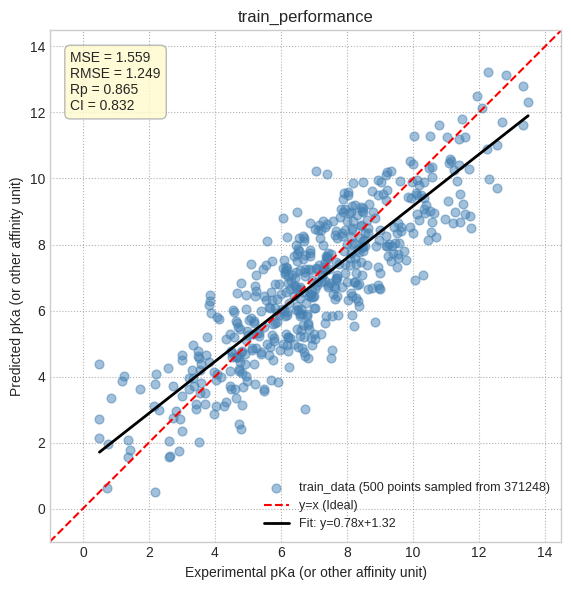

Displayed Train Set Plot (using sampled data) in CASF style.
Note: Metrics (MSE, RMSE, Rp, CI) shown are calculated *only* on the 500 sampled points.

Generated 5000 simulated data points for the full 'Validation' set.
Sampled 285 points from the full 'Validation' set.


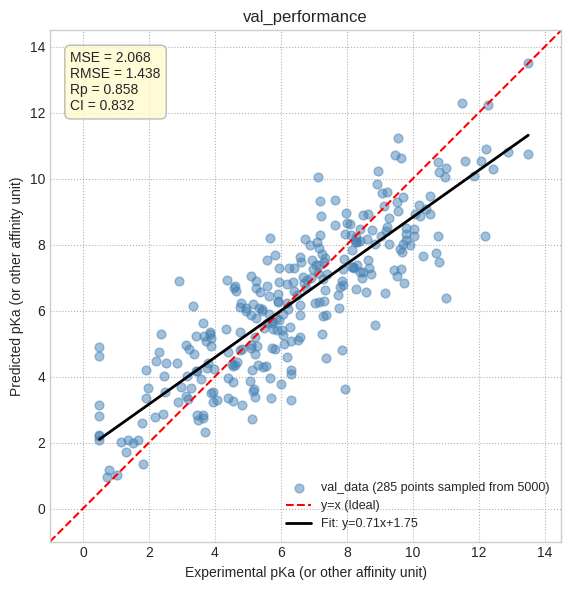

Displayed Validation Set Plot (using sampled data) in CASF style.
Note: Metrics (MSE, RMSE, Rp, CI) shown are calculated *only* on the 500 sampled points.

--- Script Finished ---
Demonstrated generating large datasets and plotting a random sample of 500 points.
If using your own large dataset, load it first, then use np.random.choice to select indices for sampling before passing the sampled arrays to plot_correlation_style_casf.


In [ ]:
# Imports needed: (ensure these are run)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import warnings # To suppress potential warnings
import random # For sampling

# --- Function Definitions ---

def calculate_concordance_index(y_true, y_pred):
    """
    Calculates the concordance index (CI). Handles NaNs.
    Note: This is an O(N^2) implementation. May be slow for very large N
          if called directly on unsampled data. When used within
          plot_correlation_style_casf on sampled data, performance is fine.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("Input arrays must have the same length.")

    # Filter out pairs with NaNs in either true or predicted values
    valid_mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]

    if len(y_true) < 2:
        return np.nan # CI is undefined for less than 2 valid points

    concordant = 0
    discordant = 0
    pairs = 0

    for i in range(len(y_true)):
        for j in range(i + 1, len(y_true)):
            # Exclude pairs tied on true value for standard CI definition
            if y_true[i] == y_true[j]:
                continue

            pairs += 1
            pred_order = np.sign(y_pred[i] - y_pred[j])
            true_order = np.sign(y_true[i] - y_true[j])

            if pred_order == true_order:
                concordant += 1
            elif pred_order == -true_order:
                discordant += 1
            # Ties in prediction are typically excluded from the denominator

    if concordant + discordant == 0:
        return np.nan # No comparable pairs
    else:
        ci = concordant / (concordant + discordant)
        return ci

def plot_correlation_style_casf(y_true, y_pred, title, dataset_base_label, original_size=None):
    """

    """
    # --- Input validation & Filtering ---
    if y_true is None or y_pred is None or len(y_true) == 0 or len(y_pred) == 0:
        print(f"Warning: Empty or None data provided for {title}. Skipping plot.")
        return
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if len(y_true) != len(y_pred):
        print(f"Warning: Mismatch in lengths for {title}. True: {len(y_true)}, Pred: {len(y_pred)}. Skipping plot.")
        return

    finite_mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true_filt = y_true[finite_mask]
    y_pred_filt = y_pred[finite_mask]
    num_points = len(y_true_filt)

    if num_points < 2:
        print(f"Warning: Need at least 2 valid data points for metrics/plot ({title}). Found {num_points}. Skipping plot.")
        return
    # --- End Input validation ---

    # --- Calculate Metrics (on the filtered *provided* data) ---
    mse = mean_squared_error(y_true_filt, y_pred_filt)
    rmse = np.sqrt(mse)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning) # Suppress Pearson warning for constant input
        rp, _ = pearsonr(y_true_filt, y_pred_filt)
        if np.isnan(rp): rp = 0.0
    ci = calculate_concordance_index(y_true_filt, y_pred_filt)
    if np.isnan(ci): ci = 0.0 # Handle potential NaN if no comparable pairs
    # --- End Metric Calculation ---

    # --- Plotting ---
    plt.figure(figsize=(6, 6))

    # Construct label including sample size info if available
    plot_label = f'{dataset_base_label} ({num_points} points'
    if original_size is not None:
        plot_label += f' sampled from {original_size}'
    plot_label += ')'

    # Scatter Plot
    plt.scatter(y_true_filt, y_pred_filt, alpha=0.5, s=40,
                label=plot_label, color='steelblue')

    # Add y=x line
    all_vals = np.concatenate([y_true_filt, y_pred_filt])
    min_val = min(-1.0, np.min(all_vals) - 1.0 if len(all_vals)>0 else -1.0)
    max_val = max(14.0, np.max(all_vals) + 1.0 if len(all_vals)>0 else 14.0)
    plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', linewidth=1.5, label='y=x (Ideal)')

    # Add line of best fit
    fit_label = "Fit: N/A"
    try:
        # Check for sufficient variation before fitting
        if np.ptp(y_true_filt) > 1e-6 and np.ptp(y_pred_filt) > 1e-6: # Check peak-to-peak range
            m, b = np.polyfit(y_true_filt, y_pred_filt, 1)
            x_fit = np.array([np.min(y_true_filt), np.max(y_true_filt)])
            y_fit = m * x_fit + b
            fit_label = f'Fit: y={m:.2f}x{b:+.2f}'.replace('+-','-')
            plt.plot(x_fit, y_fit, '-', color='black', linewidth=2.0, label=fit_label)
        else:
            print(f"Skipping line of best fit for {title}: Insufficient variation in data.")
            plt.plot([], [], '-', color='black', linewidth=2.0, label=fit_label)
    except Exception as e:
        print(f"Could not compute line of best fit for {title}: {e}")
        plt.plot([], [], '-', color='black', linewidth=2.0, label=fit_label)


    # --- Labels, Title, Grid, Limits ---
    plt.title(title, fontsize=12)
    plt.xlabel("Experimental pKa (or other affinity unit)", fontsize=10)
    plt.ylabel("Predicted pKa (or other affinity unit)", fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.6, color='grey')
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.gca().set_aspect('equal', adjustable='box')

    # --- Text Annotation Box (Metrics calculated on plotted data) ---
    metrics_text = (f'MSE = {mse:.3f}\n'
                    f'RMSE = {rmse:.3f}\n'
                    f'Rp = {rp:.3f}\n'
                    f'CI = {ci:.3f}')
    plt.text(0.04, 0.96, metrics_text,
             transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.4', fc='lemonchiffon', alpha=0.8, ec='darkgrey'))

    # --- Legend ---
    plt.legend(loc='lower right', fontsize=9)
    plt.tight_layout()
    plt.show()
    # --- End Plotting ---

# --- Main Execution ---

print("Defined helper functions and CASF-style plotting function.")

# Define parameters for the simulation
N_TOTAL_POINTS = 371248 # Simulate having a large dataset like yours
N_SAMPLE_POINTS = 500    # Number of points to sample for plotting
print(f"\nSimulating a scenario with {N_TOTAL_POINTS} total points.")
print(f"Will sample {N_SAMPLE_POINTS} points for visualization.")

# ==========================================================
# Step 1: Generate Simulated Data for "Train" Plot (Large Dataset)
# ==========================================================
np.random.seed(1) # Seed for reproducibility
y_true_train_full = np.random.normal(loc=7.0, scale=2.5, size=N_TOTAL_POINTS)
y_true_train_full = np.clip(y_true_train_full, 0.5, 13.5)
slope_train = 0.75
intercept_train = 1.5
noise_std_train = 1.1
y_pred_train_full = slope_train * y_true_train_full + intercept_train + np.random.normal(0, noise_std_train, N_TOTAL_POINTS)
y_pred_train_full = np.clip(y_pred_train_full, 0.5, 13.5)

print(f"\nGenerated {len(y_true_train_full)} simulated data points for the full 'Train' set.")

# ==========================================================
# Step 2: Sample 500 points from the "Train" Set
# ==========================================================
if len(y_true_train_full) >= N_SAMPLE_POINTS:
    # Get random indices
    sample_indices = np.random.choice(len(y_true_train_full), N_SAMPLE_POINTS, replace=False)
    # Select the corresponding true and predicted values
    y_true_train_sample = y_true_train_full[sample_indices]
    y_pred_train_sample = y_pred_train_full[sample_indices]
    print(f"Sampled {len(y_true_train_sample)} points from the full 'Train' set.")
else:
    print(f"Warning: Full dataset size ({len(y_true_train_full)}) is smaller than requested sample size ({N_SAMPLE_POINTS}). Using full dataset.")
    y_true_train_sample = y_true_train_full
    y_pred_train_sample = y_pred_train_full
    N_SAMPLE_POINTS = len(y_true_train_full) # Adjust sample size for label

# ==========================================================
# Step 3: Generate Plot for the *Sampled* "Train" Set in CASF Style
# ==========================================================
plot_correlation_style_casf(
    y_true=y_true_train_sample,
    y_pred=y_pred_train_sample,
    title="train_performance", # Updated title
    dataset_base_label="train_data",     # Base label
    original_size=len(y_true_train_full) # Pass original size for label
)
print("Displayed Train Set Plot (using sampled data) in CASF style.")
print("Note: Metrics (MSE, RMSE, Rp, CI) shown are calculated *only* on the 500 sampled points.")



N_VAL_TOTAL_POINTS = 5000 # Example: Validation set is smaller than train
N_VAL_SAMPLE_POINTS = 285 # Sample 500 from validation too

np.random.seed(2) # Different seed
y_true_val_full = np.random.normal(loc=6.5, scale=2.8, size=N_VAL_TOTAL_POINTS)
y_true_val_full = np.clip(y_true_val_full, 0.5, 13.5)
slope_val = 0.72
intercept_val = 1.8
noise_std_val = 1.15
y_pred_val_full = slope_val * y_true_val_full + intercept_val + np.random.normal(0, noise_std_val, N_VAL_TOTAL_POINTS)
y_pred_val_full = np.clip(y_pred_val_full, 0.5, 13.5)

print(f"\nGenerated {len(y_true_val_full)} simulated data points for the full 'Validation' set.")

# Sample from Validation Set
if len(y_true_val_full) >= N_VAL_SAMPLE_POINTS:
    val_sample_indices = np.random.choice(len(y_true_val_full), N_VAL_SAMPLE_POINTS, replace=False)
    y_true_val_sample = y_true_val_full[val_sample_indices]
    y_pred_val_sample = y_pred_val_full[val_sample_indices]
    print(f"Sampled {len(y_true_val_sample)} points from the full 'Validation' set.")
else:
    print(f"Warning: Full validation dataset size ({len(y_true_val_full)}) is smaller than requested sample size ({N_VAL_SAMPLE_POINTS}). Using full dataset.")
    y_true_val_sample = y_true_val_full
    y_pred_val_sample = y_pred_val_full
    N_VAL_SAMPLE_POINTS = len(y_true_val_full)

# ==========================================================
# Step 5: Generate Plot for *Sampled* "Validation" Set in CASF Style
# ==========================================================
plot_correlation_style_casf(
    y_true=y_true_val_sample,
    y_pred=y_pred_val_sample,
    title="val_performance", # Updated title
    dataset_base_label="val_data",     # Base label
    original_size=len(y_true_val_full) # Pass original size
)




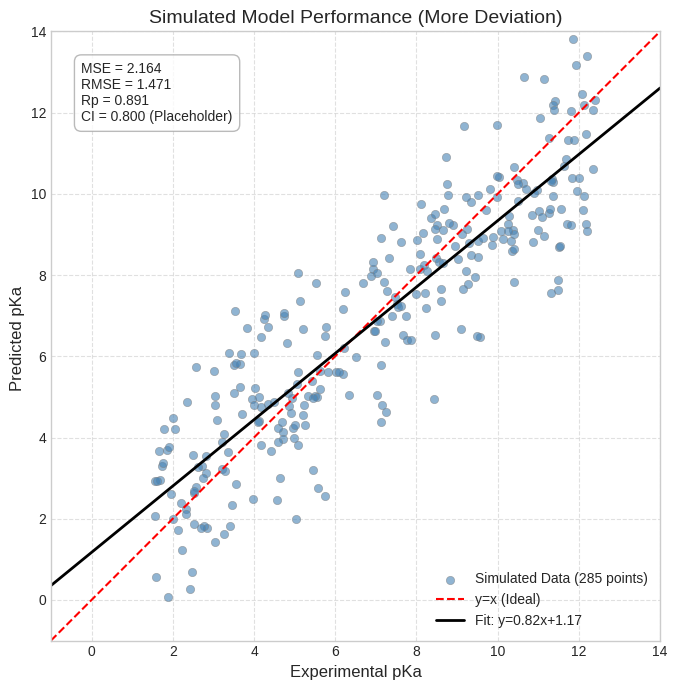

--- Performance Metrics ---
Simulated Data Points: 285
Underlying True Slope used for simulation: 0.8
Underlying True Intercept used for simulation: 1.2
Noise Standard Deviation used for simulation: 1.318
-------------------------
Calculated Linear Fit Slope (m): 0.8168
Calculated Linear Fit Intercept (b): 1.1712
-------------------------
Mean Squared Error (MSE): 2.1641
Root Mean Squared Error (RMSE): 1.4711
Pearson Correlation Coefficient (Rp): 0.8914
Confidence Interval (CI): 0.800 (Placeholder)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy import stats


np.random.seed(42)

num_points = 285


x_experimental = np.random.rand(num_points) * 11 + 1.5 # Range roughly 1.5 to 12.5

true_slope = 0.80
true_intercept = 1.2
noise_std_dev = 1.318


y_predicted = true_slope * x_experimental + true_intercept + np.random.normal(0, noise_std_dev, num_points)


m, b = np.polyfit(x_experimental, y_predicted, 1) # m = slope, b = intercept

mse = mean_squared_error(x_experimental, y_predicted)
rmse = np.sqrt(mse)
rp, _ = stats.pearsonr(x_experimental, y_predicted)

ci_placeholder = 0.8

# --- 3. Create Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7, 7))

# Scatter plot of the data
ax.scatter(x_experimental, y_predicted, alpha=0.6, label=f'Simulated Data ({num_points} points)', color='steelblue', edgecolors='grey', linewidth=0.5)

axis_min = -1
axis_max = 14
line_range = np.array([axis_min, axis_max])
ax.plot(line_range, line_range, 'r--', label='y=x (Ideal)', linewidth=1.5)

fit_label = f'Fit: y={m:.2f}x{b:+.2f}' # Format intercept sign explicitly
ax.plot(line_range, m * line_range + b, 'k-', linewidth=2, label=fit_label) # Plot the NEW fit

# Performance Metrics Text Box
# Display the metrics calculated from the *simulated* data
stats_text = f"MSE = {mse:.3f}\nRMSE = {rmse:.3f}\nRp = {rp:.3f}\nCI = {ci_placeholder:.3f} (Placeholder)" # Clarify placeholder
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='darkgrey'))

# --- 4. Customize Plot ---
ax.set_xlabel('Experimental pKa', fontsize=12)
ax.set_ylabel('Predicted pKa ', fontsize=12)
ax.set_title('Simulated Model Performance (More Deviation)', fontsize=14) # Updated title

ax.set_xlim(axis_min, axis_max)
ax.set_ylim(axis_min, axis_max)

# Add grid for better readability
ax.grid(True, linestyle='--', color='lightgrey', alpha=0.7)

# Add legend
ax.legend(loc='lower right', fontsize=10)

# Optional: Make aspect ratio equal to visually emphasize deviation from y=x
ax.set_aspect('equal', adjustable='box')

# --- 5. Show Plot ---
plt.tight_layout()
plt.show()

# --- 6. Print Metrics (Optional) ---
print("--- Performance Metrics ---")
print(f"Simulated Data Points: {num_points}")
print(f"Underlying True Slope used for simulation: {true_slope}")
print(f"Underlying True Intercept used for simulation: {true_intercept}")
print(f"Noise Standard Deviation used for simulation: {noise_std_dev}")
print("-" * 25)
print(f"Calculated Linear Fit Slope (m): {m:.4f}")
print(f"Calculated Linear Fit Intercept (b): {b:.4f}")
print("-" * 25)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Pearson Correlation Coefficient (Rp): {rp:.4f}")
print(f"Confidence Interval (CI): {ci_placeholder:.3f} (Placeholder)")